# - Joseph: Oncoplot 2

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib.patches as mpatches
import isabl_cli as ii
import re
from pybedtools import BedTool
import requests
import glob
import matplotlib.gridspec as gridspec
import itertools
import matplotlib.lines as mlines
import operator
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable



jet = cm = plt.get_cmap('Blues') 
cNorm  = colors.Normalize(vmin=-0.075, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)


pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

/juno/work/isabl/opt/python/.virtualenvs/users/gutierj2/default_python3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Define color dictionaries

In [25]:
cyto_df.index

Index(['8+', 'Complex', 'Core Binding Factor', 'Fail', 'Other', 't(6;9)'], dtype='object', name='CG_red')

In [2]:
mut_col_dict = {'Adverse':'#ffe196', 'Intermediate':'#d8b5b5', 'Favorable':'#ec7373','Pre-Therapy HP':'cornflowerblue', 'MRD':'purple', 'Relapse HP':'orange'}

mut_col_dict = {'Adverse':'#81FBD2', \
                'Intermediate':'#EBAFE4', \
                'Favorable':'#EEE757',\
                'Pre-Therapy HP':'#EF2F98', \
                'MRD':'#7667EB', \
                'Relapse HP':'orange', \
                '8+':'tab:orange', \
                'Complex':'tab:green', \
                'Core Binding Factor':'tab:red', \
                'Normal':'white', \
                'Other':'tab:olive', \
                't(6;9)':'tab:gray', 'Intensive':'#006B38FF', 'Non-Intensive':'#E94B3CFF'}


mut_col_dict = {'Adverse':'#8da0cb', \
                'Intermediate':'#e78ac3', \
                'Favorable':'#fc8d62',\
                'Pre-Therapy HP':'#313695', \
                'MRD':'#d73027', \
                'Relapse HP':'orange', \
                '8+':'#fbb4ae', \
                'Complex':'#b3cde3', \
                'Core Binding Factor':'#ccebc5', \
                'Normal':'white', \
                'Other':'#decbe4', \
               't(6;9)':'#fed9a6', 'Intensive':'#018571', 'Non-Intensive':'#dfc27d', 'de novo': '#8dd3c7','sAML': '#ffffb3','tAML': '#bebada','refractory': '#fb8072'}




intdict = {'Adverse':12,\
 'Intermediate':2,\
 'Favorable':3,\
 'Pre-Therapy HP':4,\
 'MRD':5,\
 'Relapse HP':6,\
 '8+':7,\
 'Normal':8,\
 'Other':9,\
 'Core Binding Factor':10, \
 't(6;9)':11, \
           'Complex':13, \
           'Fail':14, \
           'Intensive':15, \
           'Non-Intensive':16, \
           'de novo': 17,\
           'sAML': 18,\
           'tAML': 19,\
           'refractory': 20}

intdict_inv = {v: k for k, v in intdict.items()}

intdict_inv

{12: 'Adverse',
 2: 'Intermediate',
 3: 'Favorable',
 4: 'Pre-Therapy HP',
 5: 'MRD',
 6: 'Relapse HP',
 7: '8+',
 8: 'Normal',
 9: 'Other',
 10: 'Core Binding Factor',
 11: 't(6;9)',
 13: 'Complex',
 14: 'Fail',
 15: 'Intensive',
 16: 'Non-Intensive',
 17: 'de novo',
 18: 'sAML',
 19: 'tAML',
 20: 'refractory'}

### Read in data

In [3]:
# data = pd.read_csv('/work/isabl/home/mccartej/p142/p142_onco_df.csv', sep=',')
data = pd.read_csv('/work/isabl/home/mccartej/p142/p142_onco_df_filtered.tsv', sep='\t')
# data = data[['pid', 'sid', 'VAG_GENE', 'likelyDriver', 'VAG_EFFECT', 'TARGET_VAF_MEAN', 'disease_short']]
data = data[~data['timepoint'].str.contains('Normal')]
data = data.drop([rec for rec in data.columns.tolist() if 'Unnamed' in rec], axis=1)
data.columns = ['pid', 'sid', 'VAG_EFFECT', 'VAF', 'DEP', 'VAG_GENE', 'ptc', 'TIMEPOINT', 'sampletype', 'cvg', 'group', 'patvar', 'patvarkey', 'patsamp', 'DIAGNOSIS', 'therapy', 'INTENSITY', 'ELN', 'CG', 'CG_red', 'IDH']
data = data.fillna('-')
data['pid'] = data['pid'].apply(lambda x: str(x))
# data = data[data['VAG_GENE']!='-']
# data = data[data['VAG_EFFECT']!='synonymous_codon']


dataT = data.groupby(['pid', 'sid', 'TIMEPOINT'])['INTENSITY'].count()
dataT.head()

pid     sid                   TIMEPOINT     
109037  I-H-109037-T3-1-D1-1  MRD               5
        I-H-109037-T4-1-D1-1  Pre-Therapy HP    5
112855  I-H-112855-T1-1-D1-2  Pre-Therapy HP    4
        I-H-112855-T2-1-D1-1  MRD               4
113385  I-H-113385-T1-1-D1-2  Pre-Therapy HP    8
Name: INTENSITY, dtype: int64

In [4]:
dataT = data.groupby(['pid', 'sid', 'TIMEPOINT'])['INTENSITY'].count().reset_index()
#dataT['INTENSITY'] = 1
dataT = dataT.pivot_table(columns='TIMEPOINT', index='pid', values='INTENSITY')
dataT['sum'] = dataT.sum(axis=1)
pid_order = dataT.reset_index().sort_values(by=['sum', 'pid']).set_index('pid').index.tolist()
dataT

TIMEPOINT,MRD,Pre-Therapy HP,sum
pid,,,
109037,5,5,10
112855,4,4,8
113385,8,8,16
113386,1,1,2
113387,2,2,4
113388,2,2,4
113390,13,13,26
118804,5,5,10
121248,1,1,2


In [5]:
pid_order

['113386',
 '121248',
 '133945',
 '135950',
 '135960',
 '156397',
 '113387',
 '113388',
 '133126',
 '133566',
 '135951',
 '156394',
 '156400',
 '133129',
 '133567',
 '134807',
 '135419',
 '156396',
 '112855',
 '133565',
 '135958',
 '156404',
 '109037',
 '118804',
 '135952',
 '135954',
 '133563',
 '135957',
 '156402',
 '113385',
 '131927',
 '133128',
 '133564',
 '135961',
 '135955',
 '135956',
 '113390',
 '121391']

In [6]:
# data = pd.read_csv('/work/isabl/home/mccartej/p142/p142_onco_df.csv', sep=',')
data = pd.read_csv('/work/isabl/home/mccartej/p142/p142_onco_df_filtered.tsv', sep='\t')
# data = data[['pid', 'sid', 'VAG_GENE', 'likelyDriver', 'VAG_EFFECT', 'TARGET_VAF_MEAN', 'disease_short']]
data = data[~data['timepoint'].str.contains('Normal')]
data = data.drop([rec for rec in data.columns.tolist() if 'Unnamed' in rec], axis=1)
data.columns = ['pid', 'sid', 'VAG_EFFECT', 'VAF', 'DEP', 'VAG_GENE', 'ptc', 'TIMEPOINT', 'sampletype', 'cvg', 'group', 'patvar', 'patvarkey', 'patsamp', 'DIAGNOSIS', 'therapy', 'INTENSITY', 'ELN', 'CG', 'CG_red', 'IDH']
data = data.fillna('-')
data['pid'] = data['pid'].apply(lambda x: str(x))
# data = data[data['VAG_GENE']!='-']
# data = data[data['VAG_EFFECT']!='synonymous_codon']



dataT = data.groupby(['pid', 'sid', 'TIMEPOINT'])['INTENSITY'].count().reset_index()
#dataT['INTENSITY'] = 1
dataT = dataT.pivot_table(columns='TIMEPOINT', index='pid', values='INTENSITY')
dataT['sum'] = dataT.sum(axis=1)
pid_order = dataT.reset_index().sort_values(by=['sum', 'pid']).set_index('pid').index.tolist()

sorterIndex = dict(zip(pid_order,range(len(pid_order))))
data['rank'] = data['pid'].map(sorterIndex)

data.loc[data['TIMEPOINT']=='Pre-Therapy HP', 'trank'] = 1
data.loc[data['TIMEPOINT']=='MRD', 'trank'] = 2
data.loc[data['TIMEPOINT']=='Relapse HP', 'trank'] = 3

data.loc[data['DIAGNOSIS']=='SAML', 'DIAGNOSIS'] = 'sAML'
data.loc[data['DIAGNOSIS']=='refractory/relapse', 'DIAGNOSIS'] = 'refractory'

In [7]:
data[data['pid']=='109037']

,pid,sid,VAG_EFFECT,VAF,DEP,VAG_GENE,ptc,TIMEPOINT,sampletype,cvg,group,patvar,patvarkey,patsamp,DIAGNOSIS,therapy,INTENSITY,ELN,CG,CG_red,IDH,rank,trank
0,109037,I-H-109037-T3-1-D1-1,5_38960627_C_T,0.0000,42,RICTOR,R575Q,MRD,Flow Sorted Blasts,30.7,2,109037_RICTOR_R575Q,109037_5_38960627_C_T,109037_Flow Sorted Blasts,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,2.0
1,109037,I-H-109037-T3-1-D1-1,15_90631934_C_T,0.3429,35,IDH2,R140Q,MRD,Flow Sorted Blasts,30.7,2,109037_IDH2_R140Q,109037_15_90631934_C_T,109037_Flow Sorted Blasts,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,2.0
2,109037,I-H-109037-T3-1-D1-1,5_170837544_T_TCTGC,0.4242,34,NPM1,p.W288fs*12,MRD,Flow Sorted Blasts,30.7,2,109037_NPM1_p.W288fs*12,109037_5_170837544_T_TCTGC,109037_Flow Sorted Blasts,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,2.0
3,109037,I-H-109037-T3-1-D1-1,2_25470917_GCT_G,0.2655,308,DNMT3A,p.E281fs*42,MRD,Flow Sorted Blasts,30.7,2,109037_DNMT3A_p.E281fs*42,109037_2_25470917_GCT_G,109037_Flow Sorted Blasts,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,2.0
4,109037,I-H-109037-T3-1-D1-1,6_152419926_A_G,0.0870,46,ESR1,D538G,MRD,Flow Sorted Blasts,30.7,2,109037_ESR1_D538G,109037_6_152419926_A_G,109037_Flow Sorted Blasts,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,2.0
5,109037,I-H-109037-T4-1-D1-1,2_25470917_GCT_G,0.4177,2412,DNMT3A,p.E281fs*42,Pre-Therapy HP,BMA Slides,660.6,2,109037_DNMT3A_p.E281fs*42,109037_2_25470917_GCT_G,109037_BMA Slides,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,1.0
6,109037,I-H-109037-T4-1-D1-1,5_170837544_T_TCTGC,0.4789,71,NPM1,p.W288fs*12,Pre-Therapy HP,BMA Slides,660.6,2,109037_NPM1_p.W288fs*12,109037_5_170837544_T_TCTGC,109037_BMA Slides,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,1.0
7,109037,I-H-109037-T4-1-D1-1,6_152419926_A_G,0.0000,1050,ESR1,D538G,Pre-Therapy HP,BMA Slides,660.6,2,109037_ESR1_D538G,109037_6_152419926_A_G,109037_BMA Slides,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,1.0
8,109037,I-H-109037-T4-1-D1-1,15_90631934_C_T,0.3784,1895,IDH2,R140Q,Pre-Therapy HP,BMA Slides,660.6,2,109037_IDH2_R140Q,109037_15_90631934_C_T,109037_BMA Slides,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,1.0
9,109037,I-H-109037-T4-1-D1-1,5_38960627_C_T,0.0000,248,RICTOR,R575Q,Pre-Therapy HP,BMA Slides,660.6,2,109037_RICTOR_R575Q,109037_5_38960627_C_T,109037_BMA Slides,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,1.0


In [8]:
set(data['INTENSITY'])

{'Intensive', 'Non-Intensive'}

In [9]:
# data.drop_duplicates(subset='CG_red')

In [28]:
pat_order_df.head()

,pid_rank,pid
0,0,109037
1,1,113390
2,2,118804
3,3,121391
4,4,131927


In [27]:
relapse = ['109037','113390','118804','121391','131927','133128','133129','133563','133567','135961','133565','135950','135955','156402','135956','135957','135958','156394','156399','156404']
non_relapse =['112855','113385','113386','113387','113388','121248','133126','133564','133566','133945','134807','135951','135952','135954','135960','135419','156396','156397','156400']

pat_order = relapse + non_relapse

pat_order_df = pd.DataFrame(list(enumerate(pat_order)), columns = ['pid_rank', 'pid'])

data = pd.merge(data, pat_order_df, on='pid')
data = data.sort_values(by=['pid_rank', 'trank']).reset_index(drop=True)

In [29]:
data.head()

,pid,sid,VAG_EFFECT,VAF,DEP,VAG_GENE,ptc,TIMEPOINT,sampletype,cvg,group,patvar,patvarkey,patsamp,DIAGNOSIS,therapy,INTENSITY,ELN,CG,CG_red,IDH,rank,trank,pid_rank
0,109037,I-H-109037-T4-1-D1-1,2_25470917_GCT_G,0.4177,2412,DNMT3A,p.E281fs*42,Pre-Therapy HP,BMA Slides,660.6,2,109037_DNMT3A_p.E281fs*42,109037_2_25470917_GCT_G,109037_BMA Slides,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,1.0,0
1,109037,I-H-109037-T4-1-D1-1,5_170837544_T_TCTGC,0.4789,71,NPM1,p.W288fs*12,Pre-Therapy HP,BMA Slides,660.6,2,109037_NPM1_p.W288fs*12,109037_5_170837544_T_TCTGC,109037_BMA Slides,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,1.0,0
2,109037,I-H-109037-T4-1-D1-1,6_152419926_A_G,0.0000,1050,ESR1,D538G,Pre-Therapy HP,BMA Slides,660.6,2,109037_ESR1_D538G,109037_6_152419926_A_G,109037_BMA Slides,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,1.0,0
3,109037,I-H-109037-T4-1-D1-1,15_90631934_C_T,0.3784,1895,IDH2,R140Q,Pre-Therapy HP,BMA Slides,660.6,2,109037_IDH2_R140Q,109037_15_90631934_C_T,109037_BMA Slides,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,1.0,0
4,109037,I-H-109037-T4-1-D1-1,5_38960627_C_T,0.0000,248,RICTOR,R575Q,Pre-Therapy HP,BMA Slides,660.6,2,109037_RICTOR_R575Q,109037_5_38960627_C_T,109037_BMA Slides,de novo,7+3 Induction (12/10/14),Intensive,Favorable,Karyotype Failure,Fail,other,22,1.0,0


In [30]:
data['DIAGNOSIS'].unique()

array(['de novo', 'sAML', 'tAML', 'refractory'], dtype=object)

### Main functions to subset data, generate Heatmap Dataframes and gene ordering

In [31]:
def subset_data(df, disease_list=False, sample_list=False):
    if sample_list:
        df = df[df['sid'].isin(sample_list)]
    if disease_list:
        df = df[df['disease_short'].isin(disease_list)]
    return df


def heatmap_background(df):
    samples = df['sid'].unique()
    genes = df['VAG_GENE'].unique()
    genes = [gene for gene in genes if gene != '-']
    
    bk_df = pd.DataFrame(columns=samples, index=genes).fillna(0)
    
    return bk_df
 
    
def heatmap_foreground(df, index, column ,columns_list):
    df = df.pivot_table(index='VAG_GENE', \
                        columns='sid', \
                        values=column, \
                        aggfunc='first')
    
    df = df[df.index.isin(index)]
    df = df.reindex(index)
    df = df[columns_list]
    
    return df

   
def make_side_stacker_bk(side_stack_df, index):
    index = side_stack_df.index.tolist()
    columns = side_stack_df.columns.tolist()
    
    bk_df = pd.DataFrame(columns=columns, index=index).fillna(1).applymap(lambda x: (x/x))
    bk_df = bk_df.reindex(index)
    return bk_df


def make_side_stacker(foreground_df, index):
#     stacker = foreground_df.replace(intdict).unstack().reset_index()
    stacker = foreground_df.unstack().reset_index()
    
    stacker = stacker[stacker[0]>0]
    
    stacker[0] = stacker[0].astype(str)
    stacker.columns = ['level_0', 'level_1', 0]
    
    order_of_genes =list(stacker.groupby('level_1')[0].count().sort_values(ascending=False).index)
    
    
    grouper_index = stacker.groupby('level_1')[0].agg(lambda x: ','.join((x))).reset_index()[['level_1']]
    
    grouper_columns = stacker.groupby('level_1')[0].agg(lambda x: ','.join((x))).reset_index()[0].str.split(',', expand=True)

    stackermerge = pd.concat([grouper_index, grouper_columns], ignore_index=True, axis=1).set_index(0).reindex(index)

    return stackermerge, order_of_genes


def demo_frame(df, column, columns_list):
    
    data = {'sid':df['sid'].tolist(), \
            column:df[column].tolist() }
    
    df = pd.DataFrame(data)
    df = df.pivot_table(columns='sid', \
                        values=column, aggfunc='first')
    
    
    df = df[columns_list]

    return df


def make_top_stacker(foreground_df):
    
    top_stack = foreground_df.replace(0, None)\
    .apply(lambda x: x.sort_values(ascending=False).values)\
    .reindex(index=hm_fg.index[::-1])\
    .dropna(axis = 0, how = 'all').reset_index(drop=True)

    return top_stack


def make_cyto_df(df, columns_list):
    
    cyto = data.pivot_table(index='CG_red', columns='sid', values='trank').drop('Normal')
    
    cyto = cyto[columns_list]
    
    for idx in cyto.index:
        cyto.loc[idx] = cyto.loc[idx].apply(lambda x: idx if x/x==1 else np.nan)
    
    return cyto


def oppstack(df, order_of_genes, relapse = True):
    df_sorter = df.replace(intdict).reindex(order_of_genes).drop(['ELN', 'TIMEPOINT', 'INTENSITY', 'SPACER2', 'DIAGNOSIS']).replace(0, np.nan)
    a = df_sorter.values

    a.sort(axis=1)

    if relapse:
        a = a[:, ::-1]

    fg = pd.DataFrame(a, df_sorter.index, df_sorter.columns).dropna(how='all', axis=1).fillna(0)
#     fg = fg.iloc[:, ::-1]
    bk = fg.applymap(lambda x: (x+1)/(x+1))
    
    for i in [1,2,3,4,5]:
        fg.loc[fg.shape[0]] = np.nan
        bk.loc[bk.shape[0]] = np.nan
        
    fg = fg.fillna(0)
    bk = bk.fillna(0)
    
    return fg, bk


def make_line_spacing(df1, df2):
    merge = pd.merge(df1[['pid', 'sid']],pd.DataFrame(df2.columns), on='sid', how='outer').drop_duplicates().reset_index(drop=True).fillna('cspace')
    merge['val'] = 1
    merge_pivot = merge.pivot_table(columns='sid', values='val', index='pid')
    merge_pivot_reorder = merge_pivot[col_order]
    
    
    merge_pivot_reorder = merge_pivot_reorder.unstack().reset_index()
    
    merge_pivot_reorder = merge_pivot_reorder[merge_pivot_reorder[0]==1]
    

    
    linestacker = [0]+merge_pivot_reorder.drop_duplicates(subset=['pid', 'sid']).reset_index(drop=True).groupby(['pid'], sort = False)['sid'].count().reset_index()['sid'].cumsum().tolist()
    
    return linestacker

### Make main dataframes and side stacks

In [32]:
## subset data you want to plot using either, disease list OR sample ID list
hm_data = subset_data(data)
## Create background heatmap df
hm_bk = heatmap_background(hm_data)
## Create foreground heatmap df
hm_fg = heatmap_foreground(hm_data, hm_bk.index, 'VAF',hm_bk.columns)
## Create foreground df for side stack
side_stack, order_of_genes = make_side_stacker(hm_fg, hm_bk.index) ###fix this
## Create background df for side stack
side_stack_bk = make_side_stacker_bk(side_stack, hm_bk.index) ###fix this
## Create top stack
top_stack = make_top_stacker(hm_fg)
## Create cyto df
cyto_df = make_cyto_df(data, hm_bk.columns)
## Create Cyto df side stack and order
cyto_df_side_stack, cyto_df_order_of_genes = make_side_stacker(cyto_df.replace(intdict), cyto_df.index)

In [38]:
top_stack

sid,I-H-109037-T4-1-D1-1,I-H-109037-T3-1-D1-1,I-H-113390-T1-1-D1-2,I-H-113390-T2-1-D1-1,I-H-118804-T3-1-D1-1,I-H-118804-T2-2-D1-1,I-H-121391-T3-1-D1-1,I-H-121391-T2-1-D1-1,I-H-131927-T3-1-D1-1,I-H-131927-T2-1-D1-1,I-H-133128-T2-1-D1-1,I-H-133128-T1-1-D1-1,I-H-133129-T3-1-D1-1,I-H-133129-T1-1-D1-1,I-H-133563-T2-1-D1-1,I-H-133563-T1-2-D1-1,I-H-133567-T2-1-D1-1,I-H-133567-T1-1-D1-1,I-H-135961-T3-1-D1-1,I-H-135961-T1-1-D1-1,I-H-133565-T2-1-D1-1,I-H-133565-T1-1-D1-1,IID_H135950_T02_01_TD01,I-H-135950-T1-2-D1-1,IID_H135955_T02_01_TD01,I-H-135955-T1-1-D1-1,IID_H156402_T02_01_TD01,IID_H156402_T01_01_TD01,I-H-135956-T2-1-D1-1,I-H-135956-T1-1-D1-1,I-H-135957-T2-1-D1-1,I-H-135957-T1-2-D1-1,I-H-135958-T2-1-D1-1,I-H-135958-T1-1-D1-1,IID_H156394_T02_01_TD01,IID_H156394_T01_02_TD01,IID_H156404_T02_01_TD01,IID_H156404_T01_02_TD01,I-H-112855-T1-1-D1-2,I-H-112855-T2-1-D1-1,I-H-113385-T1-1-D1-2,I-H-113385-T3-1-D1-1,I-H-113386-T1-1-D1-2,I-H-113386-T2-1-D1-1,I-H-113387-T1-1-D1-2,I-H-113387-T2-1-D1-1,I-H-113388-T1-1-D1-2,I-H-113388-T2-1-D1-1,I-H-121248-T3-1-D1-1,I-H-121248-T2-1-D1-1,I-H-133126-T2-1-D1-1,I-H-133126-T1-1-D1-1,I-H-133564-T2-1-D1-1,I-H-133564-T1-1-D1-1,I-H-133566-T2-1-D1-1,I-H-133566-T1-1-D1-1,I-H-133945-T2-1-D1-1,I-H-133945-T1-2-D1-1,I-H-134807-T2-1-D1-1,I-H-134807-T1-1-D1-1,I-H-135951-T2-1-D1-1,IID_H135951_T03_01_TD01,I-H-135952-T3-1-D1-1,I-H-135952-T1-1-D1-1,I-H-135954-T2-1-D1-1,I-H-135954-T1-1-D1-1,I-H-135960-T2-1-D1-1,I-H-135960-T1-1-D1-1,IID_H135419_T02_02_TD01,IID_H135419_T03_01_TD01,IID_H156396_T02_01_TD01,IID_H156396_T01_01_TD01,IID_H156397_T02_01_TD01,IID_H156397_T01_01_TD01,IID_H156400_T02_01_TD01,IID_H156400_T01_01_TD01
0,NaN,NaN,NaN,NaN,NaN,NaN,0.0074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.0020,NaN,NaN,0.0161,0.0031,0.0265,0.0058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.0236,0.0020,NaN,NaN,0.0334,0.0033,0.0757,0.0058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0213,NaN,NaN,NaN,NaN,NaN,0.0319,0.0045,0.0018,0.0251,0.0012,0.0185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0159,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.2256,0.0020,NaN,NaN,0.0348,0.0060,0.0762,0.0294,0.0021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1166,0.0065,NaN,NaN,NaN,NaN,0.1103,0.0446,0.0426,0.0273,0.0083,0.0234,0.0061,0.0526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0186,0.0769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.3784,0.0870,0.2256,0.0228,NaN,NaN,0.0348,0.0632,0.0799,0.0500,0.0152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4082,0.0248,NaN,NaN,NaN,NaN,0.3479,0.1636,0.3401,0.0406,0.0311,0.0238,0.0147,0.2353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0007,0.1402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2815,0.0862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.3784,0.2655,0.2357,0.0228,0.2648,NaN,0.3820,0.0632,0.2115,0.3560,0.0355,NaN,NaN,NaN,0.0019,NaN,NaN,NaN,0.4118,0.3529,NaN,NaN,NaN,NaN,0.4017,0.1694,0.3599,0.0705,0.0388,0.0526,0.0147,0.2353,NaN,NaN,NaN,NaN,0.3824,0.4271,0.0774,0.2456,0.0007,0.1865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2964,0.1333,NaN,

### Make demographic data

In [33]:
# primary diagnosis, ELN class, CG and therapy 


ELN = demo_frame(hm_data, 'ELN',hm_bk.columns)
# .replace({'Adverse':'#e8ead3', 'Intermediate':'#fbd46d', 'Favorable':'#ff9c71'})

timepoint = demo_frame(hm_data, 'TIMEPOINT',hm_bk.columns)
# .replace({'Pre-Therapy HP':'green', 'MRD':'purple', 'Relapse HP':'orange'})

intensity = demo_frame(hm_data, 'INTENSITY',hm_bk.columns)
# .replace({'Pre-Therapy HP':'green', 'MRD':'purple', 'Relapse HP':'orange'})

diagnosis = demo_frame(hm_data, 'DIAGNOSIS',hm_bk.columns)
# .replace({'Pre-Therapy HP':'green', 'MRD':'purple', 'Relapse HP':'orange'})

order_of_genes = order_of_genes + ['SPACER1'] + cyto_df_order_of_genes + ['SPACER2'] + ['TIMEPOINT', 'ELN','INTENSITY', 'DIAGNOSIS']

In [34]:
new_bk = pd.concat([hm_bk, cyto_df, timepoint, ELN, intensity, diagnosis]).replace({'\S': 0}, regex=True).fillna(0)
new_fg = pd.concat([hm_fg, cyto_df, timepoint, ELN, intensity, diagnosis]).fillna(0)

for i in ['cspacer1', 'cspacer2', 'cspacer3', 'cspacer4', 'cspacer5']:
    new_bk[i] = 0
    new_fg[i] = 0
    
rel_df = new_fg[[x for x in new_fg.columns.tolist() if any(x in y or y in x for y in relapse)]]
non_rel_df = new_fg[[x for x in new_fg.columns.tolist() if any(x in y or y in x for y in non_relapse)]]
col_order = rel_df.columns.tolist()+['cspacer1', 'cspacer2', 'cspacer3', 'cspacer4', 'cspacer5']+non_rel_df.columns.tolist()

explode_l_fg, explode_l_bg = oppstack(rel_df, order_of_genes, relapse = True)
explode_r_fg, explode_r_bg = oppstack(non_rel_df, order_of_genes, relapse = False)

exploder = pd.concat([explode_l_fg, explode_r_fg], axis=1)
exploder_bk = pd.concat([explode_l_bg, explode_r_bg], axis=1)

for i in ['cspacer1', 'cspacer2', 'cspacer3', 'cspacer4', 'cspacer5']:
    exploder[i] = 0
    exploder_bk[i] = 0

new_bk = new_bk[col_order]
new_fg = new_fg[col_order]

new_side_stack = pd.concat([side_stack.astype(float), cyto_df_side_stack.astype(float).replace(intdict_inv)]).reindex(order_of_genes).drop(['SPACER2','TIMEPOINT', 'ELN','INTENSITY','DIAGNOSIS'])
new_side_stack_bk = make_side_stacker_bk(new_side_stack, new_side_stack.index)


new_top_stack = make_top_stacker(new_fg.drop(['TIMEPOINT', 'ELN','INTENSITY', 'DIAGNOSIS'])\
                 .replace({'Fail':None})\
                 .replace(intdict)\
                 .replace({0:None}))

In [40]:
top_stack

sid,I-H-109037-T4-1-D1-1,I-H-109037-T3-1-D1-1,I-H-113390-T1-1-D1-2,I-H-113390-T2-1-D1-1,I-H-118804-T3-1-D1-1,I-H-118804-T2-2-D1-1,I-H-121391-T3-1-D1-1,I-H-121391-T2-1-D1-1,I-H-131927-T3-1-D1-1,I-H-131927-T2-1-D1-1,I-H-133128-T2-1-D1-1,I-H-133128-T1-1-D1-1,I-H-133129-T3-1-D1-1,I-H-133129-T1-1-D1-1,I-H-133563-T2-1-D1-1,I-H-133563-T1-2-D1-1,I-H-133567-T2-1-D1-1,I-H-133567-T1-1-D1-1,I-H-135961-T3-1-D1-1,I-H-135961-T1-1-D1-1,I-H-133565-T2-1-D1-1,I-H-133565-T1-1-D1-1,IID_H135950_T02_01_TD01,I-H-135950-T1-2-D1-1,IID_H135955_T02_01_TD01,I-H-135955-T1-1-D1-1,IID_H156402_T02_01_TD01,IID_H156402_T01_01_TD01,I-H-135956-T2-1-D1-1,I-H-135956-T1-1-D1-1,I-H-135957-T2-1-D1-1,I-H-135957-T1-2-D1-1,I-H-135958-T2-1-D1-1,I-H-135958-T1-1-D1-1,IID_H156394_T02_01_TD01,IID_H156394_T01_02_TD01,IID_H156404_T02_01_TD01,IID_H156404_T01_02_TD01,I-H-112855-T1-1-D1-2,I-H-112855-T2-1-D1-1,I-H-113385-T1-1-D1-2,I-H-113385-T3-1-D1-1,I-H-113386-T1-1-D1-2,I-H-113386-T2-1-D1-1,I-H-113387-T1-1-D1-2,I-H-113387-T2-1-D1-1,I-H-113388-T1-1-D1-2,I-H-113388-T2-1-D1-1,I-H-121248-T3-1-D1-1,I-H-121248-T2-1-D1-1,I-H-133126-T2-1-D1-1,I-H-133126-T1-1-D1-1,I-H-133564-T2-1-D1-1,I-H-133564-T1-1-D1-1,I-H-133566-T2-1-D1-1,I-H-133566-T1-1-D1-1,I-H-133945-T2-1-D1-1,I-H-133945-T1-2-D1-1,I-H-134807-T2-1-D1-1,I-H-134807-T1-1-D1-1,I-H-135951-T2-1-D1-1,IID_H135951_T03_01_TD01,I-H-135952-T3-1-D1-1,I-H-135952-T1-1-D1-1,I-H-135954-T2-1-D1-1,I-H-135954-T1-1-D1-1,I-H-135960-T2-1-D1-1,I-H-135960-T1-1-D1-1,IID_H135419_T02_02_TD01,IID_H135419_T03_01_TD01,IID_H156396_T02_01_TD01,IID_H156396_T01_01_TD01,IID_H156397_T02_01_TD01,IID_H156397_T01_01_TD01,IID_H156400_T02_01_TD01,IID_H156400_T01_01_TD01
0,NaN,NaN,NaN,NaN,NaN,NaN,0.0074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.0020,NaN,NaN,0.0161,0.0031,0.0265,0.0058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.0236,0.0020,NaN,NaN,0.0334,0.0033,0.0757,0.0058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0213,NaN,NaN,NaN,NaN,NaN,0.0319,0.0045,0.0018,0.0251,0.0012,0.0185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0159,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.2256,0.0020,NaN,NaN,0.0348,0.0060,0.0762,0.0294,0.0021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1166,0.0065,NaN,NaN,NaN,NaN,0.1103,0.0446,0.0426,0.0273,0.0083,0.0234,0.0061,0.0526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0186,0.0769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.3784,0.0870,0.2256,0.0228,NaN,NaN,0.0348,0.0632,0.0799,0.0500,0.0152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4082,0.0248,NaN,NaN,NaN,NaN,0.3479,0.1636,0.3401,0.0406,0.0311,0.0238,0.0147,0.2353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0007,0.1402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2815,0.0862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.3784,0.2655,0.2357,0.0228,0.2648,NaN,0.3820,0.0632,0.2115,0.3560,0.0355,NaN,NaN,NaN,0.0019,NaN,NaN,NaN,0.4118,0.3529,NaN,NaN,NaN,NaN,0.4017,0.1694,0.3599,0.0705,0.0388,0.0526,0.0147,0.2353,NaN,NaN,NaN,NaN,0.3824,0.4271,0.0774,0.2456,0.0007,0.1865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2964,0.1333,NaN,

In [39]:
new_top_stack

sid,I-H-109037-T4-1-D1-1,I-H-109037-T3-1-D1-1,I-H-113390-T1-1-D1-2,I-H-113390-T2-1-D1-1,I-H-118804-T3-1-D1-1,I-H-118804-T2-2-D1-1,I-H-121391-T3-1-D1-1,I-H-121391-T2-1-D1-1,I-H-131927-T3-1-D1-1,I-H-131927-T2-1-D1-1,I-H-133128-T2-1-D1-1,I-H-133128-T1-1-D1-1,I-H-133129-T3-1-D1-1,I-H-133129-T1-1-D1-1,I-H-133563-T2-1-D1-1,I-H-133563-T1-2-D1-1,I-H-133567-T2-1-D1-1,I-H-133567-T1-1-D1-1,I-H-135961-T3-1-D1-1,I-H-135961-T1-1-D1-1,I-H-133565-T2-1-D1-1,I-H-133565-T1-1-D1-1,IID_H135950_T02_01_TD01,I-H-135950-T1-2-D1-1,IID_H135955_T02_01_TD01,I-H-135955-T1-1-D1-1,IID_H156402_T02_01_TD01,IID_H156402_T01_01_TD01,I-H-135956-T2-1-D1-1,I-H-135956-T1-1-D1-1,I-H-135957-T2-1-D1-1,I-H-135957-T1-2-D1-1,I-H-135958-T2-1-D1-1,I-H-135958-T1-1-D1-1,IID_H156394_T02_01_TD01,IID_H156394_T01_02_TD01,IID_H156404_T02_01_TD01,IID_H156404_T01_02_TD01,cspacer1,cspacer2,cspacer3,cspacer4,cspacer5,I-H-112855-T1-1-D1-2,I-H-112855-T2-1-D1-1,I-H-113385-T1-1-D1-2,I-H-113385-T3-1-D1-1,I-H-113386-T1-1-D1-2,I-H-113386-T2-1-D1-1,I-H-113387-T1-1-D1-2,I-H-113387-T2-1-D1-1,I-H-113388-T1-1-D1-2,I-H-113388-T2-1-D1-1,I-H-121248-T3-1-D1-1,I-H-121248-T2-1-D1-1,I-H-133126-T2-1-D1-1,I-H-133126-T1-1-D1-1,I-H-133564-T2-1-D1-1,I-H-133564-T1-1-D1-1,I-H-133566-T2-1-D1-1,I-H-133566-T1-1-D1-1,I-H-133945-T2-1-D1-1,I-H-133945-T1-2-D1-1,I-H-134807-T2-1-D1-1,I-H-134807-T1-1-D1-1,I-H-135951-T2-1-D1-1,IID_H135951_T03_01_TD01,I-H-135952-T3-1-D1-1,I-H-135952-T1-1-D1-1,I-H-135954-T2-1-D1-1,I-H-135954-T1-1-D1-1,I-H-135960-T2-1-D1-1,I-H-135960-T1-1-D1-1,IID_H135419_T02_02_TD01,IID_H135419_T03_01_TD01,IID_H156396_T02_01_TD01,IID_H156396_T01_01_TD01,IID_H156397_T02_01_TD01,IID_H156397_T01_01_TD01,IID_H156400_T02_01_TD01,IID_H156400_T01_01_TD01
0,None,None,None,None,None,None,0.0074,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,0.0139,None,0.0265,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.0013,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,0.0161,0.0031,0.0757,0.0058,None,None,None,None,None,None,None,None,0.0213,None,None,None,None,None,None,None,0.0018,0.0251,0.0012,0.0185,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.0159,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,0.0334,0.0033,0.0762,0.0294,None,None,None,None,None,None,None,None,0.1166,0.0065,None,None,None,None,0.0319,0.0045,0.0426,0.0273,0.0083,0.0234,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.0224,None,None,None,None,None,None,None,None,None,None,0.0186,0.0769,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,0.0348,0.006,0.0799,0.05,0.0021,None,None,None,None,None,None,None,0.4082,0.0248,None,None,None,None,0.1103,0.0446,0.3401,0.0406,0.0311,0.0238,0.0061,0.0526,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.0465,None,None,None,None,None,None,None,None,None,None,0.2815,0.0862,None,None,None,None,None,None,None,None,None,None,None,0.03,None,None,None,None,None,None,None,None,None,None
5,None,None,0.0236,0.002,None,None,0.382,0.0632,0.2115,0.356,0.0152,None,None,None,None,None,None,None,0.4118,0.3529,None,None,None,None,0.3479,0.1636,0.3599,0.0705,0.0388,0.0526

### Plot data

In [172]:
intdict_inv

{12: 'Adverse',
 2: 'Intermediate',
 3: 'Favorable',
 4: 'Pre-Therapy HP',
 5: 'MRD',
 6: 'Relapse HP',
 7: '8+',
 8: 'Normal',
 9: 'Other',
 10: 'Core Binding Factor',
 11: 't(6;9)',
 13: 'Complex',
 14: 'Fail',
 15: 'Intensive',
 16: 'Non-Intensive',
 17: 'de novo',
 18: 'sAML',
 19: 'tAML',
 20: 'refractory'}

In [173]:
mut_col_dict

{'Adverse': '#8da0cb',
 'Intermediate': '#e78ac3',
 'Favorable': '#fc8d62',
 'Matched': '#8DA0CB',
 'Unmatched': '#E78AC3',
 'Relapse HP': 'orange',
 '8+': '#fbb4ae',
 'Complex': '#b3cde3',
 'Core Binding Factor': '#ccebc5',
 'Normal': 'white',
 'Other': '#decbe4',
 't(6;9)': '#fed9a6',
 'Intensive': '#018571',
 'Non-Intensive': '#dfc27d',
 'de novo': '#8dd3c7',
 'sAML': '#ffffb3',
 'tAML': '#bebada',
 'refractory': '#fb8072'}

In [ ]:
new_top_stack.replace(intdict_inv)

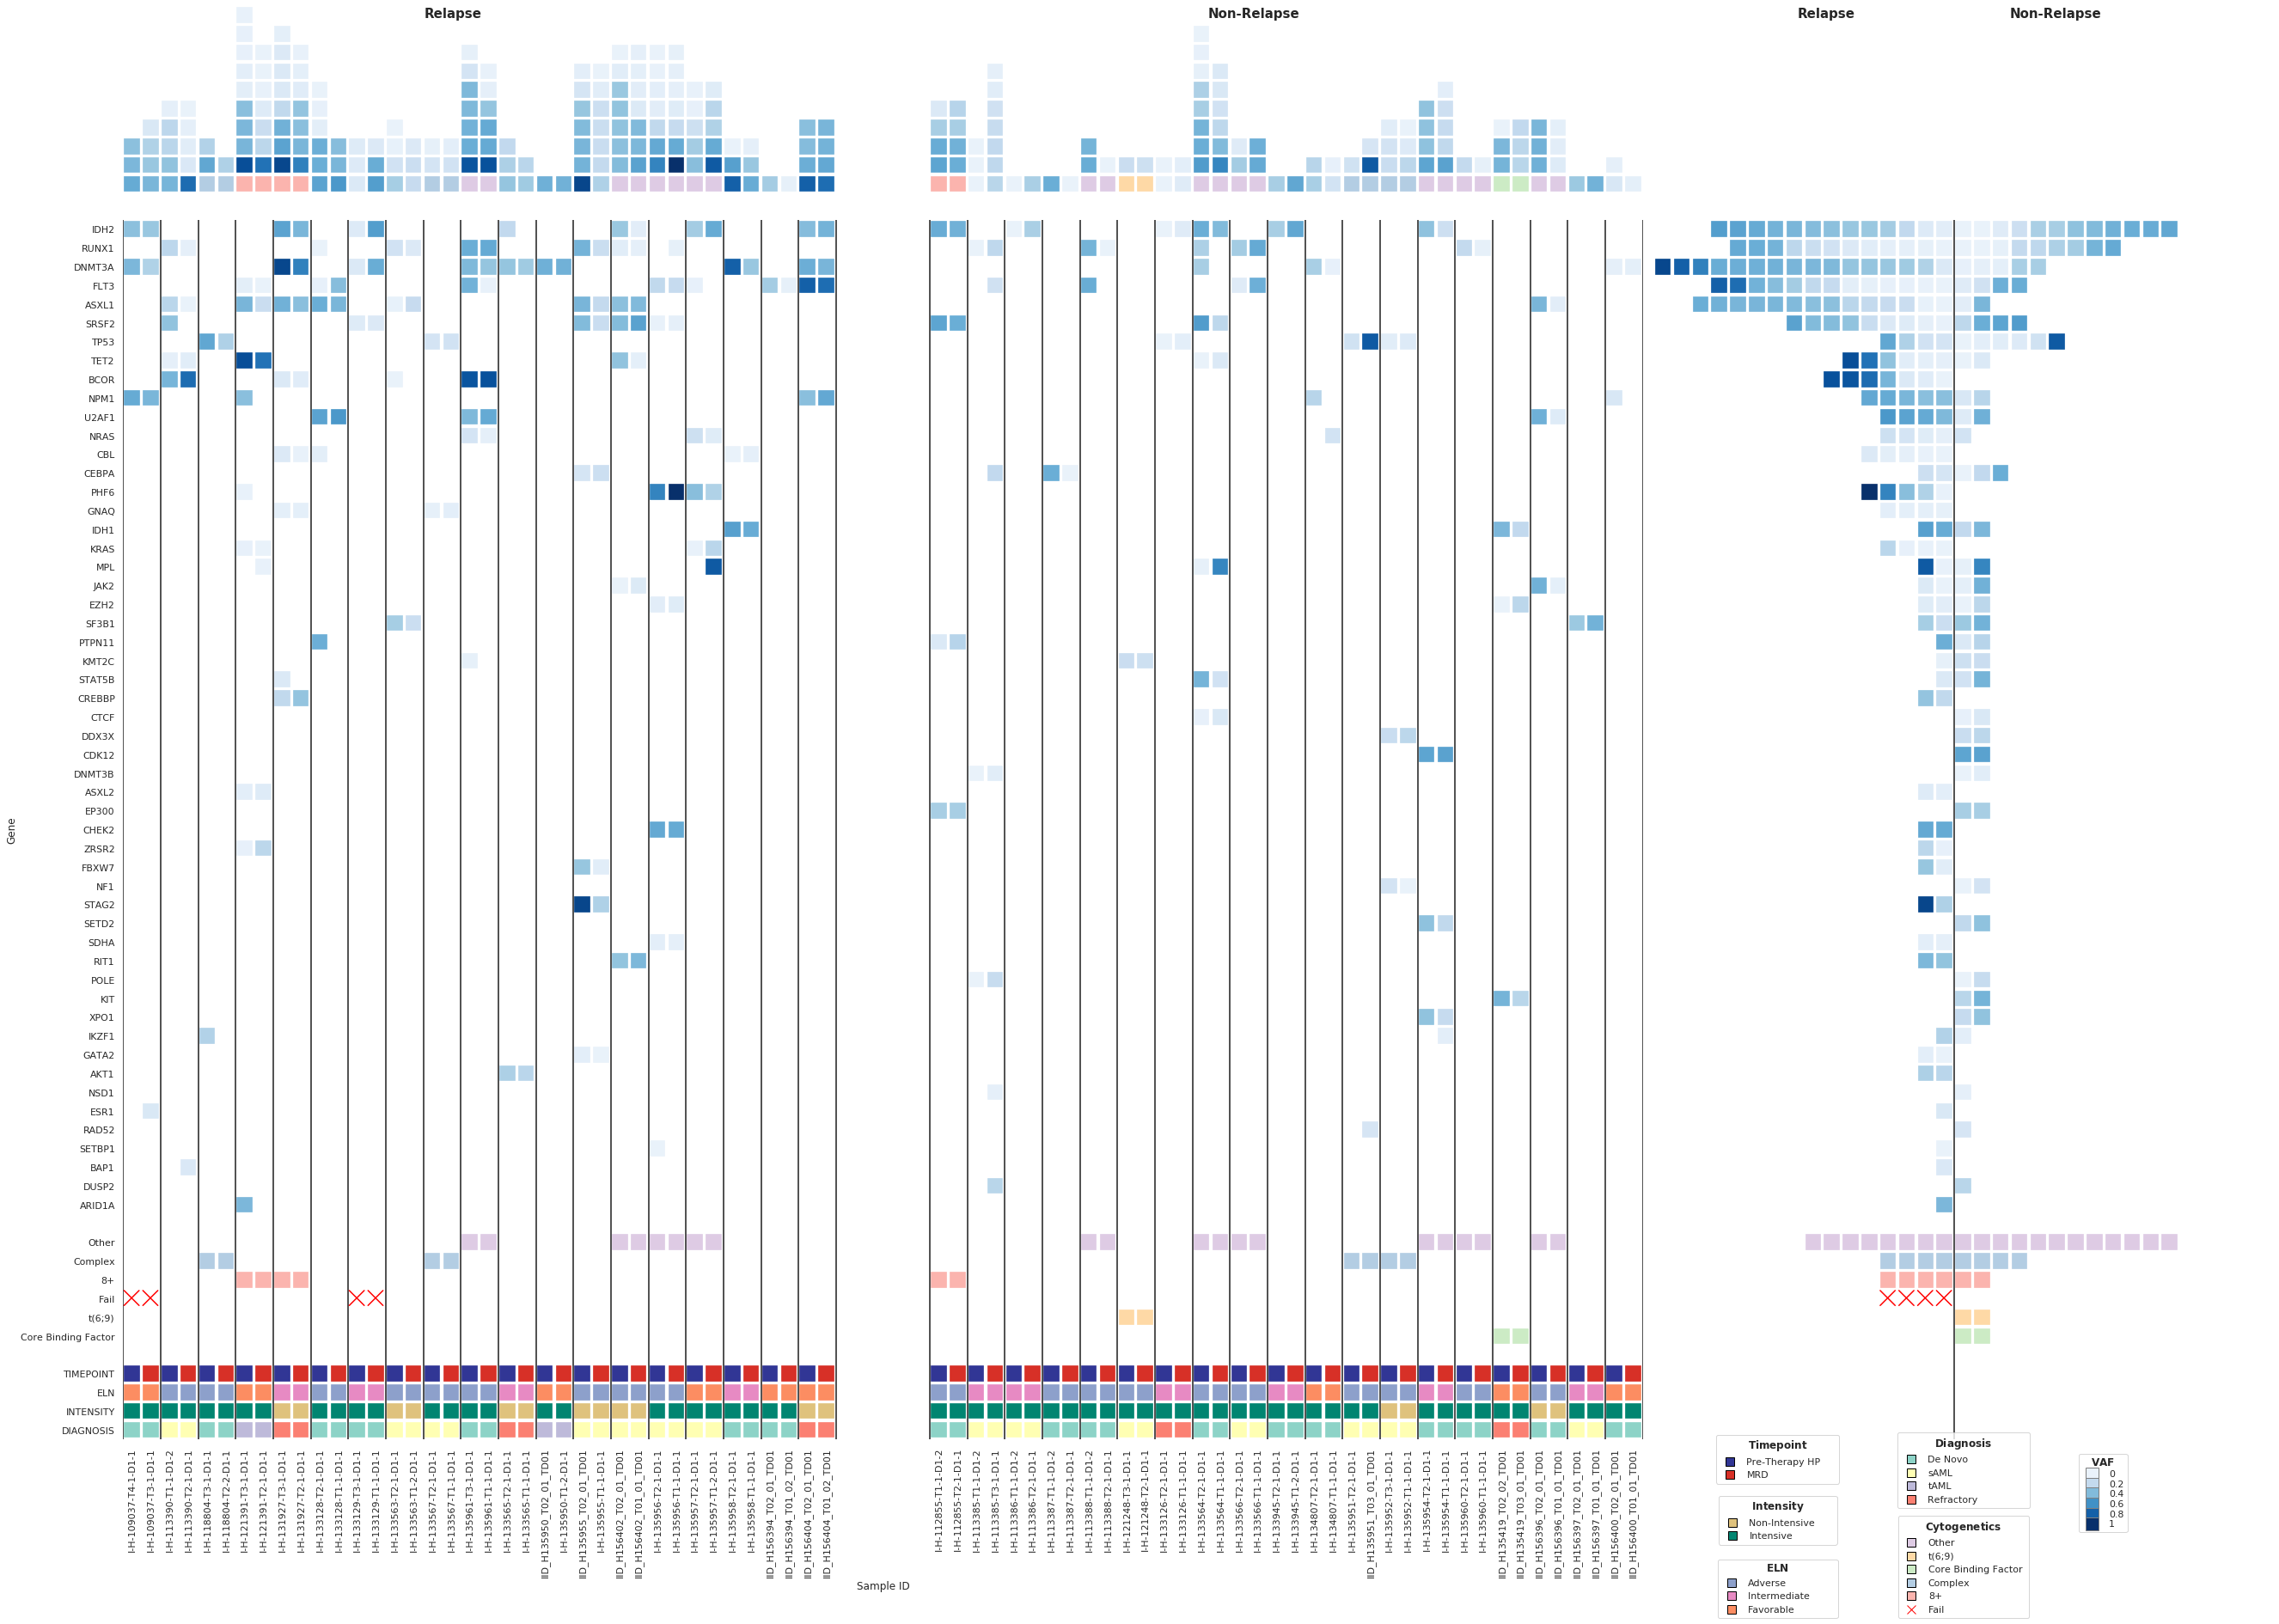

In [35]:
# gridspec_kw = {'width_ratios':[hm_bk.shape[1], side_stack_bk.shape[1]], 'height_ratios':[top_stack.shape[1], top_stack.shape[1]]}


line_spacing = [0]+data.drop_duplicates(subset=['pid', 'sid']).reset_index(drop=True).groupby(['pid'], sort = False)['sid'].count().reset_index()['sid'].cumsum().tolist()

line_spacing = make_line_spacing(data, new_fg)




# if clause to make sure y-indexes are the same
if hm_bk.index.tolist() == hm_fg.index.tolist():

    fig, ((axts0,axts1), (ax,ax2)) = plt.subplots(2,2, figsize=(37,26.25), gridspec_kw = {'width_ratios':[new_bk.shape[1], exploder_bk.shape[1]], \
                                                                                       'height_ratios':[top_stack.shape[0], new_bk.shape[0]]})
    fig.text(0.20, .99, "Relapse", fontsize=15, fontweight='bold', ha='center', va='top')
    fig.text(0.55, .99, "Non-Relapse", fontsize=15, fontweight='bold', ha='center', va='top')
    fig.text(0.80, .99, "Relapse", fontsize=15, fontweight='bold', ha='center', va='top')
    fig.text(0.90, .99, "Non-Relapse", fontsize=15, fontweight='bold', ha='center', va='top')
    
    axts1.set_visible(False)
#     axts1.set_frame_on(False)
    axts1.set_xticklabels([])
    axts1.set_yticklabels([])
    
    hm_ts = sns.heatmap(new_top_stack.fillna(0), \
                     cmap=['white'], \
                     cbar=False, \
                     linewidths=.5, \
                     square=True, \
                     ax=axts0)
#     hm_ts.vlines(line_spacing, *axts0.get_ylim())
    
    for (x,y), val in np.ndenumerate(new_top_stack.replace(intdict_inv)):
        if isinstance(val, float):
            if val > 0:
                axts0.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap.to_rgba(val), edgecolor='white',lw=.3))
        if val in mut_col_dict.keys():
            color = mut_col_dict[val]
            axts0.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=color, edgecolor='white',lw=.3))

            
#     axts0.set_title('Relapse', loc='left', fontdict={'fontsize':25})
#     axts0.set_title('Non-Relapse', loc='right', fontdict={'fontsize':25})
    
    axts0.xaxis.set_visible(False)
    axts0.yaxis.set_visible(False)
    
    
    hm = sns.heatmap(new_bk.reindex(order_of_genes).fillna(0), \
                     cmap=['white'], \
                     cbar=False, \
                     linewidths=.5, \
                     square=True, \
                     ax=ax)
    hm.vlines(make_line_spacing(data, new_fg), *ax.get_ylim())
    
    for (x,y), val in np.ndenumerate(new_fg.reindex(order_of_genes).fillna(0)):
        if isinstance(val, float):
            if val > 0:
                ax.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap.to_rgba(val), edgecolor='white',lw=.3))
        if val in mut_col_dict.keys():
            color = mut_col_dict[val]
            ax.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=color, edgecolor='white',lw=.3))
        elif val == 'Fail':
            ax.add_artist(mlines.Line2D([y+.05, y+.85], [x+.05, x+.85],  color='red'))
            ax.add_artist(mlines.Line2D([y+.85, y+.05], [x+.05, x+.85],  color='red'))


            

            
    yticklabels_list = [t.get_text() for t in hm.get_yticklabels()]
    yticklabels = [t for t in hm.get_yticklabels()] 
    yticklabels = ax.yaxis.get_major_ticks() 
    ylabels = ['SPACER1', 'SPACER2']
    for l in ylabels:
        if l in yticklabels_list:
            i = yticklabels_list.index(l)
            yticklabels[i].label1.set_visible(False)
            
    xticklabels_list = [t.get_text() for t in hm.get_xticklabels()]
    xticklabels = [t for t in hm.get_xticklabels()] 
    xticklabels = ax.xaxis.get_major_ticks() 
    xlabels = ['cspacer1', 'cspacer2', 'cspacer3', 'cspacer4', 'cspacer5']
    for l in xlabels:
        if l in xticklabels_list:
            i = xticklabels_list.index(l)
            xticklabels[i].label1.set_visible(False)
    ax.set_ylabel('Gene')
    ax.set_xlabel('Sample ID')
            

#     divider = make_axes_locatable(ax2)
#     cbar_ax = divider.new_vertical(size="5%", pad=0.5, pack_start=True)
#     fig.add_axes(cbar_ax)
    
#     hm2 = sns.heatmap(new_side_stack_bk.reindex(order_of_genes).fillna(0), \
#                       cmap=['white'], \
#                       linewidths=0, \
#                       linecolor='whitesmoke', \
#                       cbar=False, \
#                       square=True, \
#                       ax=ax2, \
#                       cbar_ax=cbar_ax, cbar_kws={ "orientation": "horizontal" })
    
#     for (x,y), val in np.ndenumerate(new_side_stack.reindex(order_of_genes).fillna(-5)):
# #         print(val)
#         if isinstance(val, float):
#             if 0 <= val <= 1:
#                 ax2.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap.to_rgba(val), edgecolor='white',lw=.3))
#         if val in mut_col_dict.keys():
#             color = mut_col_dict[val]
#             ax2.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=color, edgecolor='white',lw=.3))
#         elif val == 'Fail':
#             ax2.add_artist(mlines.Line2D([y+.05, y+.85], [x+.05, x+.85],  color='red'))
#             ax2.add_artist(mlines.Line2D([y+.85, y+.05], [x+.05, x+.85],  color='red'))
#         ax2.xaxis.set_visible(False)
#         ax2.yaxis.set_visible(False)
            
    explode_l_fg.shape[0]
    hm2 = sns.heatmap(exploder_bk, \
                     cmap=['white'], \
                     cbar=False, \
                     linewidths=.5, \
                     square=True, \
                     ax=ax2)

    hm2.vlines([explode_l_fg.shape[1]], *(ax2.get_ylim()[0]+5, ax2.get_ylim()[1]-5), colors='k')

    for (x,y), val in np.ndenumerate(exploder.replace(intdict_inv)):
        if isinstance(val, float):
            if val > 0:
                ax2.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap.to_rgba(val), edgecolor='white',lw=.3))
        if val in mut_col_dict.keys():
            color = mut_col_dict[val]
            ax2.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=color, edgecolor='white',lw=.3))
        elif val == 'Fail':
            ax2.add_artist(mlines.Line2D([y+.05, y+.85], [x+.05, x+.85],  color='red'))
            ax2.add_artist(mlines.Line2D([y+.85, y+.05], [x+.05, x+.85],  color='red'))
    
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    






    ## legend items
    ## leg1
    pre_therapy_hp = mlines.Line2D([], [], color='#313695', marker='s', linestyle='None',
                              markersize=10, label='Pre-Therapy HP     ', markeredgecolor='black')
    mrd = mlines.Line2D([], [], color='#d73027', marker='s', linestyle='None',
                              markersize=10, label='MRD', markeredgecolor='black')
    ## leg2
    adverse = mlines.Line2D([], [], color='#8da0cb', marker='s', linestyle='None',
                              markersize=10, label='Adverse', markeredgecolor='black')
    intermediate = mlines.Line2D([], [], color='#e78ac3', marker='s', linestyle='None',
                              markersize=10, label='Intermediate        ', markeredgecolor='black')
    favorable = mlines.Line2D([], [], color='#fc8d62', marker='s', linestyle='None',
                              markersize=10, label='Favorable', markeredgecolor='black')
    ## leg3
    non_intensive = mlines.Line2D([], [], color='#dfc27d', marker='s', linestyle='None',
                              markersize=10, label='Non-Intensive      ', markeredgecolor='black')
    intensive = mlines.Line2D([], [], color='#018571', marker='s', linestyle='None',
                              markersize=10, label='Intensive', markeredgecolor='black')
    ## leg4
    de_novo = mlines.Line2D([], [], color='#8dd3c7', marker='s', linestyle='None',
                              markersize=10, label='De Novo', markeredgecolor='black')
    sAML = mlines.Line2D([], [], color='#ffffb3', marker='s', linestyle='None',
                              markersize=10, label='sAML', markeredgecolor='black')
    tAML = mlines.Line2D([], [], color='#bebada', marker='s', linestyle='None',
                              markersize=10, label='tAML', markeredgecolor='black')
    refractory = mlines.Line2D([], [], color='#fb8072', marker='s', linestyle='None',
                              markersize=10, label='Refractory                ', markeredgecolor='black')

    ## leg5
    Other = mlines.Line2D([], [], color='#decbe4', marker='s', linestyle='None',
                              markersize=10, label='Other', markeredgecolor='black')
    t69 = mlines.Line2D([], [], color='#fed9a6', marker='s', linestyle='None',
                              markersize=10, label='t(6;9)', markeredgecolor='black')
    core_binding_factor = mlines.Line2D([], [], color='#ccebc5', marker='s', linestyle='None',
                              markersize=10, label='Core Binding Factor ', markeredgecolor='black')
    Complex = mlines.Line2D([], [], color='#b3cde3', marker='s', linestyle='None',
                              markersize=10, label='Complex', markeredgecolor='black')
    eight_plus = mlines.Line2D([], [], color='#fbb4ae', marker='s', linestyle='None',
                              markersize=10, label='8+', markeredgecolor='black')
    fail = mlines.Line2D([], [], color='red', marker='x', linestyle='None',
                              markersize=10, label='Fail', markeredgecolor='red')
    
    
    ## leg6
    l0 = mlines.Line2D([], [], color=scalarMap.to_rgba(0), marker='s', linestyle='None',
                              markersize=15, label='0', markeredgecolor='gray')
    l2 = mlines.Line2D([], [], color=scalarMap.to_rgba(0.2), marker='s', linestyle='None',
                              markersize=15, label='0.2', markeredgecolor='gray')    
    l4 = mlines.Line2D([], [], color=scalarMap.to_rgba(0.4), marker='s', linestyle='None',
                              markersize=15, label='0.4', markeredgecolor='gray')
    l6 = mlines.Line2D([], [], color=scalarMap.to_rgba(0.6), marker='s', linestyle='None',
                              markersize=15, label='0.6', markeredgecolor='gray')
    l8 = mlines.Line2D([], [], color=scalarMap.to_rgba(0.8), marker='s', linestyle='None',
                              markersize=15, label='0.8', markeredgecolor='gray')
    l10 = mlines.Line2D([], [], color=scalarMap.to_rgba(1.0), marker='s', linestyle='None',
                              markersize=15, label='1', markeredgecolor='gray')



    first_legend = plt.legend(handles=[pre_therapy_hp, \
                                mrd], title=r'$\bf{Timepoint}$' ,loc='lower center', bbox_to_anchor=(.2,-0.04), ncol=1, facecolor='white')
    second_legend = plt.legend(handles=[adverse, intermediate, \
                                favorable], title=r'$\bf{ELN}$' ,loc='lower center', bbox_to_anchor=(.2,-0.15), ncol=1, facecolor='white')
    third_legend = plt.legend(handles=[non_intensive, intensive], title=r'$\bf{Intensity}$' ,loc='lower center', bbox_to_anchor=(.2,-0.09), ncol=1, facecolor='white')
    fourth_legend = plt.legend(handles=[de_novo, sAML, tAML, refractory], title=r'$\bf{Diagnosis}$' ,loc='lower center', bbox_to_anchor=(.5,-0.06), ncol=1, facecolor='white')
    fith_legend = plt.legend(handles=[l0, l2, l4, l6, l8, l10], title=r'$\bf{VAF}$' ,loc='lower center', bbox_to_anchor=(.725,-0.08), ncol=1, facecolor='white', labelspacing=.15)
    
    ax2 = plt.gca().add_artist(first_legend)
    ax2 = plt.gca().add_artist(second_legend)
    ax2 = plt.gca().add_artist(third_legend)
    ax2 = plt.gca().add_artist(fourth_legend)
    ax2 = plt.gca().add_artist(fith_legend)
    
    plt.legend(handles=[Other, \
                            t69, \
                            core_binding_factor, \
                            Complex, \
                            eight_plus,fail], title=r'$\bf{Cytogenetics}$' ,loc='lower center', bbox_to_anchor=(.5,-0.15), ncol=1, facecolor='white')
    

    fig.subplots_adjust(wspace=0.01, hspace=0)
    plt.tight_layout()
#     plt.savefig('/work/isabl/home/mccartej/p142/p142_mrd_oncoplot_split_leg.v3.png', dpi=300)
else:
    print('Dataframe INDEX orders are not the same')

In [18]:
import bokeh.palettes as bp
bp.all_palettes['Set3'][4]

('#8dd3c7', '#ffffb3', '#bebada', '#fb8072')

In [19]:
dict(zip(list(data['DIAGNOSIS'].unique()), bp.all_palettes['Set3'][4]))

{'de novo': '#8dd3c7',
 'sAML': '#ffffb3',
 'tAML': '#bebada',
 'refractory': '#fb8072'}

In [20]:
bp.all_palettes['BrBG'][4]

('#018571', '#80cdc1', '#dfc27d', '#a6611a')

In [21]:
bp.all_palettes['Set2'][4]

('#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3')

In [22]:
bp.all_palettes['RdYlBu'][10]

('#313695',
 '#4575b4',
 '#74add1',
 '#abd9e9',
 '#e0f3f8',
 '#fee090',
 '#fdae61',
 '#f46d43',
 '#d73027',
 '#a50026')

In [23]:
bp.all_palettes['Pastel1'][5]

('#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6')

In [24]:
'8+':'tab:orange', \
                'Complex':'tab:green', \
                'Core Binding Factor':'tab:red', \
                'Normal':'white', \
                'Other':'tab:olive', \
               't(6;9)':'tab:gray',

SyntaxError: invalid syntax (<ipython-input-24-968cf0ae03f5>, line 1)

# TINDER:

In [384]:
mut_col_dict = {'Adverse':'#8da0cb', \
                'Intermediate':'#e78ac3', \
                'Favorable':'#fc8d62',\
                'Matched':'#8DA0CB', \
                'Unmatched':'#E78AC3', \
                'Relapse HP':'orange', \
                '8+':'#fbb4ae', \
                'Complex':'#b3cde3', \
                'Core Binding Factor':'#ccebc5', \
                'Normal':'white', \
                'Other':'#decbe4', \
               't(6;9)':'#fed9a6', 'Intensive':'#018571', 'Non-Intensive':'#dfc27d', 'de novo': '#8dd3c7','sAML': '#ffffb3','tAML': '#bebada','refractory': '#fb8072'}

- BTG Purity:

In [385]:
BTG_directories_doc='/home/gutierj2/uk_all/321project_BATTENBERG_directories.list'
BTG_directories=!cat {BTG_directories_doc}

sample_list=[]
purity_list=[]

for n in BTG_directories:
    route=n+'/*_rho_and_psi.txt'
    path=!ls {route}
    
    sample=path[0].split('/')[8].split('_rho')[0]
    if(sample=='tmpBattenberg'):
        sample=path[0].split('/')[9].split('_rho')[0]
    
    purity_file=pd.read_csv(path[0],sep='\t')
    for index,row in purity_file.iterrows():
        if(index=='FRAC_GENOME'):
            sample_list.append(sample)
            purity_list.append(row['rho'])
 
table_purity=pd.DataFrame()
table_purity['Sample']=sample_list
table_purity['Sample_x']=sample_list
table_purity['Purity']=purity_list


In [388]:
table_purity.sort_values(by=['Sample'])

,Sample,Sample_x,Purity
0,IID_H158604_T01_01_WG01,IID_H158604_T01_01_WG01,0.910000
3,IID_H158605_T01_01_WG01,IID_H158605_T01_01_WG01,0.780000
2,IID_H158606_T01_01_WG01,IID_H158606_T01_01_WG01,0.850000
1,IID_H158607_T01_01_WG01,IID_H158607_T01_01_WG01,0.800000
4,IID_H158608_T01_01_WG01,IID_H158608_T01_01_WG01,0.921840
5,IID_H158609_T01_01_WG01,IID_H158609_T01_01_WG01,0.504500
7,IID_H158610_T01_01_WG01,IID_H158610_T01_01_WG01,0.893000
8,IID_H158611_T01_01_WG01,IID_H158611_T01_01_WG01,0.953000
14,IID_H158612_T01_01_WG01,IID_H158612_T01_01_WG01,0.344400
15,IID_H158613_T01_01_WG01,IID_H158613_T01_01_WG01,0.848320


In [389]:
triple_arms=pd.read_csv('/work/isabl/home/gutierj2/uk_all/notebooks/clinic/ALL/1-HEATMAP_I_example_TRIPLE_MERGE_ARMs_SUPER.tsv',sep='\t')
triple_arms.head()

,Unnamed: 0,index_x,chr_seg_x,start_seg_x,end_seg_x,CNV_x,Cells,Sample_x,Detection_x,chr_arm_x,start_arm_x,end_arm_x,name_arm_x,keys_x,keys_arms,index_y,chr_seg_y,start_seg_y,end_seg_y,CNV_y,brass_PS,brass_RC,Sample_y,Detection_y,chr_arm_y,start_arm_y,end_arm_y,name_arm_y,keys_y,Detection_z,Size_z
0,0,13.0,13.0,25760508.0,114998761.0,3.0,1.000000,IID_H158669_T01_01_WG01,Non Detected,13q,19000000.0,115169878.0,13_13q,13_25760508_114998761_IID_H158669_T01_01_WG01,13q_IID_H158669_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,89238253.0
1,1,6.0,6.0,5874537.0,170921794.0,3.0,0.363969,IID_H158613_T01_01_WG01,Non Detected,6p,0.0,58830166.0,6_6p,6_5874537_170921794_IID_H158613_T01_01_WG01,6p_IID_H158613_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,165047257.0
2,2,6.0,6.0,5874537.0,170921794.0,3.0,0.363969,IID_H158613_T01_01_WG01,Non Detected,6q,61830166.0,171115067.0,6_6q,6_5874537_170921794_IID_H158613_T01_01_WG01,6q_IID_H158613_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,165047257.0
3,3,7.0,7.0,61058365.0,159122682.0,3.0,1.000000,IID_H158666_T01_01_WG01,Non Detected,7q,61054331.0,159138663.0,7_7q,7_61058365_159122682_IID_H158666_T01_01_WG01,7q_IID_H158666_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,98064317.0
4,4,5.0,5.0,850203.0,46387657.0,3.0,1.000000,IID_H158666_T01_01_WG01,Non Detected,5p,0.0,46405641.0,5_5p,5_850203_46387657_IID_H158666_T01_01_WG01,5p_IID_H158666_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,45537454.0


In [390]:
table_purity['Sample_x']=table_purity['Sample']
triple_arms=pd.merge(triple_arms,table_purity,on='Sample_x')
triple_arms.head()

,Unnamed: 0,index_x,chr_seg_x,start_seg_x,end_seg_x,CNV_x,Cells,Sample_x,Detection_x,chr_arm_x,start_arm_x,end_arm_x,name_arm_x,keys_x,keys_arms,index_y,chr_seg_y,start_seg_y,end_seg_y,CNV_y,brass_PS,brass_RC,Sample_y,Detection_y,chr_arm_y,start_arm_y,end_arm_y,name_arm_y,keys_y,Detection_z,Size_z,Sample,Purity
0,0,13.0,13.0,25760508.0,114998761.0,3.0,1.000000,IID_H158669_T01_01_WG01,Non Detected,13q,19000000.0,115169878.0,13_13q,13_25760508_114998761_IID_H158669_T01_01_WG01,13q_IID_H158669_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,89238253.0,IID_H158669_T01_01_WG01,0.218522
1,1,6.0,6.0,5874537.0,170921794.0,3.0,0.363969,IID_H158613_T01_01_WG01,Non Detected,6p,0.0,58830166.0,6_6p,6_5874537_170921794_IID_H158613_T01_01_WG01,6p_IID_H158613_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,165047257.0,IID_H158613_T01_01_WG01,0.848320
2,2,6.0,6.0,5874537.0,170921794.0,3.0,0.363969,IID_H158613_T01_01_WG01,Non Detected,6q,61830166.0,171115067.0,6_6q,6_5874537_170921794_IID_H158613_T01_01_WG01,6q_IID_H158613_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,165047257.0,IID_H158613_T01_01_WG01,0.848320
3,33,1.0,1.0,111991845.0,249191132.0,4.0,1.000000,IID_H158613_T01_01_WG01,Detected,1q,124535434.0,249250621.0,1_1q,1_111991845_249191132_IID_H158613_T01_01_WG01,1q_IID_H158613_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Detected,137199287.0,IID_H158613_T01_01_WG01,0.848320
4,34,2.0,2.0,37259.0,85916487.0,2.0,1.000000,IID_H158613_T01_01_WG01,Detected,2p,0.0,92326171.0,2_2p,2_37259_85916487_IID_H158613_T01_01_WG01,2p_IID_H158613_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Detected,85879228.0,IID_H158613_T01_01_WG01,0.848320


In [391]:
triple_arms['CCF']=triple_arms['Purity']*triple_arms['Cells']

In [392]:
def cnv_triple (row):
    if (row['CNV_x']>2):
        return 'GAINs'
    if (row['CNV_x']<2):
        return 'LOSSs'
    if (row['CNV_x']==2):
        return 'CNLOHs'
    
triple_arms['Type']=triple_arms.apply(lambda row: cnv_triple(row), axis=1)

- Tinder Purity:

In [393]:
tinder_purity=pd.read_csv('/work/isabl/home/gutierj2/uk_all/purity/tinder_purity.tsv',sep='\t')
tinder_purity

,Sample,Purity
0,IID_H158604_T01_01_WG01,1.000000
1,IID_H158605_T01_01_WG01,1.000000
2,IID_H158606_T01_01_WG01,1.000000
3,IID_H158607_T01_01_WG01,1.000000
4,IID_H158608_T01_01_WG01,0.918222
5,IID_H158609_T01_01_WG01,0.467929
6,IID_H158610_T01_01_WG01,1.000000
7,IID_H158611_T01_01_WG01,0.436593
8,IID_H158612_T01_01_WG01,0.246368
9,IID_H158613_T01_01_WG01,0.924262


In [394]:
tinder_arms=pd.read_csv('/work/isabl/home/gutierj2/uk_all/notebooks/clinic/ALL/1-HEATMAP_I_example_TINder_MERGE_ARMs_SUPER.tsv',sep='\t')
tinder_arms.head()

,Unnamed: 0,index_x,chr_seg_x,start_seg_x,end_seg_x,CNV_x,Cells,Sample_x,Detection_x,chr_arm_x,start_arm_x,end_arm_x,name_arm_x,keys_x,keys_arms,index_y,chr_seg_y,start_seg_y,end_seg_y,CNV_y,brass_PS,brass_RC,Sample_y,Detection_y,chr_arm_y,start_arm_y,end_arm_y,name_arm_y,keys_y,Detection_z,Size_z
0,0,6.0,6.0,210000.0,170910001.0,3.0,0.34,IID_H158612_T01_01_WG01,Non Detected,6p,0.0,58830166.0,6_6p,6_210000_170910001_IID_H158612_T01_01_WG01,6p_IID_H158612_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,170700001.0
1,1,6.0,6.0,210000.0,170910001.0,3.0,0.34,IID_H158612_T01_01_WG01,Non Detected,6q,61830166.0,171115067.0,6_6q,6_210000_170910001_IID_H158612_T01_01_WG01,6q_IID_H158612_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,170700001.0
2,2,13.0,13.0,28866212.0,115109878.0,1.0,0.81,IID_H158613_T01_01_WG01,Non Detected,13q,19000000.0,115169878.0,13_13q,13_28866212_115109878_IID_H158613_T01_01_WG01,13q_IID_H158613_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,86243666.0
3,3,9.0,9.0,195000.0,38774194.0,1.0,0.91,IID_H158637_T01_01_WG01,Non Detected,9p,0.0,47367679.0,9_9p,9_195000_38774194_IID_H158637_T01_01_WG01,9p_IID_H158637_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,38579194.0
4,4,20.0,20.0,60000.0,26159211.0,3.0,0.91,IID_H158637_T01_01_WG01,Non Detected,20p,0.0,26369569.0,20_20p,20_60000_26159211_IID_H158637_T01_01_WG01,20p_IID_H158637_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,26099211.0


In [395]:
tinder_purity['Sample_x']=tinder_purity['Sample']
tinder_arms=pd.merge(tinder_arms,tinder_purity,on='Sample_x')
tinder_arms.head()

,Unnamed: 0,index_x,chr_seg_x,start_seg_x,end_seg_x,CNV_x,Cells,Sample_x,Detection_x,chr_arm_x,start_arm_x,end_arm_x,name_arm_x,keys_x,keys_arms,index_y,chr_seg_y,start_seg_y,end_seg_y,CNV_y,brass_PS,brass_RC,Sample_y,Detection_y,chr_arm_y,start_arm_y,end_arm_y,name_arm_y,keys_y,Detection_z,Size_z,Sample,Purity
0,0,6.0,6.0,210000.0,170910001.0,3.0,0.34,IID_H158612_T01_01_WG01,Non Detected,6p,0.0,58830166.0,6_6p,6_210000_170910001_IID_H158612_T01_01_WG01,6p_IID_H158612_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,170700001.0,IID_H158612_T01_01_WG01,0.246368
1,1,6.0,6.0,210000.0,170910001.0,3.0,0.34,IID_H158612_T01_01_WG01,Non Detected,6q,61830166.0,171115067.0,6_6q,6_210000_170910001_IID_H158612_T01_01_WG01,6q_IID_H158612_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Detected,170700001.0,IID_H158612_T01_01_WG01,0.246368
2,18,2.0,2.0,10000.0,243015001.0,3.0,0.34,IID_H158612_T01_01_WG01,Detected,2p,0.0,92326171.0,2_2p,2_10000_243015001_IID_H158612_T01_01_WG01,2p_IID_H158612_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Detected,243005001.0,IID_H158612_T01_01_WG01,0.246368
3,19,2.0,2.0,10000.0,243015001.0,3.0,0.34,IID_H158612_T01_01_WG01,Detected,2q,95326171.0,243199373.0,2_2q,2_10000_243015001_IID_H158612_T01_01_WG01,2q_IID_H158612_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Detected,243005001.0,IID_H158612_T01_01_WG01,0.246368
4,20,4.0,4.0,75000.0,190845001.0,3.0,0.34,IID_H158612_T01_01_WG01,Detected,4p,0.0,49660117.0,4_4p,4_75000_190845001_IID_H158612_T01_01_WG01,4p_IID_H158612_T01_01_WG01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Detected,190770001.0,IID_H158612_T01_01_WG01,0.246368


In [396]:
tinder_arms['CCF']=tinder_arms['Purity']*tinder_arms['Cells']

In [397]:
def cnv_tinder (row):
    if (row['CNV_x']>2):
        return 'GAINs'
    if (row['CNV_x']<2):
        return 'LOSSs'
    if (row['CNV_x']==2):
        return 'CNLOHs'
    
tinder_arms['Type']=tinder_arms.apply(lambda row: cnv_tinder(row), axis=1)

### Read in data TRIPLE/TINDER

In [398]:
#triple_arms=pd.read_csv('/work/isabl/home/gutierj2/uk_all/notebooks/clinic/ALL/1-HEATMAP_I_example_TRIPLE_MERGE_ARMs_SUPER.tsv',sep='\t')
triple_arms_onco=triple_arms[['Sample_x','name_arm_x','CCF','Type']]
triple_arms_onco.columns=['Sample','Arm','CCF','Type']
patients=triple_arms_onco["Sample"].str.split("_T01", expand = True)
triple_arms_onco['Patient']=patients[0]
triple_arms_onco=triple_arms_onco[['Patient','Sample','Arm','CCF','Type']]
triple_arms_onco['Pipeline']='Matched'

triple_arms_onco = triple_arms_onco[triple_arms_onco['Sample'].notna()]

triple_arms_onco.head()

/juno/work/isabl/opt/python/.virtualenvs/users/gutierj2/default_python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Patient,Sample,Arm,CCF,Type,Pipeline
0,IID_H158669,IID_H158669_T01_01_WG01,13_13q,0.218522,GAINs,Matched
1,IID_H158613,IID_H158613_T01_01_WG01,6_6p,0.308763,GAINs,Matched
2,IID_H158613,IID_H158613_T01_01_WG01,6_6q,0.308763,GAINs,Matched
3,IID_H158613,IID_H158613_T01_01_WG01,1_1q,0.848320,GAINs,Matched
4,IID_H158613,IID_H158613_T01_01_WG01,2_2p,0.848320,CNLOHs,Matched


In [399]:
#tinder_arms=pd.read_csv('/work/isabl/home/gutierj2/uk_all/notebooks/clinic/ALL/1-HEATMAP_I_example_TINder_MERGE_ARMs_SUPER.tsv',sep='\t')
tinder_arms_onco=tinder_arms[['Sample_x','name_arm_x','CCF','Type']]
tinder_arms_onco.columns=['Sample','Arm','CCF','Type']
patients=tinder_arms_onco["Sample"].str.split("_T01", expand = True)
tinder_arms_onco['Patient']=patients[0]
tinder_arms_onco=tinder_arms_onco[['Patient','Sample','Arm','CCF','Type']]
tinder_arms_onco['Pipeline']='Unmatched'

tinder_arms_onco = tinder_arms_onco[tinder_arms_onco['Sample'].notna()]

tinder_arms_onco.head()

/juno/work/isabl/opt/python/.virtualenvs/users/gutierj2/default_python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Patient,Sample,Arm,CCF,Type,Pipeline
0,IID_H158612,IID_H158612_T01_01_WG01,6_6p,0.083765,GAINs,Unmatched
1,IID_H158612,IID_H158612_T01_01_WG01,6_6q,0.083765,GAINs,Unmatched
2,IID_H158612,IID_H158612_T01_01_WG01,2_2p,0.083765,GAINs,Unmatched
3,IID_H158612,IID_H158612_T01_01_WG01,2_2q,0.083765,GAINs,Unmatched
4,IID_H158612,IID_H158612_T01_01_WG01,4_4p,0.083765,GAINs,Unmatched


In [400]:
arms_onco = pd.concat([triple_arms_onco,tinder_arms_onco])

- Joseph:

In [401]:
arms_onco['Counts']='to_count'
dataT = arms_onco.groupby(['Patient', 'Sample', 'Pipeline'])['Counts'].count().reset_index()
dataT = dataT.pivot_table(columns='Pipeline', index='Patient', values='Counts')
dataT['sum'] = dataT.sum(axis=1)
pid_order = dataT.reset_index().sort_values(by=['sum', 'Patient']).set_index('Patient').index.tolist()

sorterIndex = dict(zip(pid_order,range(len(pid_order))))
arms_onco['rank'] = arms_onco['Patient'].map(sorterIndex)

arms_onco.loc[arms_onco['Pipeline']=='Matched', 'trank'] = 1
arms_onco.loc[arms_onco['Pipeline']=='Unmatched', 'trank'] = 2

In [402]:
dataT

Pipeline,Matched,Unmatched,sum
Patient,,,
IID_H158608,1.0,1.0,2.0
IID_H158609,4.0,5.0,9.0
IID_H158610,1.0,1.0,2.0
IID_H158612,18.0,17.0,35.0
IID_H158613,32.0,30.0,62.0
IID_H158615,2.0,1.0,3.0
IID_H158616,7.0,NaN,7.0
IID_H158617,8.0,8.0,16.0
IID_H158618,2.0,2.0,4.0


In [403]:
sorterIndex

{'IID_H158633': 0,
 'IID_H158635': 1,
 'IID_H158640': 2,
 'IID_H158663': 3,
 'IID_H158667': 4,
 'IID_H158608': 5,
 'IID_H158610': 6,
 'IID_H158623': 7,
 'IID_H158625': 8,
 'IID_H158629': 9,
 'IID_H158639': 10,
 'IID_H158669': 11,
 'IID_H158615': 12,
 'IID_H158620': 13,
 'IID_H158627': 14,
 'IID_H158641': 15,
 'IID_H158643': 16,
 'IID_H158662': 17,
 'IID_H158618': 18,
 'IID_H158626': 19,
 'IID_H158628': 20,
 'IID_H158638': 21,
 'IID_H158664': 22,
 'IID_H158671': 23,
 'IID_H158637': 24,
 'IID_H158666': 25,
 'IID_H158616': 26,
 'IID_H158632': 27,
 'IID_H158609': 28,
 'IID_H158631': 29,
 'IID_H158665': 30,
 'IID_H158617': 31,
 'IID_H158670': 32,
 'IID_H158612': 33,
 'IID_H158613': 34,
 'IID_H158644': 35}

In [404]:
arms_onco = arms_onco.sort_values(by=['rank', 'trank'],ascending=False).reset_index(drop=True)
arms_onco

,Patient,Sample,Arm,CCF,Type,Pipeline,Counts,rank,trank
0,IID_H158644,IID_H158644_T01_01_WG01,20_20p,0.395646,CNLOHs,Unmatched,to_count,35,2.0
1,IID_H158644,IID_H158644_T01_01_WG01,20_20q,0.395646,CNLOHs,Unmatched,to_count,35,2.0
2,IID_H158644,IID_H158644_T01_01_WG01,1_1p,0.395646,CNLOHs,Unmatched,to_count,35,2.0
3,IID_H158644,IID_H158644_T01_01_WG01,1_1q,0.395646,CNLOHs,Unmatched,to_count,35,2.0
4,IID_H158644,IID_H158644_T01_01_WG01,2_2p,0.395646,CNLOHs,Unmatched,to_count,35,2.0
5,IID_H158644,IID_H158644_T01_01_WG01,2_2q,0.395646,CNLOHs,Unmatched,to_count,35,2.0
6,IID_H158644,IID_H158644_T01_01_WG01,3_3p,0.395646,CNLOHs,Unmatched,to_count,35,2.0
7,IID_H158644,IID_H158644_T01_01_WG01,3_3q,0.395646,CNLOHs,Unmatched,to_count,35,2.0
8,IID_H158644,IID_H158644_T01_01_WG01,4_4p,0.395646,CNLOHs,Unmatched,to_count,35,2.0
9,IID_H158644,IID_H158644_T01_01_WG01,4_4q,0.395646,CNLOHs,Unmatched,to_count,35,2.0


In [405]:
arms_onco['Sample_Pipeline']=arms_onco['Sample']+'_'+arms_onco['Pipeline']
arms_onco.head(20)

,Patient,Sample,Arm,CCF,Type,Pipeline,Counts,rank,trank,Sample_Pipeline
0,IID_H158644,IID_H158644_T01_01_WG01,20_20p,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
1,IID_H158644,IID_H158644_T01_01_WG01,20_20q,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
2,IID_H158644,IID_H158644_T01_01_WG01,1_1p,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
3,IID_H158644,IID_H158644_T01_01_WG01,1_1q,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
4,IID_H158644,IID_H158644_T01_01_WG01,2_2p,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
5,IID_H158644,IID_H158644_T01_01_WG01,2_2q,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
6,IID_H158644,IID_H158644_T01_01_WG01,3_3p,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
7,IID_H158644,IID_H158644_T01_01_WG01,3_3q,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
8,IID_H158644,IID_H158644_T01_01_WG01,4_4p,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
9,IID_H158644,IID_H158644_T01_01_WG01,4_4q,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched


In [406]:
samples = arms_onco['Sample'].unique()

dict_samples={}
for sample in samples:
    if not sample in dict_samples:
        sample_match=sample+'_Matched'
        sample_unmatch=sample+'_unMatched'
        dict_samples[sample_match]={}
        dict_samples[sample_unmatch]={}
for keys in dict_samples:
    print(keys)

IID_H158644_T01_01_WG01_Matched
IID_H158644_T01_01_WG01_unMatched
IID_H158613_T01_01_WG01_Matched
IID_H158613_T01_01_WG01_unMatched
IID_H158612_T01_01_WG01_Matched
IID_H158612_T01_01_WG01_unMatched
IID_H158670_T01_01_WG01_Matched
IID_H158670_T01_01_WG01_unMatched
IID_H158617_T01_01_WG01_Matched
IID_H158617_T01_01_WG01_unMatched
IID_H158665_T01_01_WG01_Matched
IID_H158665_T01_01_WG01_unMatched
IID_H158631_T01_01_WG01_Matched
IID_H158631_T01_01_WG01_unMatched
IID_H158609_T01_01_WG01_Matched
IID_H158609_T01_01_WG01_unMatched
IID_H158632_T01_01_WG01_Matched
IID_H158632_T01_01_WG01_unMatched
IID_H158616_T01_01_WG01_Matched
IID_H158616_T01_01_WG01_unMatched
IID_H158666_T01_01_WG01_Matched
IID_H158666_T01_01_WG01_unMatched
IID_H158637_T01_01_WG01_Matched
IID_H158637_T01_01_WG01_unMatched
IID_H158671_T01_01_WG01_Matched
IID_H158671_T01_01_WG01_unMatched
IID_H158664_T01_01_WG01_Matched
IID_H158664_T01_01_WG01_unMatched
IID_H158638_T01_01_WG01_Matched
IID_H158638_T01_01_WG01_unMatched
IID_H15862

### Main functions to subset data, generate Heatmap Dataframes and gene ordering

In [407]:
def subset_data(df, disease_list=False, sample_list=False):
    if sample_list:
        df = df[df['Sample'].isin(sample_list)]
    if disease_list:
        df = df[df['disease_short'].isin(disease_list)]
    return df


def heatmap_background(df):
    samples = df['Sample_Pipeline'].unique()
    genes = df['Arm'].unique()
    genes = [gene for gene in genes if gene != '-']
    
    bk_df = pd.DataFrame(columns=samples, index=genes).fillna(0)
    
    return bk_df


def heatmap_background2(df):
    samples = df['Sample'].unique()
    
    dict_samples={}
    for sample in samples:
        if not sample in dict_samples:
            sample_match=sample+'_Matched'
            sample_unmatch=sample+'_Unmatched'
            dict_samples[sample_match]={}
            dict_samples[sample_unmatch]={}
    
    samples=[]
    for keys in dict_samples:
        samples.append(keys)
    
    genes = df['Arm'].unique()
    genes = [gene for gene in genes if gene != '-']
    
    bk_df = pd.DataFrame(columns=samples, index=genes).fillna(0)
    
    return bk_df
 
    
def heatmap_foreground(df, index, column ,columns_list):
    df = df.pivot_table(index='Arm', \
                        columns='Sample_Pipeline', \
                        values=column, \
                        aggfunc='first')
    
    df = df[df.index.isin(index)]
    df = df.reindex(index)
    df = df[columns_list]
    
    return df

   
def make_side_stacker_bk(side_stack_df, index):
    index = side_stack_df.index.tolist()
    columns = side_stack_df.columns.tolist()
    
    bk_df = pd.DataFrame(columns=columns, index=index).fillna(1).applymap(lambda x: (x/x))
    bk_df = bk_df.reindex(index)
    return bk_df


def make_side_stacker(foreground_df, index):
#     stacker = foreground_df.replace(intdict).unstack().reset_index()
    stacker = foreground_df.unstack().reset_index()
    
    stacker = stacker[stacker[0]>0]
    
    stacker[0] = stacker[0].astype(str)
    stacker.columns = ['level_0', 'level_1', 0]
    
    order_of_genes =list(stacker.groupby('level_1')[0].count().sort_values(ascending=False).index)
    
    
    grouper_index = stacker.groupby('level_1')[0].agg(lambda x: ','.join((x))).reset_index()[['level_1']]
    
    grouper_columns = stacker.groupby('level_1')[0].agg(lambda x: ','.join((x))).reset_index()[0].str.split(',', expand=True)

    stackermerge = pd.concat([grouper_index, grouper_columns], ignore_index=True, axis=1).set_index(0).reindex(index)

    return stackermerge, order_of_genes


def demo_frame(df, column, columns_list):
    
    data = {'Sample_Pipeline':df['Sample_Pipeline'].tolist(), \
            column:df[column].tolist() }
    
    df = pd.DataFrame(data)
    df = df.pivot_table(columns='Sample_Pipeline', \
                        values=column, aggfunc='first')
    
    
    df = df[columns_list]

    return df


def make_top_stacker(foreground_df):
    
    top_stack = foreground_df.replace(0, None)\
    .apply(lambda x: x.sort_values(ascending=False).values)\
    .reindex(index=hm_fg.index[::-1])\
    .dropna(axis = 0, how = 'all').reset_index(drop=True)

    return top_stack


def make_cyto_df(df, columns_list):
    
    cyto = data.pivot_table(index='CG_red', columns='Sample', values='trank').drop('Normal')
    
    cyto = cyto[columns_list]
    
    for idx in cyto.index:
        cyto.loc[idx] = cyto.loc[idx].apply(lambda x: idx if x/x==1 else np.nan)
    
    return cyto


def oppstack(df, order_of_genes, relapse = True):
    df_sorter = df.replace(intdict).reindex(order_of_genes).drop(['ELN', 'TIMEPOINT', 'INTENSITY', 'SPACER2', 'DIAGNOSIS']).replace(0, np.nan)
    a = df_sorter.values

    a.sort(axis=1)

    if relapse:
        a = a[:, ::-1]

    fg = pd.DataFrame(a, df_sorter.index, df_sorter.columns).dropna(how='all', axis=1).fillna(0)
#     fg = fg.iloc[:, ::-1]
    bk = fg.applymap(lambda x: (x+1)/(x+1))
    
    for i in [1,2,3,4,5]:
        fg.loc[fg.shape[0]] = np.nan
        bk.loc[bk.shape[0]] = np.nan
        
    fg = fg.fillna(0)
    bk = bk.fillna(0)
    
    return fg, bk


def make_line_spacing(df1, df2):
    merge = pd.merge(df1[['Patient', 'Sample_Pipeline']],pd.DataFrame(df2.columns), on='Sample_Pipeline', how='outer').drop_duplicates().reset_index(drop=True).fillna('cspace')
    merge['val'] = 1
    merge_pivot = merge.pivot_table(columns='Sample_Pipeline', values='val', index='Patient')
    merge_pivot_reorder = merge_pivot[col_order]
    
    
    merge_pivot_reorder = merge_pivot_reorder.unstack().reset_index()
    
    merge_pivot_reorder = merge_pivot_reorder[merge_pivot_reorder[0]==1]
    

    
    linestacker = [0]+merge_pivot_reorder.drop_duplicates(subset=['Patient', 'Sample_Pipeline']).reset_index(drop=True).groupby(['Patient'], sort = False)['Sample_Pipeline'].count().reset_index()['Sample_Pipeline'].cumsum().tolist()
    
    return linestacker

### Make main dataframes and side stacks

In [408]:
arms_onco.head(20)

,Patient,Sample,Arm,CCF,Type,Pipeline,Counts,rank,trank,Sample_Pipeline
0,IID_H158644,IID_H158644_T01_01_WG01,20_20p,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
1,IID_H158644,IID_H158644_T01_01_WG01,20_20q,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
2,IID_H158644,IID_H158644_T01_01_WG01,1_1p,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
3,IID_H158644,IID_H158644_T01_01_WG01,1_1q,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
4,IID_H158644,IID_H158644_T01_01_WG01,2_2p,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
5,IID_H158644,IID_H158644_T01_01_WG01,2_2q,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
6,IID_H158644,IID_H158644_T01_01_WG01,3_3p,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
7,IID_H158644,IID_H158644_T01_01_WG01,3_3q,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
8,IID_H158644,IID_H158644_T01_01_WG01,4_4p,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched
9,IID_H158644,IID_H158644_T01_01_WG01,4_4q,0.395646,CNLOHs,Unmatched,to_count,35,2.0,IID_H158644_T01_01_WG01_Unmatched


In [409]:
## subset data you want to plot using either, disease list OR sample ID list
hm_data = arms_onco.copy()

In [410]:
## Create background heatmap df
hm_bk = heatmap_background(arms_onco)

In [411]:
hm_bk2=heatmap_background2(arms_onco)

In [412]:
hm_bk.head()

,IID_H158644_T01_01_WG01_Unmatched,IID_H158644_T01_01_WG01_Matched,IID_H158613_T01_01_WG01_Unmatched,IID_H158613_T01_01_WG01_Matched,IID_H158612_T01_01_WG01_Unmatched,IID_H158612_T01_01_WG01_Matched,IID_H158670_T01_01_WG01_Unmatched,IID_H158670_T01_01_WG01_Matched,IID_H158617_T01_01_WG01_Unmatched,IID_H158617_T01_01_WG01_Matched,IID_H158665_T01_01_WG01_Unmatched,IID_H158665_T01_01_WG01_Matched,IID_H158631_T01_01_WG01_Unmatched,IID_H158631_T01_01_WG01_Matched,IID_H158609_T01_01_WG01_Unmatched,IID_H158609_T01_01_WG01_Matched,IID_H158632_T01_01_WG01_Unmatched,IID_H158632_T01_01_WG01_Matched,IID_H158616_T01_01_WG01_Matched,IID_H158666_T01_01_WG01_Matched,IID_H158637_T01_01_WG01_Unmatched,IID_H158637_T01_01_WG01_Matched,IID_H158671_T01_01_WG01_Unmatched,IID_H158671_T01_01_WG01_Matched,IID_H158664_T01_01_WG01_Unmatched,IID_H158664_T01_01_WG01_Matched,IID_H158638_T01_01_WG01_Unmatched,IID_H158638_T01_01_WG01_Matched,IID_H158628_T01_01_WG01_Unmatched,IID_H158628_T01_01_WG01_Matched,IID_H158626_T01_01_WG01_Unmatched,IID_H158626_T01_01_WG01_Matched,IID_H158618_T01_01_WG01_Unmatched,IID_H158618_T01_01_WG01_Matched,IID_H158662_T01_01_WG01_Unmatched,IID_H158662_T01_01_WG01_Matched,IID_H158643_T01_01_WG01_Matched,IID_H158641_T01_01_WG01_Unmatched,IID_H158641_T01_01_WG01_Matched,IID_H158627_T01_01_WG01_Unmatched,IID_H158627_T01_01_WG01_Matched,IID_H158620_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Matched,IID_H158669_T01_01_WG01_Unmatched,IID_H158669_T01_01_WG01_Matched,IID_H158639_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Matched
20_20p,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20_20q,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1_1p,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1_1q,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2_2p,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [413]:
hm_bk2.head()

,IID_H158644_T01_01_WG01_Matched,IID_H158644_T01_01_WG01_Unmatched,IID_H158613_T01_01_WG01_Matched,IID_H158613_T01_01_WG01_Unmatched,IID_H158612_T01_01_WG01_Matched,IID_H158612_T01_01_WG01_Unmatched,IID_H158670_T01_01_WG01_Matched,IID_H158670_T01_01_WG01_Unmatched,IID_H158617_T01_01_WG01_Matched,IID_H158617_T01_01_WG01_Unmatched,IID_H158665_T01_01_WG01_Matched,IID_H158665_T01_01_WG01_Unmatched,IID_H158631_T01_01_WG01_Matched,IID_H158631_T01_01_WG01_Unmatched,IID_H158609_T01_01_WG01_Matched,IID_H158609_T01_01_WG01_Unmatched,IID_H158632_T01_01_WG01_Matched,IID_H158632_T01_01_WG01_Unmatched,IID_H158616_T01_01_WG01_Matched,IID_H158616_T01_01_WG01_Unmatched,IID_H158666_T01_01_WG01_Matched,IID_H158666_T01_01_WG01_Unmatched,IID_H158637_T01_01_WG01_Matched,IID_H158637_T01_01_WG01_Unmatched,IID_H158671_T01_01_WG01_Matched,IID_H158671_T01_01_WG01_Unmatched,IID_H158664_T01_01_WG01_Matched,IID_H158664_T01_01_WG01_Unmatched,IID_H158638_T01_01_WG01_Matched,IID_H158638_T01_01_WG01_Unmatched,IID_H158628_T01_01_WG01_Matched,IID_H158628_T01_01_WG01_Unmatched,IID_H158626_T01_01_WG01_Matched,IID_H158626_T01_01_WG01_Unmatched,IID_H158618_T01_01_WG01_Matched,IID_H158618_T01_01_WG01_Unmatched,IID_H158662_T01_01_WG01_Matched,IID_H158662_T01_01_WG01_Unmatched,IID_H158643_T01_01_WG01_Matched,IID_H158643_T01_01_WG01_Unmatched,IID_H158641_T01_01_WG01_Matched,IID_H158641_T01_01_WG01_Unmatched,IID_H158627_T01_01_WG01_Matched,IID_H158627_T01_01_WG01_Unmatched,IID_H158620_T01_01_WG01_Matched,IID_H158620_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Matched,IID_H158615_T01_01_WG01_Unmatched,IID_H158669_T01_01_WG01_Matched,IID_H158669_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Matched,IID_H158639_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Unmatched,IID_H158667_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Unmatched,IID_H158663_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Unmatched,IID_H158640_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Unmatched,IID_H158635_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Unmatched,IID_H158633_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Unmatched
20_20p,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20_20q,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1_1p,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1_1q,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2_2p,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [414]:
## Create foreground heatmap df
hm_fg = heatmap_foreground(arms_onco, hm_bk.index, 'CCF',hm_bk.columns)

In [415]:
hm_fg.head()

Sample_Pipeline,IID_H158644_T01_01_WG01_Unmatched,IID_H158644_T01_01_WG01_Matched,IID_H158613_T01_01_WG01_Unmatched,IID_H158613_T01_01_WG01_Matched,IID_H158612_T01_01_WG01_Unmatched,IID_H158612_T01_01_WG01_Matched,IID_H158670_T01_01_WG01_Unmatched,IID_H158670_T01_01_WG01_Matched,IID_H158617_T01_01_WG01_Unmatched,IID_H158617_T01_01_WG01_Matched,IID_H158665_T01_01_WG01_Unmatched,IID_H158665_T01_01_WG01_Matched,IID_H158631_T01_01_WG01_Unmatched,IID_H158631_T01_01_WG01_Matched,IID_H158609_T01_01_WG01_Unmatched,IID_H158609_T01_01_WG01_Matched,IID_H158632_T01_01_WG01_Unmatched,IID_H158632_T01_01_WG01_Matched,IID_H158616_T01_01_WG01_Matched,IID_H158666_T01_01_WG01_Matched,IID_H158637_T01_01_WG01_Unmatched,IID_H158637_T01_01_WG01_Matched,IID_H158671_T01_01_WG01_Unmatched,IID_H158671_T01_01_WG01_Matched,IID_H158664_T01_01_WG01_Unmatched,IID_H158664_T01_01_WG01_Matched,IID_H158638_T01_01_WG01_Unmatched,IID_H158638_T01_01_WG01_Matched,IID_H158628_T01_01_WG01_Unmatched,IID_H158628_T01_01_WG01_Matched,IID_H158626_T01_01_WG01_Unmatched,IID_H158626_T01_01_WG01_Matched,IID_H158618_T01_01_WG01_Unmatched,IID_H158618_T01_01_WG01_Matched,IID_H158662_T01_01_WG01_Unmatched,IID_H158662_T01_01_WG01_Matched,IID_H158643_T01_01_WG01_Matched,IID_H158641_T01_01_WG01_Unmatched,IID_H158641_T01_01_WG01_Matched,IID_H158627_T01_01_WG01_Unmatched,IID_H158627_T01_01_WG01_Matched,IID_H158620_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Matched,IID_H158669_T01_01_WG01_Unmatched,IID_H158669_T01_01_WG01_Matched,IID_H158639_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Matched
20_20p,0.395646,NaN,NaN,NaN,NaN,NaN,0.182791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.827518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20_20q,0.395646,0.45731,0.526829,0.84832,NaN,NaN,0.182791,0.4527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.827518,0.90545,NaN,NaN,0.256247,0.50286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083227
1_1p,0.395646,0.45731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_1q,0.395646,0.45731,0.748652,0.84832,NaN,NaN,NaN,NaN,0.824857,0.9063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.93312,NaN,NaN,NaN,NaN,NaN,NaN,0.435697,0.154722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09465,0.39032,NaN,NaN,NaN
2_2p,0.395646,0.45731,0.748652,0.84832,0.083765,0.3444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.763377,0.86516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.813546,NaN,NaN


In [416]:
#hm_fg2

hm_fg_columns=hm_fg.columns
hm_bk2_columns=hm_bk2.columns

columns_to_add=[]
for n in hm_bk2_columns:
    if not n in list(hm_fg_columns):
        columns_to_add.append(n)
        print(n)

IID_H158616_T01_01_WG01_Unmatched
IID_H158666_T01_01_WG01_Unmatched
IID_H158643_T01_01_WG01_Unmatched
IID_H158620_T01_01_WG01_Matched
IID_H158667_T01_01_WG01_Unmatched
IID_H158663_T01_01_WG01_Unmatched
IID_H158640_T01_01_WG01_Unmatched
IID_H158635_T01_01_WG01_Unmatched
IID_H158633_T01_01_WG01_Unmatched


In [417]:
hm_fg2=hm_fg.copy()
for n in columns_to_add:
    hm_fg2[n]=np.nan
    
hm_fg2 = hm_fg2[hm_bk2_columns]

In [418]:
hm_fg2

Sample_Pipeline,IID_H158644_T01_01_WG01_Matched,IID_H158644_T01_01_WG01_Unmatched,IID_H158613_T01_01_WG01_Matched,IID_H158613_T01_01_WG01_Unmatched,IID_H158612_T01_01_WG01_Matched,IID_H158612_T01_01_WG01_Unmatched,IID_H158670_T01_01_WG01_Matched,IID_H158670_T01_01_WG01_Unmatched,IID_H158617_T01_01_WG01_Matched,IID_H158617_T01_01_WG01_Unmatched,IID_H158665_T01_01_WG01_Matched,IID_H158665_T01_01_WG01_Unmatched,IID_H158631_T01_01_WG01_Matched,IID_H158631_T01_01_WG01_Unmatched,IID_H158609_T01_01_WG01_Matched,IID_H158609_T01_01_WG01_Unmatched,IID_H158632_T01_01_WG01_Matched,IID_H158632_T01_01_WG01_Unmatched,IID_H158616_T01_01_WG01_Matched,IID_H158616_T01_01_WG01_Unmatched,IID_H158666_T01_01_WG01_Matched,IID_H158666_T01_01_WG01_Unmatched,IID_H158637_T01_01_WG01_Matched,IID_H158637_T01_01_WG01_Unmatched,IID_H158671_T01_01_WG01_Matched,IID_H158671_T01_01_WG01_Unmatched,IID_H158664_T01_01_WG01_Matched,IID_H158664_T01_01_WG01_Unmatched,IID_H158638_T01_01_WG01_Matched,IID_H158638_T01_01_WG01_Unmatched,IID_H158628_T01_01_WG01_Matched,IID_H158628_T01_01_WG01_Unmatched,IID_H158626_T01_01_WG01_Matched,IID_H158626_T01_01_WG01_Unmatched,IID_H158618_T01_01_WG01_Matched,IID_H158618_T01_01_WG01_Unmatched,IID_H158662_T01_01_WG01_Matched,IID_H158662_T01_01_WG01_Unmatched,IID_H158643_T01_01_WG01_Matched,IID_H158643_T01_01_WG01_Unmatched,IID_H158641_T01_01_WG01_Matched,IID_H158641_T01_01_WG01_Unmatched,IID_H158627_T01_01_WG01_Matched,IID_H158627_T01_01_WG01_Unmatched,IID_H158620_T01_01_WG01_Matched,IID_H158620_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Matched,IID_H158615_T01_01_WG01_Unmatched,IID_H158669_T01_01_WG01_Matched,IID_H158669_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Matched,IID_H158639_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Unmatched,IID_H158667_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Unmatched,IID_H158663_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Unmatched,IID_H158640_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Unmatched,IID_H158635_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Unmatched,IID_H158633_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Unmatched
20_20p,NaN,0.395646,NaN,NaN,NaN,NaN,NaN,0.182791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.827518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20_20q,0.45731,0.395646,0.848320,0.526829,NaN,NaN,0.452700,0.182791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.905450,0.827518,NaN,NaN,0.50286,0.256247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083227,NaN
1_1p,0.45731,0.395646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_1q,0.45731,0.395646,0.848320,0.748652,NaN,NaN,NaN,NaN,0.90630,0.824857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.93312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.154722,0.435697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09465,NaN,0.39032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2_2p,0.45731,0.395646,0.848320,0.748652,0.344400,0.083765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.86516,0.763377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### - Types: LOSSs/GAINs/CNLLOHs

In [419]:
def heatmap_foreground_types(df, index, column ,columns_list):
    df = df.pivot_table(index='Arm', \
                        columns='Sample_Pipeline', \
                        values=column, \
                        aggfunc='first')
    
    df = df[df.index.isin(index)]
    df = df.reindex(index)
    df = df[columns_list]
    
    return df

In [420]:
## Create foreground heatmap df
hm_fg_types = heatmap_foreground_types(arms_onco, hm_bk.index, 'Type',hm_bk.columns)

In [421]:
hm_fg_types.head()

Sample_Pipeline,IID_H158644_T01_01_WG01_Unmatched,IID_H158644_T01_01_WG01_Matched,IID_H158613_T01_01_WG01_Unmatched,IID_H158613_T01_01_WG01_Matched,IID_H158612_T01_01_WG01_Unmatched,IID_H158612_T01_01_WG01_Matched,IID_H158670_T01_01_WG01_Unmatched,IID_H158670_T01_01_WG01_Matched,IID_H158617_T01_01_WG01_Unmatched,IID_H158617_T01_01_WG01_Matched,IID_H158665_T01_01_WG01_Unmatched,IID_H158665_T01_01_WG01_Matched,IID_H158631_T01_01_WG01_Unmatched,IID_H158631_T01_01_WG01_Matched,IID_H158609_T01_01_WG01_Unmatched,IID_H158609_T01_01_WG01_Matched,IID_H158632_T01_01_WG01_Unmatched,IID_H158632_T01_01_WG01_Matched,IID_H158616_T01_01_WG01_Matched,IID_H158666_T01_01_WG01_Matched,IID_H158637_T01_01_WG01_Unmatched,IID_H158637_T01_01_WG01_Matched,IID_H158671_T01_01_WG01_Unmatched,IID_H158671_T01_01_WG01_Matched,IID_H158664_T01_01_WG01_Unmatched,IID_H158664_T01_01_WG01_Matched,IID_H158638_T01_01_WG01_Unmatched,IID_H158638_T01_01_WG01_Matched,IID_H158628_T01_01_WG01_Unmatched,IID_H158628_T01_01_WG01_Matched,IID_H158626_T01_01_WG01_Unmatched,IID_H158626_T01_01_WG01_Matched,IID_H158618_T01_01_WG01_Unmatched,IID_H158618_T01_01_WG01_Matched,IID_H158662_T01_01_WG01_Unmatched,IID_H158662_T01_01_WG01_Matched,IID_H158643_T01_01_WG01_Matched,IID_H158641_T01_01_WG01_Unmatched,IID_H158641_T01_01_WG01_Matched,IID_H158627_T01_01_WG01_Unmatched,IID_H158627_T01_01_WG01_Matched,IID_H158620_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Matched,IID_H158669_T01_01_WG01_Unmatched,IID_H158669_T01_01_WG01_Matched,IID_H158639_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Matched
20_20p,CNLOHs,NaN,NaN,NaN,NaN,NaN,LOSSs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GAINs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20_20q,CNLOHs,CNLOHs,CNLOHs,GAINs,NaN,NaN,LOSSs,LOSSs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNLOHs,CNLOHs,NaN,NaN,LOSSs,LOSSs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOSSs
1_1p,CNLOHs,CNLOHs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_1q,CNLOHs,CNLOHs,GAINs,GAINs,NaN,NaN,NaN,NaN,GAINs,GAINs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GAINs,NaN,NaN,NaN,NaN,NaN,NaN,GAINs,GAINs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GAINs,GAINs,NaN,NaN,NaN
2_2p,CNLOHs,CNLOHs,LOSSs,CNLOHs,GAINs,GAINs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNLOHs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNLOHs,CNLOHs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNLOHs,NaN,NaN


In [422]:
#hm_fg2

hm_fg_types_columns=hm_fg_types.columns
hm_bk2_columns=hm_bk2.columns

columns_to_add=[]
for n in hm_bk2_columns:
    if not n in list(hm_fg_types_columns):
        columns_to_add.append(n)
        print(n)

IID_H158616_T01_01_WG01_Unmatched
IID_H158666_T01_01_WG01_Unmatched
IID_H158643_T01_01_WG01_Unmatched
IID_H158620_T01_01_WG01_Matched
IID_H158667_T01_01_WG01_Unmatched
IID_H158663_T01_01_WG01_Unmatched
IID_H158640_T01_01_WG01_Unmatched
IID_H158635_T01_01_WG01_Unmatched
IID_H158633_T01_01_WG01_Unmatched


In [423]:
hm_fg2_types=hm_fg_types.copy()
for n in columns_to_add:
    hm_fg2_types[n]=np.nan
    
hm_fg2_types = hm_fg2_types[hm_bk2_columns]

In [424]:
hm_fg2_types

Sample_Pipeline,IID_H158644_T01_01_WG01_Matched,IID_H158644_T01_01_WG01_Unmatched,IID_H158613_T01_01_WG01_Matched,IID_H158613_T01_01_WG01_Unmatched,IID_H158612_T01_01_WG01_Matched,IID_H158612_T01_01_WG01_Unmatched,IID_H158670_T01_01_WG01_Matched,IID_H158670_T01_01_WG01_Unmatched,IID_H158617_T01_01_WG01_Matched,IID_H158617_T01_01_WG01_Unmatched,IID_H158665_T01_01_WG01_Matched,IID_H158665_T01_01_WG01_Unmatched,IID_H158631_T01_01_WG01_Matched,IID_H158631_T01_01_WG01_Unmatched,IID_H158609_T01_01_WG01_Matched,IID_H158609_T01_01_WG01_Unmatched,IID_H158632_T01_01_WG01_Matched,IID_H158632_T01_01_WG01_Unmatched,IID_H158616_T01_01_WG01_Matched,IID_H158616_T01_01_WG01_Unmatched,IID_H158666_T01_01_WG01_Matched,IID_H158666_T01_01_WG01_Unmatched,IID_H158637_T01_01_WG01_Matched,IID_H158637_T01_01_WG01_Unmatched,IID_H158671_T01_01_WG01_Matched,IID_H158671_T01_01_WG01_Unmatched,IID_H158664_T01_01_WG01_Matched,IID_H158664_T01_01_WG01_Unmatched,IID_H158638_T01_01_WG01_Matched,IID_H158638_T01_01_WG01_Unmatched,IID_H158628_T01_01_WG01_Matched,IID_H158628_T01_01_WG01_Unmatched,IID_H158626_T01_01_WG01_Matched,IID_H158626_T01_01_WG01_Unmatched,IID_H158618_T01_01_WG01_Matched,IID_H158618_T01_01_WG01_Unmatched,IID_H158662_T01_01_WG01_Matched,IID_H158662_T01_01_WG01_Unmatched,IID_H158643_T01_01_WG01_Matched,IID_H158643_T01_01_WG01_Unmatched,IID_H158641_T01_01_WG01_Matched,IID_H158641_T01_01_WG01_Unmatched,IID_H158627_T01_01_WG01_Matched,IID_H158627_T01_01_WG01_Unmatched,IID_H158620_T01_01_WG01_Matched,IID_H158620_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Matched,IID_H158615_T01_01_WG01_Unmatched,IID_H158669_T01_01_WG01_Matched,IID_H158669_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Matched,IID_H158639_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Unmatched,IID_H158667_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Unmatched,IID_H158663_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Unmatched,IID_H158640_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Unmatched,IID_H158635_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Unmatched,IID_H158633_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Unmatched
20_20p,NaN,CNLOHs,NaN,NaN,NaN,NaN,NaN,LOSSs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GAINs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20_20q,CNLOHs,CNLOHs,GAINs,CNLOHs,NaN,NaN,LOSSs,LOSSs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNLOHs,CNLOHs,NaN,NaN,LOSSs,LOSSs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOSSs,NaN
1_1p,CNLOHs,CNLOHs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_1q,CNLOHs,CNLOHs,GAINs,GAINs,NaN,NaN,NaN,NaN,GAINs,GAINs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GAINs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GAINs,GAINs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GAINs,NaN,GAINs,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2_2p,CNLOHs,CNLOHs,CNLOHs,LOSSs,GAINs,GAINs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNLOHs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNLOHs,CNLOHs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CNLOHs,NaN,NaN,NaN,NaN,NaN
2_2q,CNLOHs,CNLOHs,GAINs,GAINs,GAINs,GAINs,NaN,N

In [425]:
## Create foreground df for side stack
side_stack, order_of_genes = make_side_stacker(hm_fg2, hm_bk2.index) ###fix this

In [426]:
## Create background df for side stack
side_stack_bk = make_side_stacker_bk(side_stack, hm_bk2.index) ###fix this

In [427]:
## Create top stack
top_stack = make_top_stacker(hm_fg2)

In [428]:
## Create cyto df
#cyto_df = make_cyto_df(data, hm_bk.columns)

## Create Cyto df side stack and order
#cyto_df_side_stack, cyto_df_order_of_genes = make_side_stacker(cyto_df.replace(intdict), cyto_df.index)

### Make demographic data

In [429]:
# primary diagnosis, ELN class, CG and therapy 


#ELN = demo_frame(hm_data, 'ELN',hm_bk.columns)
# .replace({'Adverse':'#e8ead3', 'Intermediate':'#fbd46d', 'Favorable':'#ff9c71'})

#timepoint = demo_frame(hm_data, 'TIMEPOINT',hm_bk.columns)
# .replace({'Pre-Therapy HP':'green', 'MRD':'purple', 'Relapse HP':'orange'})

#intensity = demo_frame(hm_data, 'INTENSITY',hm_bk.columns)
# .replace({'Pre-Therapy HP':'green', 'MRD':'purple', 'Relapse HP':'orange'})

#diagnosis = demo_frame(hm_data, 'DIAGNOSIS',hm_bk.columns)
# .replace({'Pre-Therapy HP':'green', 'MRD':'purple', 'Relapse HP':'orange'})

#order_of_genes = order_of_genes + ['SPACER1'] + cyto_df_order_of_genes + ['SPACER2'] + ['TIMEPOINT', 'ELN','INTENSITY', 'DIAGNOSIS']

In [430]:
pipeline = demo_frame(hm_data, 'Pipeline',hm_bk.columns)

In [431]:
columns_to_add

['IID_H158616_T01_01_WG01_Unmatched',
 'IID_H158666_T01_01_WG01_Unmatched',
 'IID_H158643_T01_01_WG01_Unmatched',
 'IID_H158620_T01_01_WG01_Matched',
 'IID_H158667_T01_01_WG01_Unmatched',
 'IID_H158663_T01_01_WG01_Unmatched',
 'IID_H158640_T01_01_WG01_Unmatched',
 'IID_H158635_T01_01_WG01_Unmatched',
 'IID_H158633_T01_01_WG01_Unmatched']

In [432]:
pipeline2=pipeline.copy()
for n in columns_to_add:
    if "Unmatched" in n:
        pipeline2[n]='Unmatched'
    else:
        pipeline2[n]='Matched'
    
pipeline2 = pipeline2[hm_bk2_columns]

In [433]:
pipeline2

Sample_Pipeline,IID_H158644_T01_01_WG01_Matched,IID_H158644_T01_01_WG01_Unmatched,IID_H158613_T01_01_WG01_Matched,IID_H158613_T01_01_WG01_Unmatched,IID_H158612_T01_01_WG01_Matched,IID_H158612_T01_01_WG01_Unmatched,IID_H158670_T01_01_WG01_Matched,IID_H158670_T01_01_WG01_Unmatched,IID_H158617_T01_01_WG01_Matched,IID_H158617_T01_01_WG01_Unmatched,IID_H158665_T01_01_WG01_Matched,IID_H158665_T01_01_WG01_Unmatched,IID_H158631_T01_01_WG01_Matched,IID_H158631_T01_01_WG01_Unmatched,IID_H158609_T01_01_WG01_Matched,IID_H158609_T01_01_WG01_Unmatched,IID_H158632_T01_01_WG01_Matched,IID_H158632_T01_01_WG01_Unmatched,IID_H158616_T01_01_WG01_Matched,IID_H158616_T01_01_WG01_Unmatched,IID_H158666_T01_01_WG01_Matched,IID_H158666_T01_01_WG01_Unmatched,IID_H158637_T01_01_WG01_Matched,IID_H158637_T01_01_WG01_Unmatched,IID_H158671_T01_01_WG01_Matched,IID_H158671_T01_01_WG01_Unmatched,IID_H158664_T01_01_WG01_Matched,IID_H158664_T01_01_WG01_Unmatched,IID_H158638_T01_01_WG01_Matched,IID_H158638_T01_01_WG01_Unmatched,IID_H158628_T01_01_WG01_Matched,IID_H158628_T01_01_WG01_Unmatched,IID_H158626_T01_01_WG01_Matched,IID_H158626_T01_01_WG01_Unmatched,IID_H158618_T01_01_WG01_Matched,IID_H158618_T01_01_WG01_Unmatched,IID_H158662_T01_01_WG01_Matched,IID_H158662_T01_01_WG01_Unmatched,IID_H158643_T01_01_WG01_Matched,IID_H158643_T01_01_WG01_Unmatched,IID_H158641_T01_01_WG01_Matched,IID_H158641_T01_01_WG01_Unmatched,IID_H158627_T01_01_WG01_Matched,IID_H158627_T01_01_WG01_Unmatched,IID_H158620_T01_01_WG01_Matched,IID_H158620_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Matched,IID_H158615_T01_01_WG01_Unmatched,IID_H158669_T01_01_WG01_Matched,IID_H158669_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Matched,IID_H158639_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Unmatched,IID_H158667_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Unmatched,IID_H158663_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Unmatched,IID_H158640_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Unmatched,IID_H158635_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Unmatched,IID_H158633_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Unmatched
Pipeline,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched,Matched,Unmatched


In [434]:
order_of_genes.append('Pipeline')

In [435]:
order_of_genes

['9_9q',
 '9_9p',
 '17_17p',
 '21_21q',
 '7_7p',
 '6_6q',
 '1_1q',
 '20_20q',
 '13_13q',
 '7_7q',
 '17_17q',
 '8_8q',
 '2_2p',
 '5_5q',
 '12_12p',
 '2_2q',
 '16_16p',
 '10_10p',
 '8_8p',
 '3_3p',
 '6_6p',
 '4_4p',
 '4_4q',
 '5_5p',
 '16_16q',
 '14_14q',
 '3_3q',
 '10_10q',
 '19_19q',
 '19_19p',
 '12_12q',
 '22_22q',
 '15_15q',
 '18_18p',
 '18_18q',
 '11_11q',
 '11_11p',
 '20_20p',
 '1_1p',
 'Pipeline']

In [436]:
new_bk = pd.concat([hm_bk2,pipeline2]).replace({'\S': 0}, regex=True).fillna(0)
new_fg = pd.concat([hm_fg2,pipeline2]).fillna(0)
new_fg_types = pd.concat([hm_fg2_types,pipeline2]).fillna(0)

In [437]:
new_bk

Sample_Pipeline,IID_H158644_T01_01_WG01_Matched,IID_H158644_T01_01_WG01_Unmatched,IID_H158613_T01_01_WG01_Matched,IID_H158613_T01_01_WG01_Unmatched,IID_H158612_T01_01_WG01_Matched,IID_H158612_T01_01_WG01_Unmatched,IID_H158670_T01_01_WG01_Matched,IID_H158670_T01_01_WG01_Unmatched,IID_H158617_T01_01_WG01_Matched,IID_H158617_T01_01_WG01_Unmatched,IID_H158665_T01_01_WG01_Matched,IID_H158665_T01_01_WG01_Unmatched,IID_H158631_T01_01_WG01_Matched,IID_H158631_T01_01_WG01_Unmatched,IID_H158609_T01_01_WG01_Matched,IID_H158609_T01_01_WG01_Unmatched,IID_H158632_T01_01_WG01_Matched,IID_H158632_T01_01_WG01_Unmatched,IID_H158616_T01_01_WG01_Matched,IID_H158616_T01_01_WG01_Unmatched,IID_H158666_T01_01_WG01_Matched,IID_H158666_T01_01_WG01_Unmatched,IID_H158637_T01_01_WG01_Matched,IID_H158637_T01_01_WG01_Unmatched,IID_H158671_T01_01_WG01_Matched,IID_H158671_T01_01_WG01_Unmatched,IID_H158664_T01_01_WG01_Matched,IID_H158664_T01_01_WG01_Unmatched,IID_H158638_T01_01_WG01_Matched,IID_H158638_T01_01_WG01_Unmatched,IID_H158628_T01_01_WG01_Matched,IID_H158628_T01_01_WG01_Unmatched,IID_H158626_T01_01_WG01_Matched,IID_H158626_T01_01_WG01_Unmatched,IID_H158618_T01_01_WG01_Matched,IID_H158618_T01_01_WG01_Unmatched,IID_H158662_T01_01_WG01_Matched,IID_H158662_T01_01_WG01_Unmatched,IID_H158643_T01_01_WG01_Matched,IID_H158643_T01_01_WG01_Unmatched,IID_H158641_T01_01_WG01_Matched,IID_H158641_T01_01_WG01_Unmatched,IID_H158627_T01_01_WG01_Matched,IID_H158627_T01_01_WG01_Unmatched,IID_H158620_T01_01_WG01_Matched,IID_H158620_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Matched,IID_H158615_T01_01_WG01_Unmatched,IID_H158669_T01_01_WG01_Matched,IID_H158669_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Matched,IID_H158639_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Unmatched,IID_H158667_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Unmatched,IID_H158663_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Unmatched,IID_H158640_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Unmatched,IID_H158635_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Unmatched,IID_H158633_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Unmatched
20_20p,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20_20q,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1_1p,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1_1q,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2_2p,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2_2q,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3_3p,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3_3q,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4_4p,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4_4q,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [438]:
new_fg

Sample_Pipeline,IID_H158644_T01_01_WG01_Matched,IID_H158644_T01_01_WG01_Unmatched,IID_H158613_T01_01_WG01_Matched,IID_H158613_T01_01_WG01_Unmatched,IID_H158612_T01_01_WG01_Matched,IID_H158612_T01_01_WG01_Unmatched,IID_H158670_T01_01_WG01_Matched,IID_H158670_T01_01_WG01_Unmatched,IID_H158617_T01_01_WG01_Matched,IID_H158617_T01_01_WG01_Unmatched,IID_H158665_T01_01_WG01_Matched,IID_H158665_T01_01_WG01_Unmatched,IID_H158631_T01_01_WG01_Matched,IID_H158631_T01_01_WG01_Unmatched,IID_H158609_T01_01_WG01_Matched,IID_H158609_T01_01_WG01_Unmatched,IID_H158632_T01_01_WG01_Matched,IID_H158632_T01_01_WG01_Unmatched,IID_H158616_T01_01_WG01_Matched,IID_H158616_T01_01_WG01_Unmatched,IID_H158666_T01_01_WG01_Matched,IID_H158666_T01_01_WG01_Unmatched,IID_H158637_T01_01_WG01_Matched,IID_H158637_T01_01_WG01_Unmatched,IID_H158671_T01_01_WG01_Matched,IID_H158671_T01_01_WG01_Unmatched,IID_H158664_T01_01_WG01_Matched,IID_H158664_T01_01_WG01_Unmatched,IID_H158638_T01_01_WG01_Matched,IID_H158638_T01_01_WG01_Unmatched,IID_H158628_T01_01_WG01_Matched,IID_H158628_T01_01_WG01_Unmatched,IID_H158626_T01_01_WG01_Matched,IID_H158626_T01_01_WG01_Unmatched,IID_H158618_T01_01_WG01_Matched,IID_H158618_T01_01_WG01_Unmatched,IID_H158662_T01_01_WG01_Matched,IID_H158662_T01_01_WG01_Unmatched,IID_H158643_T01_01_WG01_Matched,IID_H158643_T01_01_WG01_Unmatched,IID_H158641_T01_01_WG01_Matched,IID_H158641_T01_01_WG01_Unmatched,IID_H158627_T01_01_WG01_Matched,IID_H158627_T01_01_WG01_Unmatched,IID_H158620_T01_01_WG01_Matched,IID_H158620_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Matched,IID_H158615_T01_01_WG01_Unmatched,IID_H158669_T01_01_WG01_Matched,IID_H158669_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Matched,IID_H158639_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Unmatched,IID_H158667_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Unmatched,IID_H158663_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Unmatched,IID_H158640_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Unmatched,IID_H158635_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Unmatched,IID_H158633_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Unmatched
20_20p,0,0.395646,0,0,0,0,0,0.182791,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.827518,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20_20q,0.45731,0.395646,0.84832,0.526829,0,0,0.4527,0.182791,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.90545,0.827518,0,0,0.50286,0.256247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0832269,0
1_1p,0.45731,0.395646,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1_1q,0.45731,0.395646,0.84832,0.748652,0,0,0,0,0.9063,0.824857,0,0,0,0,0,0,0,0,0,0,0.93312,0,0,0,0,0,0,0,0.154722,0.435697,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0946496,0,0.39032,0,0,0,0,0,0,0
2_2p,0.45731,0.395646,0.84832,0.748652,0.3444,0.083765,0,0,0,0,0,0,0,0,0,0,0,0,0.13416,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.86516,0.763377,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.813546,0,0,0,0,0
2_2q,0.45731,0.395646,0.640381,0.748652,0.3444,0.083765,0,0,0,0,0,0,0,0,0,0,0,0,0.13416,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.86516,0.763377,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3_3p,0.45731,0.395646,0.84832,0.748652,0,0,0.4527,0.182791,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.8844,0.576897,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3_3q,0.45731,0.395646,0.84832,0.748652,0,0,0.4527,0.182791,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4_4p,0.45731,0.395646,0.

In [439]:
new_fg_types

Sample_Pipeline,IID_H158644_T01_01_WG01_Matched,IID_H158644_T01_01_WG01_Unmatched,IID_H158613_T01_01_WG01_Matched,IID_H158613_T01_01_WG01_Unmatched,IID_H158612_T01_01_WG01_Matched,IID_H158612_T01_01_WG01_Unmatched,IID_H158670_T01_01_WG01_Matched,IID_H158670_T01_01_WG01_Unmatched,IID_H158617_T01_01_WG01_Matched,IID_H158617_T01_01_WG01_Unmatched,IID_H158665_T01_01_WG01_Matched,IID_H158665_T01_01_WG01_Unmatched,IID_H158631_T01_01_WG01_Matched,IID_H158631_T01_01_WG01_Unmatched,IID_H158609_T01_01_WG01_Matched,IID_H158609_T01_01_WG01_Unmatched,IID_H158632_T01_01_WG01_Matched,IID_H158632_T01_01_WG01_Unmatched,IID_H158616_T01_01_WG01_Matched,IID_H158616_T01_01_WG01_Unmatched,IID_H158666_T01_01_WG01_Matched,IID_H158666_T01_01_WG01_Unmatched,IID_H158637_T01_01_WG01_Matched,IID_H158637_T01_01_WG01_Unmatched,IID_H158671_T01_01_WG01_Matched,IID_H158671_T01_01_WG01_Unmatched,IID_H158664_T01_01_WG01_Matched,IID_H158664_T01_01_WG01_Unmatched,IID_H158638_T01_01_WG01_Matched,IID_H158638_T01_01_WG01_Unmatched,IID_H158628_T01_01_WG01_Matched,IID_H158628_T01_01_WG01_Unmatched,IID_H158626_T01_01_WG01_Matched,IID_H158626_T01_01_WG01_Unmatched,IID_H158618_T01_01_WG01_Matched,IID_H158618_T01_01_WG01_Unmatched,IID_H158662_T01_01_WG01_Matched,IID_H158662_T01_01_WG01_Unmatched,IID_H158643_T01_01_WG01_Matched,IID_H158643_T01_01_WG01_Unmatched,IID_H158641_T01_01_WG01_Matched,IID_H158641_T01_01_WG01_Unmatched,IID_H158627_T01_01_WG01_Matched,IID_H158627_T01_01_WG01_Unmatched,IID_H158620_T01_01_WG01_Matched,IID_H158620_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Matched,IID_H158615_T01_01_WG01_Unmatched,IID_H158669_T01_01_WG01_Matched,IID_H158669_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Matched,IID_H158639_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Unmatched,IID_H158667_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Unmatched,IID_H158663_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Unmatched,IID_H158640_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Unmatched,IID_H158635_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Unmatched,IID_H158633_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Unmatched
20_20p,0,CNLOHs,0,0,0,0,0,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20_20q,CNLOHs,CNLOHs,GAINs,CNLOHs,0,0,LOSSs,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CNLOHs,CNLOHs,0,0,LOSSs,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,LOSSs,0
1_1p,CNLOHs,CNLOHs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1_1q,CNLOHs,CNLOHs,GAINs,GAINs,0,0,0,0,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,GAINs,0,0,0,0,0,0,0,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GAINs,0,GAINs,0,0,0,0,0,0,0
2_2p,CNLOHs,CNLOHs,CNLOHs,LOSSs,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,CNLOHs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CNLOHs,CNLOHs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CNLOHs,0,0,0,0,0
2_2q,CNLOHs,CNLOHs,GAINs,GAINs,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,CNLOHs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CNLOHs,CNLOHs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3_3p,CNLOHs,CNLOHs,GAINs,LOSSs,0,0,LOSSs,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3_3q,CNLOHs,CNLOHs,GAINs,LOSSs,0,0,LOSSs,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4_4p,CNLOHs,CNLOHs,GAINs,LOSSs,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### - Top Stacker:

In [440]:
hm_fg.head()

Sample_Pipeline,IID_H158644_T01_01_WG01_Unmatched,IID_H158644_T01_01_WG01_Matched,IID_H158613_T01_01_WG01_Unmatched,IID_H158613_T01_01_WG01_Matched,IID_H158612_T01_01_WG01_Unmatched,IID_H158612_T01_01_WG01_Matched,IID_H158670_T01_01_WG01_Unmatched,IID_H158670_T01_01_WG01_Matched,IID_H158617_T01_01_WG01_Unmatched,IID_H158617_T01_01_WG01_Matched,IID_H158665_T01_01_WG01_Unmatched,IID_H158665_T01_01_WG01_Matched,IID_H158631_T01_01_WG01_Unmatched,IID_H158631_T01_01_WG01_Matched,IID_H158609_T01_01_WG01_Unmatched,IID_H158609_T01_01_WG01_Matched,IID_H158632_T01_01_WG01_Unmatched,IID_H158632_T01_01_WG01_Matched,IID_H158616_T01_01_WG01_Matched,IID_H158666_T01_01_WG01_Matched,IID_H158637_T01_01_WG01_Unmatched,IID_H158637_T01_01_WG01_Matched,IID_H158671_T01_01_WG01_Unmatched,IID_H158671_T01_01_WG01_Matched,IID_H158664_T01_01_WG01_Unmatched,IID_H158664_T01_01_WG01_Matched,IID_H158638_T01_01_WG01_Unmatched,IID_H158638_T01_01_WG01_Matched,IID_H158628_T01_01_WG01_Unmatched,IID_H158628_T01_01_WG01_Matched,IID_H158626_T01_01_WG01_Unmatched,IID_H158626_T01_01_WG01_Matched,IID_H158618_T01_01_WG01_Unmatched,IID_H158618_T01_01_WG01_Matched,IID_H158662_T01_01_WG01_Unmatched,IID_H158662_T01_01_WG01_Matched,IID_H158643_T01_01_WG01_Matched,IID_H158641_T01_01_WG01_Unmatched,IID_H158641_T01_01_WG01_Matched,IID_H158627_T01_01_WG01_Unmatched,IID_H158627_T01_01_WG01_Matched,IID_H158620_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Matched,IID_H158669_T01_01_WG01_Unmatched,IID_H158669_T01_01_WG01_Matched,IID_H158639_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Matched
20_20p,0.395646,NaN,NaN,NaN,NaN,NaN,0.182791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.827518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20_20q,0.395646,0.45731,0.526829,0.84832,NaN,NaN,0.182791,0.4527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.827518,0.90545,NaN,NaN,0.256247,0.50286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083227
1_1p,0.395646,0.45731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_1q,0.395646,0.45731,0.748652,0.84832,NaN,NaN,NaN,NaN,0.824857,0.9063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.93312,NaN,NaN,NaN,NaN,NaN,NaN,0.435697,0.154722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09465,0.39032,NaN,NaN,NaN
2_2p,0.395646,0.45731,0.748652,0.84832,0.083765,0.3444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.763377,0.86516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.813546,NaN,NaN


In [441]:
hm_fg.index[::-1]

Index(['16_16q', '15_15q', '22_22q', '21_21q', '19_19q', '19_19p', '18_18q', '18_18p', '17_17q', '17_17p', '16_16p', '14_14q', '13_13q', '12_12q', '12_12p', '11_11q', '11_11p', '10_10q', '10_10p', '9_9q', '9_9p', '8_8q', '8_8p', '7_7q', '7_7p', '6_6q', '6_6p', '5_5q', '5_5p', '4_4q', '4_4p', '3_3q', '3_3p', '2_2q', '2_2p', '1_1q', '1_1p', '20_20q', '20_20p'], dtype='object')

In [442]:
def make_top_stacker(foreground_df):
    
    top_stack = foreground_df.replace(0, None)\
    .apply(lambda x: x.sort_values(ascending=False).values)\
    .reindex(index=hm_fg.index[::-1])\
    .dropna(axis = 0, how = 'all').reset_index(drop=True)

    return top_stack

In [443]:
top_stack = new_fg.drop(['Pipeline']).replace({0:None}).apply(lambda x: x.sort_values(ascending=False).values).reindex(index=hm_fg.index[::-1]).dropna(axis = 0, how = 'all').reset_index(drop=True)
new_top_stack=top_stack.replace({0:None})

- Types:

In [444]:
top_stack_types = new_fg_types.drop(['Pipeline']).replace({0:None}).apply(lambda x: x.sort_values(ascending=False).values).reindex(index=hm_fg_types.index[::-1]).dropna(axis = 0, how = 'all').reset_index(drop=True)
new_top_stack_types=top_stack_types.replace({0:None})

In [445]:
new_fg_types

Sample_Pipeline,IID_H158644_T01_01_WG01_Matched,IID_H158644_T01_01_WG01_Unmatched,IID_H158613_T01_01_WG01_Matched,IID_H158613_T01_01_WG01_Unmatched,IID_H158612_T01_01_WG01_Matched,IID_H158612_T01_01_WG01_Unmatched,IID_H158670_T01_01_WG01_Matched,IID_H158670_T01_01_WG01_Unmatched,IID_H158617_T01_01_WG01_Matched,IID_H158617_T01_01_WG01_Unmatched,IID_H158665_T01_01_WG01_Matched,IID_H158665_T01_01_WG01_Unmatched,IID_H158631_T01_01_WG01_Matched,IID_H158631_T01_01_WG01_Unmatched,IID_H158609_T01_01_WG01_Matched,IID_H158609_T01_01_WG01_Unmatched,IID_H158632_T01_01_WG01_Matched,IID_H158632_T01_01_WG01_Unmatched,IID_H158616_T01_01_WG01_Matched,IID_H158616_T01_01_WG01_Unmatched,IID_H158666_T01_01_WG01_Matched,IID_H158666_T01_01_WG01_Unmatched,IID_H158637_T01_01_WG01_Matched,IID_H158637_T01_01_WG01_Unmatched,IID_H158671_T01_01_WG01_Matched,IID_H158671_T01_01_WG01_Unmatched,IID_H158664_T01_01_WG01_Matched,IID_H158664_T01_01_WG01_Unmatched,IID_H158638_T01_01_WG01_Matched,IID_H158638_T01_01_WG01_Unmatched,IID_H158628_T01_01_WG01_Matched,IID_H158628_T01_01_WG01_Unmatched,IID_H158626_T01_01_WG01_Matched,IID_H158626_T01_01_WG01_Unmatched,IID_H158618_T01_01_WG01_Matched,IID_H158618_T01_01_WG01_Unmatched,IID_H158662_T01_01_WG01_Matched,IID_H158662_T01_01_WG01_Unmatched,IID_H158643_T01_01_WG01_Matched,IID_H158643_T01_01_WG01_Unmatched,IID_H158641_T01_01_WG01_Matched,IID_H158641_T01_01_WG01_Unmatched,IID_H158627_T01_01_WG01_Matched,IID_H158627_T01_01_WG01_Unmatched,IID_H158620_T01_01_WG01_Matched,IID_H158620_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Matched,IID_H158615_T01_01_WG01_Unmatched,IID_H158669_T01_01_WG01_Matched,IID_H158669_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Matched,IID_H158639_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Unmatched,IID_H158667_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Unmatched,IID_H158663_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Unmatched,IID_H158640_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Unmatched,IID_H158635_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Unmatched,IID_H158633_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Unmatched
20_20p,0,CNLOHs,0,0,0,0,0,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20_20q,CNLOHs,CNLOHs,GAINs,CNLOHs,0,0,LOSSs,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CNLOHs,CNLOHs,0,0,LOSSs,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,LOSSs,0
1_1p,CNLOHs,CNLOHs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1_1q,CNLOHs,CNLOHs,GAINs,GAINs,0,0,0,0,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,GAINs,0,0,0,0,0,0,0,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GAINs,0,GAINs,0,0,0,0,0,0,0
2_2p,CNLOHs,CNLOHs,CNLOHs,LOSSs,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,CNLOHs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CNLOHs,CNLOHs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CNLOHs,0,0,0,0,0
2_2q,CNLOHs,CNLOHs,GAINs,GAINs,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,CNLOHs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CNLOHs,CNLOHs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3_3p,CNLOHs,CNLOHs,GAINs,LOSSs,0,0,LOSSs,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3_3q,CNLOHs,CNLOHs,GAINs,LOSSs,0,0,LOSSs,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4_4p,CNLOHs,CNLOHs,GAINs,LOSSs,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### - J:

In [578]:
new_fg_j=new_fg.join(new_fg_types, rsuffix='_type')
new_fg_j

Sample_Pipeline,IID_H158644_T01_01_WG01_Matched,IID_H158644_T01_01_WG01_Unmatched,IID_H158613_T01_01_WG01_Matched,IID_H158613_T01_01_WG01_Unmatched,IID_H158612_T01_01_WG01_Matched,IID_H158612_T01_01_WG01_Unmatched,IID_H158670_T01_01_WG01_Matched,IID_H158670_T01_01_WG01_Unmatched,IID_H158617_T01_01_WG01_Matched,IID_H158617_T01_01_WG01_Unmatched,IID_H158665_T01_01_WG01_Matched,IID_H158665_T01_01_WG01_Unmatched,IID_H158631_T01_01_WG01_Matched,IID_H158631_T01_01_WG01_Unmatched,IID_H158609_T01_01_WG01_Matched,IID_H158609_T01_01_WG01_Unmatched,IID_H158632_T01_01_WG01_Matched,IID_H158632_T01_01_WG01_Unmatched,IID_H158616_T01_01_WG01_Matched,IID_H158616_T01_01_WG01_Unmatched,IID_H158666_T01_01_WG01_Matched,IID_H158666_T01_01_WG01_Unmatched,IID_H158637_T01_01_WG01_Matched,IID_H158637_T01_01_WG01_Unmatched,IID_H158671_T01_01_WG01_Matched,IID_H158671_T01_01_WG01_Unmatched,IID_H158664_T01_01_WG01_Matched,IID_H158664_T01_01_WG01_Unmatched,IID_H158638_T01_01_WG01_Matched,IID_H158638_T01_01_WG01_Unmatched,IID_H158628_T01_01_WG01_Matched,IID_H158628_T01_01_WG01_Unmatched,IID_H158626_T01_01_WG01_Matched,IID_H158626_T01_01_WG01_Unmatched,IID_H158618_T01_01_WG01_Matched,IID_H158618_T01_01_WG01_Unmatched,IID_H158662_T01_01_WG01_Matched,IID_H158662_T01_01_WG01_Unmatched,IID_H158643_T01_01_WG01_Matched,IID_H158643_T01_01_WG01_Unmatched,IID_H158641_T01_01_WG01_Matched,IID_H158641_T01_01_WG01_Unmatched,IID_H158627_T01_01_WG01_Matched,IID_H158627_T01_01_WG01_Unmatched,IID_H158620_T01_01_WG01_Matched,IID_H158620_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Matched,IID_H158615_T01_01_WG01_Unmatched,IID_H158669_T01_01_WG01_Matched,IID_H158669_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Matched,IID_H158639_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Unmatched,IID_H158667_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Unmatched,IID_H158663_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Unmatched,IID_H158640_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Unmatched,IID_H158635_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Unmatched,IID_H158633_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Unmatched,IID_H158644_T01_01_WG01_Matched_type,IID_H158644_T01_01_WG01_Unmatched_type,IID_H158613_T01_01_WG01_Matched_type,IID_H158613_T01_01_WG01_Unmatched_type,IID_H158612_T01_01_WG01_Matched_type,IID_H158612_T01_01_WG01_Unmatched_type,IID_H158670_T01_01_WG01_Matched_type,IID_H158670_T01_01_WG01_Unmatched_type,IID_H158617_T01_01_WG01_Matched_type,IID_H158617_T01_01_WG01_Unmatched_type,IID_H158665_T01_01_WG01_Matched_type,IID_H158665_T01_01_WG01_Unmatched_type,IID_H158631_T01_01_WG01_Matched_type,IID_H158631_T01_01_WG01_Unmatched_type,IID_H158609_T01_01_WG01_Matched_type,IID_H158609_T01_01_WG01_Unmatched_type,IID_H158632_T01_01_WG01_Matched_type,IID_H158632_T01_01_WG01_Unmatched_type,IID_H158616_T01_01_WG01_Matched_type,IID_H158616_T01_01_WG01_Unmatched_type,IID_H158666_T01_01_WG01_Matched_type,IID_H158666_T01_01_WG01_Unmatched_type,IID_H158637_T01_01_WG01_Matched_type,IID_H158637_T01_01_WG01_Unmatched_type,IID_H158671_T01_01_WG01_Matched_type,IID_H158671_T01_01_WG01_Unmatched_type,IID_H158664_T01_01_WG01_Matched_type,IID_H158664_T01_01_WG01_Unmatched_type,IID_H158638_T01_01_WG01_Matched_type,IID_H158638_T01_01_WG01_Unmatched_type,IID_H158628_T01_01_WG01_Matched_type,IID_H158628_T01_01_WG01_Unmatched_type,IID_H158626_T01_01_WG01_Matched_type,IID_H158626_T01_01_WG01_Unmatched_type,IID_H158618_T01_01_WG01_Matched_type,IID_H158618_T01_01_WG01_Unmatched_type,IID_H158662_T01_01_WG01_Matched_type,IID_H158662_T01_01_WG01_Unmatched_type,IID_H158643_T01_01_WG01_Matched_type,IID_H158643_T01_01_WG01_Unmatched_type,IID_H158641_T01_01_WG01_Matched_type,IID_H158641_T01_01_WG01_Unmatched_type,IID_H158627_

In [579]:
new_fg_j.columns

Index(['IID_H158644_T01_01_WG01_Matched', 'IID_H158644_T01_01_WG01_Unmatched', 'IID_H158613_T01_01_WG01_Matched', 'IID_H158613_T01_01_WG01_Unmatched', 'IID_H158612_T01_01_WG01_Matched', 'IID_H158612_T01_01_WG01_Unmatched', 'IID_H158670_T01_01_WG01_Matched', 'IID_H158670_T01_01_WG01_Unmatched', 'IID_H158617_T01_01_WG01_Matched', 'IID_H158617_T01_01_WG01_Unmatched',
       ...
       'IID_H158667_T01_01_WG01_Matched_type', 'IID_H158667_T01_01_WG01_Unmatched_type', 'IID_H158663_T01_01_WG01_Matched_type', 'IID_H158663_T01_01_WG01_Unmatched_type', 'IID_H158640_T01_01_WG01_Matched_type', 'IID_H158640_T01_01_WG01_Unmatched_type', 'IID_H158635_T01_01_WG01_Matched_type', 'IID_H158635_T01_01_WG01_Unmatched_type', 'IID_H158633_T01_01_WG01_Matched_type', 'IID_H158633_T01_01_WG01_Unmatched_type'], dtype='object', name='Sample_Pipeline', length=144)

In [580]:
new_fg_j_MIX=pd.DataFrame()
for n in new_fg_j.columns:
    if(not 'type' in n):
        column_value=str(n)
        column_type=str(n)+'_type'        
        new_fg_j_MIX[column_value] = new_fg_j[column_type].astype(str)+'_'+new_fg_j[column_value].astype(str)

In [582]:
new_fg_j_MIX.columns

Index(['IID_H158644_T01_01_WG01_Matched', 'IID_H158644_T01_01_WG01_Unmatched', 'IID_H158613_T01_01_WG01_Matched', 'IID_H158613_T01_01_WG01_Unmatched', 'IID_H158612_T01_01_WG01_Matched', 'IID_H158612_T01_01_WG01_Unmatched', 'IID_H158670_T01_01_WG01_Matched', 'IID_H158670_T01_01_WG01_Unmatched', 'IID_H158617_T01_01_WG01_Matched', 'IID_H158617_T01_01_WG01_Unmatched', 'IID_H158665_T01_01_WG01_Matched', 'IID_H158665_T01_01_WG01_Unmatched', 'IID_H158631_T01_01_WG01_Matched', 'IID_H158631_T01_01_WG01_Unmatched', 'IID_H158609_T01_01_WG01_Matched', 'IID_H158609_T01_01_WG01_Unmatched', 'IID_H158632_T01_01_WG01_Matched', 'IID_H158632_T01_01_WG01_Unmatched', 'IID_H158616_T01_01_WG01_Matched', 'IID_H158616_T01_01_WG01_Unmatched', 'IID_H158666_T01_01_WG01_Matched', 'IID_H158666_T01_01_WG01_Unmatched', 'IID_H158637_T01_01_WG01_Matched', 'IID_H158637_T01_01_WG01_Unmatched', 'IID_H158671_T01_01_WG01_Matched', 'IID_H158671_T01_01_WG01_Unmatched', 'IID_H158664_T01_01_WG01_Matched',
       'IID_H158664_T0

In [583]:
top_stack_j_MIX = new_fg_j_MIX.drop(['Pipeline']).replace({0:None}).apply(lambda x: x.sort_values(ascending=True).values).dropna(axis = 0, how = 'all').reset_index(drop=True)
new_top_stack_j_MIX=top_stack_j_MIX.replace({'0_0':None})

In [584]:
new_top_stack_j_MIX=new_top_stack_j_MIX.drop([0])

### Plot data

In [585]:
jet = cm = plt.get_cmap('Blues') 
cNorm  = colors.Normalize(vmin=-0.075, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

jet2 = cm = plt.get_cmap('Reds') 
cNorm  = colors.Normalize(vmin=-0.075, vmax=1)
scalarMap2 = cmx.ScalarMappable(norm=cNorm, cmap=jet2)

jet3 = cm = plt.get_cmap('Greens') 
cNorm  = colors.Normalize(vmin=-0.075, vmax=1)
scalarMap3 = cmx.ScalarMappable(norm=cNorm, cmap=jet3)

In [586]:
new_fg_types.reindex(order_of_genes).fillna(0).iloc[0,2]

'GAINs'

In [587]:
new_fg_types.reindex(order_of_genes).fillna(0)

Sample_Pipeline,IID_H158644_T01_01_WG01_Matched,IID_H158644_T01_01_WG01_Unmatched,IID_H158613_T01_01_WG01_Matched,IID_H158613_T01_01_WG01_Unmatched,IID_H158612_T01_01_WG01_Matched,IID_H158612_T01_01_WG01_Unmatched,IID_H158670_T01_01_WG01_Matched,IID_H158670_T01_01_WG01_Unmatched,IID_H158617_T01_01_WG01_Matched,IID_H158617_T01_01_WG01_Unmatched,IID_H158665_T01_01_WG01_Matched,IID_H158665_T01_01_WG01_Unmatched,IID_H158631_T01_01_WG01_Matched,IID_H158631_T01_01_WG01_Unmatched,IID_H158609_T01_01_WG01_Matched,IID_H158609_T01_01_WG01_Unmatched,IID_H158632_T01_01_WG01_Matched,IID_H158632_T01_01_WG01_Unmatched,IID_H158616_T01_01_WG01_Matched,IID_H158616_T01_01_WG01_Unmatched,IID_H158666_T01_01_WG01_Matched,IID_H158666_T01_01_WG01_Unmatched,IID_H158637_T01_01_WG01_Matched,IID_H158637_T01_01_WG01_Unmatched,IID_H158671_T01_01_WG01_Matched,IID_H158671_T01_01_WG01_Unmatched,IID_H158664_T01_01_WG01_Matched,IID_H158664_T01_01_WG01_Unmatched,IID_H158638_T01_01_WG01_Matched,IID_H158638_T01_01_WG01_Unmatched,IID_H158628_T01_01_WG01_Matched,IID_H158628_T01_01_WG01_Unmatched,IID_H158626_T01_01_WG01_Matched,IID_H158626_T01_01_WG01_Unmatched,IID_H158618_T01_01_WG01_Matched,IID_H158618_T01_01_WG01_Unmatched,IID_H158662_T01_01_WG01_Matched,IID_H158662_T01_01_WG01_Unmatched,IID_H158643_T01_01_WG01_Matched,IID_H158643_T01_01_WG01_Unmatched,IID_H158641_T01_01_WG01_Matched,IID_H158641_T01_01_WG01_Unmatched,IID_H158627_T01_01_WG01_Matched,IID_H158627_T01_01_WG01_Unmatched,IID_H158620_T01_01_WG01_Matched,IID_H158620_T01_01_WG01_Unmatched,IID_H158615_T01_01_WG01_Matched,IID_H158615_T01_01_WG01_Unmatched,IID_H158669_T01_01_WG01_Matched,IID_H158669_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Matched,IID_H158639_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Unmatched,IID_H158667_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Unmatched,IID_H158663_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Unmatched,IID_H158640_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Unmatched,IID_H158635_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Unmatched,IID_H158633_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Unmatched
9_9q,CNLOHs,CNLOHs,GAINs,LOSSs,GAINs,GAINs,LOSSs,LOSSs,CNLOHs,CNLOHs,0,0,CNLOHs,LOSSs,GAINs,GAINs,LOSSs,LOSSs,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GAINs,GAINs,0,0,0,0,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9_9p,CNLOHs,CNLOHs,GAINs,0,GAINs,GAINs,0,0,0,0,0,LOSSs,CNLOHs,LOSSs,LOSSs,LOSSs,CNLOHs,LOSSs,0,0,0,0,0,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,LOSSs,CNLOHs,CNLOHs,LOSSs,0,0,LOSSs,0,0,CNLOHs,0,0,0,0,0,0,0,0,0,0,LOSSs,LOSSs,0,0,0,0,0,0,0,0,0,0
17_17p,CNLOHs,CNLOHs,GAINs,LOSSs,CNLOHs,CNLOHs,LOSSs,LOSSs,LOSSs,LOSSs,LOSSs,LOSSs,CNLOHs,LOSSs,CNLOHs,CNLOHs,CNLOHs,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,LOSSs,CNLOHs,0,0,0,0,0,0,0,0,0,0,0,0
21_21q,GAINs,GAINs,GAINs,GAINs,GAINs,GAINs,0,0,GAINs,GAINs,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GAINs,GAINs,0,0,GAINs,GAINs,0,0,0,0,0,0,0,0,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7_7p,CNLOHs,CNLOHs,GAINs,LOSSs,0,0,0,LOSSs,0,0,LOSSs,LOSSs,0,0,0,LOSSs,0,0,LOSSs,0,CNLOHs,0,0,0,0,0,0,0,0,0,0,0,CNLOHs,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6_6q,GAINs,GAINs,GAINs,0,GAINs,GAINs,0,0,0,0,LOSSs,LOSSs,LOSSs,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,LOSSs,0,0,0,0,0,0,0,0,0,0,LOSSs,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1_1q,CNLOHs,CNLOHs,GAINs,GAINs,0,0,0,0,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,GAINs,0,0,0,0,0,0,0,GAINs,GAINs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GAINs,0,GAINs,0,0,0,0,0,0,0
20_20q,CNLOHs,CNLOHs,GAINs,CNLOHs,0,0,LOSSs,LOSSs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CNLO

In [588]:
intdict_inv

{12: 'Adverse',
 2: 'Intermediate',
 3: 'Favorable',
 4: 'Pre-Therapy HP',
 5: 'MRD',
 6: 'Relapse HP',
 7: '8+',
 8: 'Normal',
 9: 'Other',
 10: 'Core Binding Factor',
 11: 't(6;9)',
 13: 'Complex',
 14: 'Fail',
 15: 'Intensive',
 16: 'Non-Intensive',
 17: 'de novo',
 18: 'sAML',
 19: 'tAML',
 20: 'refractory'}

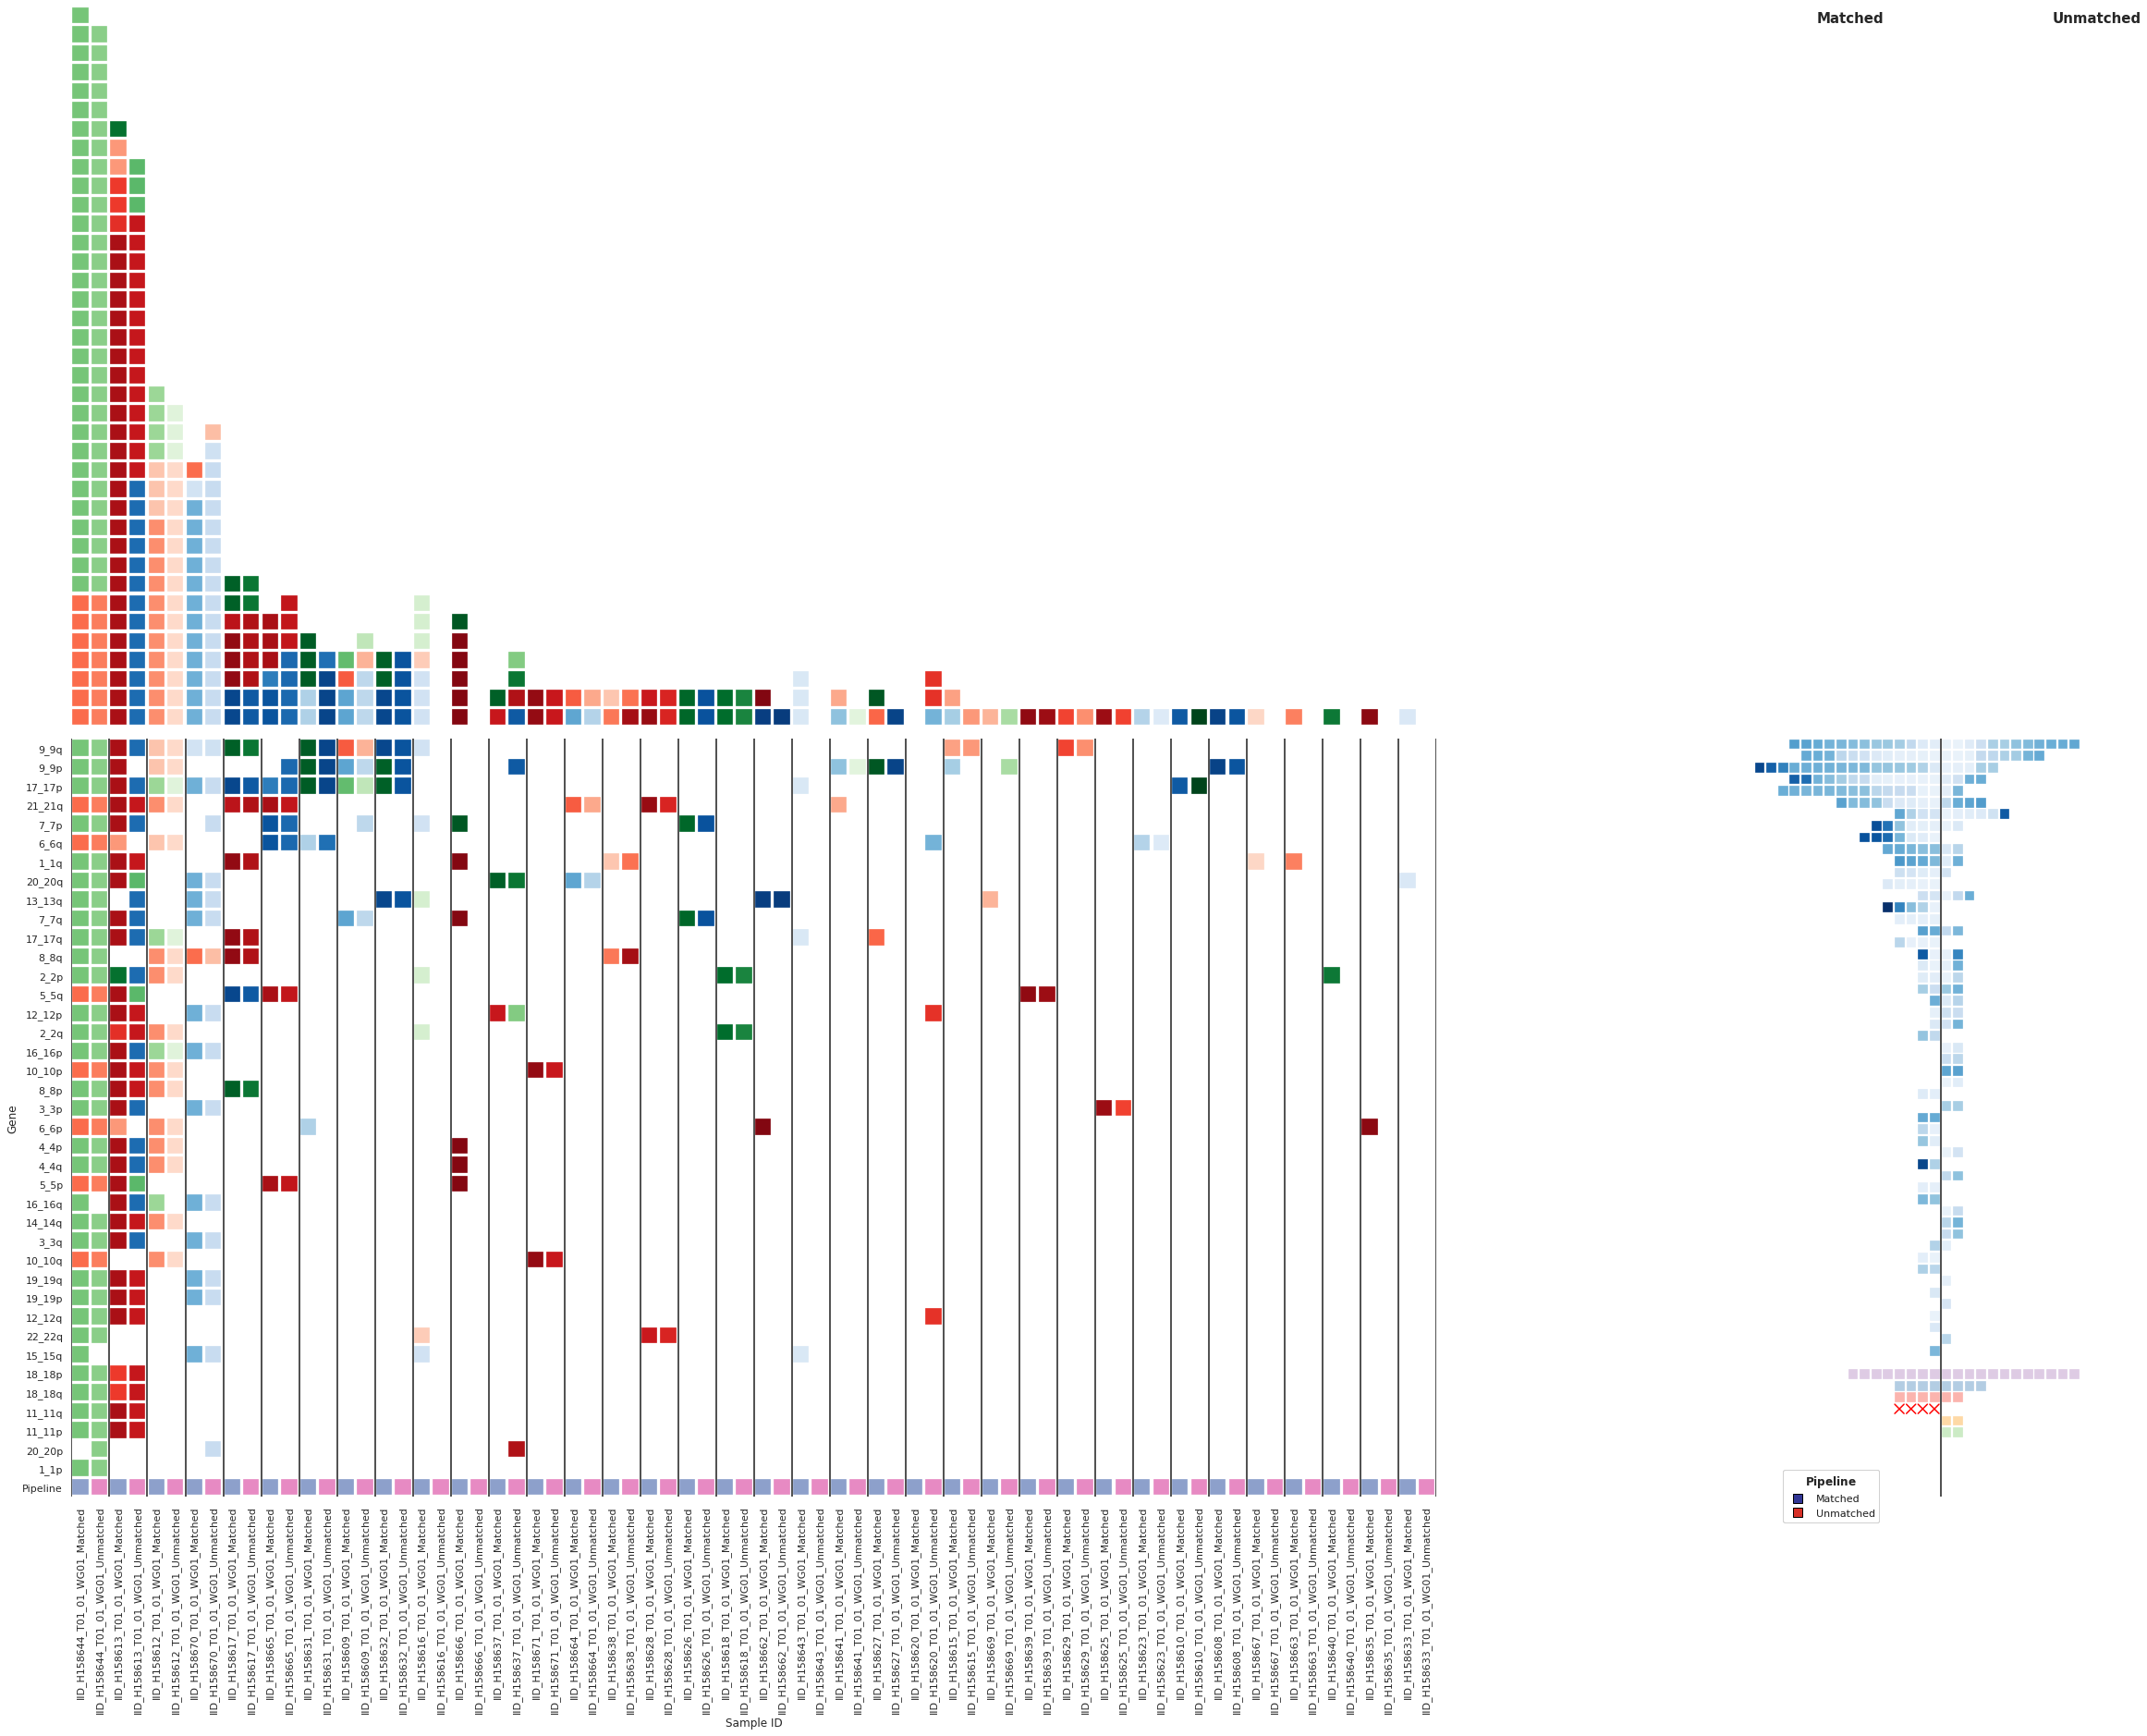

In [658]:
# gridspec_kw = {'width_ratios':[hm_bk.shape[1], side_stack_bk.shape[1]], 'height_ratios':[top_stack.shape[1], top_stack.shape[1]]}


line_spacing=[]
for i in range(0,len(hm_fg2.columns)+2,2):
    line_spacing.append(i)


# if clause to make sure y-indexes are the same
if hm_bk2.index.tolist() == hm_fg2.index.tolist():

    fig, ((axts0,axts1), (ax,ax2)) = plt.subplots(2,2, figsize=(37,26.25), gridspec_kw = {'width_ratios':[new_bk.shape[1], exploder_bk.shape[1]], \
                                                                                       'height_ratios':[top_stack.shape[0], new_bk.shape[0]]})
    #fig.text(0.20, .99, "Relapse", fontsize=15, fontweight='bold', ha='center', va='top')
    #fig.text(0.55, .99, "Non-Relapse", fontsize=15, fontweight='bold', ha='center', va='top')
    #fig.text(0.80, .99, "Relapse", fontsize=15, fontweight='bold', ha='center', va='top')
    #fig.text(0.90, .99, "Non-Relapse", fontsize=15, fontweight='bold', ha='center', va='top')
    
    axts1.set_visible(False)
#     axts1.set_frame_on(False)
    axts1.set_xticklabels([])
    axts1.set_yticklabels([])
    
    hm_ts = sns.heatmap(new_top_stack.fillna(0), \
                     cmap=['white'], \
                     cbar=False, \
                     linewidths=.5, \
                     square=True, \
                     ax=axts0)
#     hm_ts.vlines(line_spacing, *axts0.get_ylim())
    
    for (x,y), val in np.ndenumerate(new_top_stack_j_MIX.replace(intdict_inv)):
        if val!=None:
            val_value=float(str(val).split('_')[1])
            val_type=str(val).split('_')[0]
            if isinstance(val_value, float):
                if val_value > 0:
                    if(val_type=='LOSSs'):
                        axts0.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap.to_rgba(val_value), edgecolor='white',lw=.3))
                    if(val_type=='GAINs'):
                        axts0.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap2.to_rgba(val_value), edgecolor='white',lw=.3))
                    if(val_type=='CNLOHs'):
                        axts0.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap3.to_rgba(val_value), edgecolor='white',lw=.3))
                    
            if val in mut_col_dict.keys():
                color = mut_col_dict[val]
                axts0.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=color, edgecolor='white',lw=.3))

            
#     axts0.set_title('Relapse', loc='left', fontdict={'fontsize':25})
#     axts0.set_title('Non-Relapse', loc='right', fontdict={'fontsize':25})
    
    axts0.xaxis.set_visible(False)
    axts0.yaxis.set_visible(False)
    
    
    hm = sns.heatmap(new_bk.reindex(order_of_genes).fillna(0), \
                     cmap=['white'], \
                     cbar=False, \
                     linewidths=.5, \
                     square=True, \
                     ax=ax)
    hm.vlines(line_spacing, *ax.get_ylim())
    
    for (x,y), val in np.ndenumerate(new_fg.reindex(order_of_genes).fillna(0)):
        if isinstance(val, float):
            if val > 0:
                if(new_fg_types.reindex(order_of_genes).fillna(0).iloc[x,y]=='LOSSs'):
                    ax.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap.to_rgba(val), edgecolor='white',lw=.3))
                if(new_fg_types.reindex(order_of_genes).fillna(0).iloc[x,y]=='GAINs'):
                    ax.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap2.to_rgba(val), edgecolor='white',lw=.3))
                if(new_fg_types.reindex(order_of_genes).fillna(0).iloc[x,y]=='CNLOHs'):
                    ax.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap3.to_rgba(val), edgecolor='white',lw=.3))
        
        if val in mut_col_dict.keys():
            color = mut_col_dict[val]
            ax.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=color, edgecolor='white',lw=.3))
        elif val == 'Fail':
            ax.add_artist(mlines.Line2D([y+.05, y+.85], [x+.05, x+.85],  color='red'))
            ax.add_artist(mlines.Line2D([y+.85, y+.05], [x+.05, x+.85],  color='red'))


            

            
    yticklabels_list = [t.get_text() for t in hm.get_yticklabels()]
    yticklabels = [t for t in hm.get_yticklabels()] 
    yticklabels = ax.yaxis.get_major_ticks() 
    ylabels = ['SPACER1', 'SPACER2']
    for l in ylabels:
        if l in yticklabels_list:
            i = yticklabels_list.index(l)
            yticklabels[i].label1.set_visible(False)
            
    xticklabels_list = [t.get_text() for t in hm.get_xticklabels()]
    xticklabels = [t for t in hm.get_xticklabels()] 
    xticklabels = ax.xaxis.get_major_ticks() 
    xlabels = ['cspacer1', 'cspacer2', 'cspacer3', 'cspacer4', 'cspacer5']
    for l in xlabels:
        if l in xticklabels_list:
            i = xticklabels_list.index(l)
            xticklabels[i].label1.set_visible(False)
    ax.set_ylabel('Gene')
    ax.set_xlabel('Sample ID')
            

#     divider = make_axes_locatable(ax2)
#     cbar_ax = divider.new_vertical(size="5%", pad=0.5, pack_start=True)
#     fig.add_axes(cbar_ax)
    
#     hm2 = sns.heatmap(new_side_stack_bk.reindex(order_of_genes).fillna(0), \
#                       cmap=['white'], \
#                       linewidths=0, \
#                       linecolor='whitesmoke', \
#                       cbar=False, \
#                       square=True, \
#                       ax=ax2, \
#                       cbar_ax=cbar_ax, cbar_kws={ "orientation": "horizontal" })
    
#     for (x,y), val in np.ndenumerate(new_side_stack.reindex(order_of_genes).fillna(-5)):
# #         print(val)
#         if isinstance(val, float):
#             if 0 <= val <= 1:
#                 ax2.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap.to_rgba(val), edgecolor='white',lw=.3))
#         if val in mut_col_dict.keys():
#             color = mut_col_dict[val]
#             ax2.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=color, edgecolor='white',lw=.3))
#         elif val == 'Fail':
#             ax2.add_artist(mlines.Line2D([y+.05, y+.85], [x+.05, x+.85],  color='red'))
#             ax2.add_artist(mlines.Line2D([y+.85, y+.05], [x+.05, x+.85],  color='red'))
#         ax2.xaxis.set_visible(False)
#         ax2.yaxis.set_visible(False)
            
    explode_l_fg.shape[0]
    hm2 = sns.heatmap(exploder_bk, \
                     cmap=['white'], \
                     cbar=False, \
                     linewidths=.5, \
                     square=True, \
                     ax=ax2)

    hm2.vlines([explode_l_fg.shape[1]], *(ax2.get_ylim()[0]+5, ax2.get_ylim()[1]-5), colors='k')

    for (x,y), val in np.ndenumerate(exploder.replace(intdict_inv)):
        if isinstance(val, float):
            if val > 0:
                ax2.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap.to_rgba(val), edgecolor='white',lw=.3))
        if val in mut_col_dict.keys():
            color = mut_col_dict[val]
            ax2.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=color, edgecolor='white',lw=.3))
        elif val == 'Fail':
            ax2.add_artist(mlines.Line2D([y+.05, y+.85], [x+.05, x+.85],  color='red'))
            ax2.add_artist(mlines.Line2D([y+.85, y+.05], [x+.05, x+.85],  color='red'))
    
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    
    
    ## legend items
    ## leg1
    pre_therapy_hp = mlines.Line2D([], [], color='#313695', marker='s', linestyle='None',
                              markersize=10, label='Matched', markeredgecolor='black')
    mrd = mlines.Line2D([], [], color='#d73027', marker='s', linestyle='None',
                              markersize=10, label='Unmatched', markeredgecolor='black')
    first_legend = plt.legend(handles=[pre_therapy_hp, \
            mrd], title=r'$\bf{Pipeline}$' ,loc='lower center', bbox_to_anchor=(.2,-0.04), ncol=1, facecolor='white')
    
    ax2 = plt.gca().add_artist(first_legend)
    
    fig.subplots_adjust(wspace=0.01, hspace=0)
    plt.tight_layout()

else:
    print('Dataframe INDEX orders are not the same')

In [91]:
explode_l_fg

sid,IID_H135950_T02_01_TD01,I-H-135950-T1-2-D1-1,IID_H135955_T02_01_TD01,I-H-135955-T1-1-D1-1,IID_H156402_T02_01_TD01,IID_H156402_T01_01_TD01,I-H-135956-T2-1-D1-1,I-H-135956-T1-1-D1-1,I-H-135957-T2-1-D1-1,I-H-135957-T1-2-D1-1,I-H-135958-T2-1-D1-1,I-H-135958-T1-1-D1-1,IID_H156394_T02_01_TD01,IID_H156394_T01_02_TD01,IID_H156404_T02_01_TD01,IID_H156404_T01_02_TD01
IDH2,0.0000,0.0000,0.0000,0.5393,0.5132,0.4783,0.4377,0.4237,0.3941,0.3784,0.3429,0.3401,0.3102,0.2102,0.0658,0.0406
RUNX1,0.0000,0.0000,0.0000,0.0000,0.4802,0.4655,0.4381,0.2256,0.1694,0.1315,0.0761,0.0426,0.0251,0.0228,0.0185,0.0021
DNMT3A,0.9071,0.8015,0.6667,0.4682,0.4587,0.4506,0.4463,0.4271,0.4177,0.4118,0.3529,0.3495,0.3426,0.3208,0.2655,0.0799
FLT3,0.0000,0.0000,0.0000,0.7997,0.7479,0.4433,0.3904,0.3097,0.2126,0.1961,0.0348,0.0200,0.0152,0.0147,0.0065,0.0031
ASXL1,0.0000,0.0000,0.4634,0.4482,0.4268,0.4251,0.4218,0.4079,0.3816,0.3767,0.2357,0.1991,0.1905,0.1739,0.0128,0.0020
SRSF2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5192,0.4017,0.3992,0.3638,0.1779,0.0728,0.0607,0.0238,0.0083
TP53,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4959,0.2697,0.1310,0.1162
TET2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8745,0.7234,0.3642,0.0443,0.0273,0.0236
BCOR,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8635,0.8450,0.7500,0.4301,0.0799,0.0500,0.0019
NPM1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4884,0.4789,0.4242,0.3824,0.3820


In [92]:
exploder_bk

sid,IID_H135950_T02_01_TD01,I-H-135950-T1-2-D1-1,IID_H135955_T02_01_TD01,I-H-135955-T1-1-D1-1,IID_H156402_T02_01_TD01,IID_H156402_T01_01_TD01,I-H-135956-T2-1-D1-1,I-H-135956-T1-1-D1-1,I-H-135957-T2-1-D1-1,I-H-135957-T1-2-D1-1,I-H-135958-T2-1-D1-1,I-H-135958-T1-1-D1-1,IID_H156394_T02_01_TD01,IID_H156394_T01_02_TD01,IID_H156404_T02_01_TD01,IID_H156404_T01_02_TD01,I-H-112855-T1-1-D1-2,I-H-112855-T2-1-D1-1,I-H-113385-T1-1-D1-2,I-H-113385-T3-1-D1-1,I-H-113386-T1-1-D1-2,I-H-113386-T2-1-D1-1,I-H-113387-T1-1-D1-2,I-H-113387-T2-1-D1-1,I-H-113388-T1-1-D1-2,I-H-113388-T2-1-D1-1,I-H-121248-T3-1-D1-1,I-H-121248-T2-1-D1-1,cspacer1,cspacer2,cspacer3,cspacer4,cspacer5
IDH2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0
RUNX1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0
DNMT3A,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0
FLT3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0
ASXL1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0
SRSF2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0
TP53,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0
TET2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0
BCOR,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0
NPM1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0


In [93]:
exploder

sid,IID_H135950_T02_01_TD01,I-H-135950-T1-2-D1-1,IID_H135955_T02_01_TD01,I-H-135955-T1-1-D1-1,IID_H156402_T02_01_TD01,IID_H156402_T01_01_TD01,I-H-135956-T2-1-D1-1,I-H-135956-T1-1-D1-1,I-H-135957-T2-1-D1-1,I-H-135957-T1-2-D1-1,I-H-135958-T2-1-D1-1,I-H-135958-T1-1-D1-1,IID_H156394_T02_01_TD01,IID_H156394_T01_02_TD01,IID_H156404_T02_01_TD01,IID_H156404_T01_02_TD01,I-H-112855-T1-1-D1-2,I-H-112855-T2-1-D1-1,I-H-113385-T1-1-D1-2,I-H-113385-T3-1-D1-1,I-H-113386-T1-1-D1-2,I-H-113386-T2-1-D1-1,I-H-113387-T1-1-D1-2,I-H-113387-T2-1-D1-1,I-H-113388-T1-1-D1-2,I-H-113388-T2-1-D1-1,I-H-121248-T3-1-D1-1,I-H-121248-T2-1-D1-1,cspacer1,cspacer2,cspacer3,cspacer4,cspacer5
IDH2,0.0000,0.0000,0.0000,0.5393,0.5132,0.4783,0.4377,0.4237,0.3941,0.3784,0.3429,0.3401,0.3102,0.2102,0.0658,0.0406,0.0007,0.0012,0.0579,0.1581,0.2885,0.2979,0.3675,0.4000,0.4475,0.4654,0.471,0.4941,0,0,0,0,0
RUNX1,0.0000,0.0000,0.0000,0.0000,0.4802,0.4655,0.4381,0.2256,0.1694,0.1315,0.0761,0.0426,0.0251,0.0228,0.0185,0.0021,0.0020,0.0032,0.0212,0.1991,0.2175,0.2815,0.3072,0.4353,0.4833,0.0000,0.000,0.0000,0,0,0,0,0
DNMT3A,0.9071,0.8015,0.6667,0.4682,0.4587,0.4506,0.4463,0.4271,0.4177,0.4118,0.3529,0.3495,0.3426,0.3208,0.2655,0.0799,0.0139,0.0231,0.0278,0.2920,0.2964,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0,0,0,0,0
FLT3,0.0000,0.0000,0.0000,0.7997,0.7479,0.4433,0.3904,0.3097,0.2126,0.1961,0.0348,0.0200,0.0152,0.0147,0.0065,0.0031,0.0568,0.1402,0.4575,0.4679,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0,0,0,0,0
ASXL1,0.0000,0.0000,0.4634,0.4482,0.4268,0.4251,0.4218,0.4079,0.3816,0.3767,0.2357,0.1991,0.1905,0.1739,0.0128,0.0020,0.0419,0.4223,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0,0,0,0,0
SRSF2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5192,0.4017,0.3992,0.3638,0.1779,0.0728,0.0607,0.0238,0.0083,0.2222,0.4646,0.5075,0.5472,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0,0,0,0,0
TP53,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4959,0.2697,0.1310,0.1162,0.0027,0.0317,0.0435,0.0666,0.1353,0.8250,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0,0,0,0,0
TET2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8745,0.7234,0.3642,0.0443,0.0273,0.0236,0.0013,0.0769,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0,0,0,0,0
BCOR,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8635,0.8450,0.7500,0.4301,0.0799,0.0500,0.0019,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0,0,0,0,0
NPM1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4884,0.4789,0.4242,0.3824,0.3820,0.0968,0.2421,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0,0,0,0,0


### - Side Stacker:

In [619]:
def oppstack2(df, order_of_genes,relapse=True):
    df_sorter = df.reindex(order_of_genes).drop(['Pipeline']).replace(0, np.nan)
    a = df_sorter.values

    a.sort(axis=1)
    
    if relapse:
        a = a[:, ::-1]


    fg = pd.DataFrame(a, df_sorter.index, df_sorter.columns).dropna(how='all', axis=1).fillna(0)
#     fg = fg.iloc[:, ::-1]
    bk = fg.applymap(lambda x: (x+1)/(x+1))
    
    #for i in [1,2,3,4,5]:
        #fg.loc[fg.shape[0]] = np.nan
        #bk.loc[bk.shape[0]] = np.nan
    fg.loc[fg.shape[0]] = np.nan
    bk.loc[bk.shape[0]] = np.nan
        
    fg = fg.fillna(0)
    bk = bk.fillna(0)
    
    return fg, bk

In [620]:
order_of_genes

['9_9q',
 '9_9p',
 '17_17p',
 '21_21q',
 '7_7p',
 '6_6q',
 '1_1q',
 '20_20q',
 '13_13q',
 '7_7q',
 '17_17q',
 '8_8q',
 '2_2p',
 '5_5q',
 '12_12p',
 '2_2q',
 '16_16p',
 '10_10p',
 '8_8p',
 '3_3p',
 '6_6p',
 '4_4p',
 '4_4q',
 '5_5p',
 '16_16q',
 '14_14q',
 '3_3q',
 '10_10q',
 '19_19q',
 '19_19p',
 '12_12q',
 '22_22q',
 '15_15q',
 '18_18p',
 '18_18q',
 '11_11q',
 '11_11p',
 '20_20p',
 '1_1p',
 'Pipeline']

In [621]:
cols_jesus = [c for c in new_fg.columns if "Matched" in c]
rel_df_jesus=new_fg[cols_jesus]
cols_jesus = [c for c in new_fg.columns if not "Matched" in c]
non_rel_df_jesus=new_fg[cols_jesus]
col_order_jesus = rel_df_jesus.columns.tolist()+non_rel_df_jesus.columns.tolist()


explode_l_fg_jesus, explode_l_bg_jesus = oppstack2(rel_df_jesus, order_of_genes)
explode_r_fg_jesus, explode_r_bg_jesus = oppstack2(non_rel_df_jesus, order_of_genes)

exploder_jesus = pd.concat([explode_l_fg_jesus, explode_r_fg_jesus[explode_r_fg_jesus.columns[::-1]]], axis=1)
exploder_bk_jesus = pd.concat([explode_l_bg_jesus, explode_r_bg_jesus[explode_r_bg_jesus.columns[::-1]]], axis=1)

In [622]:
cols_jesus = [c for c in new_fg_j_MIX.columns if "Matched" in c]
rel_df_jesus=new_fg[cols_jesus]

In [623]:
def oppstack3(df, order_of_genes,relapse=True):
    df_sorter = df.reindex(order_of_genes).drop(['Pipeline']).replace(0, np.nan)
    
    a=[]
    for index,row in df_sorter.iterrows():
        a.append(row.sort_values())
    a=np.asarray(a)
    
    if relapse:
        a = a[:, ::-1]


    fg = pd.DataFrame(a, df_sorter.index, df_sorter.columns).dropna(how='all', axis=1).fillna(0)
#     fg = fg.iloc[:, ::-1]
    bk = pd.DataFrame(a, df_sorter.index, df_sorter.columns).dropna(how='all', axis=1).fillna(0)
    
    #for i in [1,2,3,4,5]:
        #fg.loc[fg.shape[0]] = np.nan
        #bk.loc[bk.shape[0]] = np.nan
    fg.loc[fg.shape[0]] = np.nan
    bk.loc[bk.shape[0]] = np.nan
        
    fg = fg.fillna(0)
    bk = bk.fillna(0)
    
    return fg, bk

In [624]:
df_sorter = rel_df_jesus.reindex(order_of_genes).drop(['Pipeline']).replace(0, np.nan)
a = df_sorter.values
a.sort(axis=1)
print(type(a))
a

<class 'numpy.ndarray'>


array([[0.12703126, 0.13416   , 0.16060757, ...,        nan,        nan,
               nan],
       [0.16060757, 0.30088473, 0.36936   , ...,        nan,        nan,
               nan],
       [0.08710965, 0.3444    , 0.4527    , ...,        nan,        nan,
               nan],
       ...,
       [0.45731   , 0.84832   ,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.45731   ,        nan,        nan, ...,        nan,        nan,
               nan]])

In [625]:
df_sorter = rel_df_jesus_types.reindex(order_of_genes).drop(['Pipeline']).replace(0, np.nan)
a=[]
for index,row in df_sorter.iterrows():
    a.append(row.sort_values())
a=np.asarray(a)

In [626]:
cols_jesus_types = [c for c in new_fg_types.columns if "Matched" in c]
rel_df_jesus_types=new_fg_types[cols_jesus_types]

cols_jesus_types = [c for c in new_fg_types.columns if not "Matched" in c]
non_rel_df_jesus_types=new_fg_types[cols_jesus_types]
col_order_jesus_types = rel_df_jesus_types.columns.tolist()+non_rel_df_jesus_types.columns.tolist()


explode_l_fg_jesus_types, explode_l_bg_jesus_types = oppstack3(rel_df_jesus_types, order_of_genes)
explode_r_fg_jesus_types, explode_r_bg_jesus_types = oppstack3(non_rel_df_jesus_types, order_of_genes)

exploder_jesus_types = pd.concat([explode_l_fg_jesus_types, explode_r_fg_jesus_types[explode_r_fg_jesus_types.columns[::-1]]], axis=1)
exploder_bk_jesus_types = pd.concat([explode_l_bg_jesus_types, explode_r_bg_jesus_types[explode_r_bg_jesus_types.columns[::-1]]], axis=1)

In [631]:
exploder_jesus

Sample_Pipeline,IID_H158639_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Unmatched,IID_H158635_T01_01_WG01_Unmatched,IID_H158640_T01_01_WG01_Unmatched,IID_H158663_T01_01_WG01_Unmatched,IID_H158667_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Unmatched
9_9q,0.9177,0.90630,0.90528,0.84832,0.575360,0.504500,0.457310,0.281668,0.160608,0.134160,0.127031,0.083765,0.144532,0.219927,0.310000,0.337819,0.395646,0.748652,0.824857,0.851060,0.915863,0.000000
9_9p,0.0000,0.93312,0.92184,0.91770,0.905280,0.848320,0.504500,0.457310,0.369360,0.300885,0.160608,0.073538,0.083765,0.219927,0.300000,0.395646,0.761421,0.827518,0.844764,0.851060,0.915863,0.917988
17_17p,0.9177,0.90630,0.90528,0.84832,0.827478,0.681473,0.504500,0.457310,0.452700,0.344400,0.087110,0.083765,0.182791,0.219927,0.395646,0.748652,0.761421,0.824857,0.851060,0.915863,1.000000,0.000000
21_21q,0.0000,0.00000,0.00000,0.89100,0.850000,0.848320,0.788110,0.502860,0.457310,0.344400,0.255473,0.083765,0.256247,0.395646,0.683268,0.748652,0.761421,0.824857,0.000000,0.000000,0.000000,0.000000
7_7p,0.0000,0.00000,0.00000,0.00000,0.000000,0.933120,0.883500,0.850000,0.848320,0.457310,0.134160,0.182791,0.219927,0.395646,0.748652,0.761421,0.859637,0.000000,0.000000,0.000000,0.000000,0.000000
6_6q,0.0000,0.00000,0.00000,0.00000,0.000000,0.850000,0.457310,0.308763,0.271038,0.254534,0.158649,0.067363,0.083765,0.395646,0.439184,0.734599,0.761421,0.000000,0.000000,0.000000,0.000000,0.000000
1_1q,0.0000,0.00000,0.00000,0.00000,0.933120,0.906300,0.848320,0.457310,0.390320,0.154722,0.094650,0.395646,0.435697,0.748652,0.824857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20_20q,0.0000,0.00000,0.00000,0.00000,0.000000,0.905450,0.848320,0.502860,0.457310,0.452700,0.083227,0.182791,0.256247,0.395646,0.526829,0.827518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13_13q,0.0000,0.00000,0.00000,0.00000,0.000000,0.937650,0.905280,0.457310,0.452700,0.218522,0.134160,0.182791,0.395646,0.748652,0.851060,0.946928,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7_7q,0.0000,0.00000,0.00000,0.00000,0.000000,0.933120,0.883500,0.848320,0.504500,0.457310,0.452700,0.182791,0.219927,0.395646,0.748652,0.859637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### - Side Stacker: j_MIX

In [632]:
def oppstack3(df, order_of_genes,relapse=True):
    df_sorter = df.reindex(order_of_genes).drop(['Pipeline']).replace(0, np.nan)
    
    a=[]
    for index,row in df_sorter.iterrows():
        a.append(row.sort_values())
    a=np.asarray(a)
    
    if relapse:
        a = a[:, ::-1]


    fg = pd.DataFrame(a, df_sorter.index, df_sorter.columns).dropna(how='all', axis=1).fillna(0)
#     fg = fg.iloc[:, ::-1]
    bk = pd.DataFrame(a, df_sorter.index, df_sorter.columns).dropna(how='all', axis=1).fillna(0)
    
    #for i in [1,2,3,4,5]:
        #fg.loc[fg.shape[0]] = np.nan
        #bk.loc[bk.shape[0]] = np.nan
    fg.loc[fg.shape[0]] = np.nan
    bk.loc[bk.shape[0]] = np.nan
        
    fg = fg.fillna(0)
    bk = bk.fillna(0)
    
    return fg, bk

In [633]:
df_sorter = rel_df_jesus.reindex(order_of_genes).drop(['Pipeline']).replace(0, np.nan)
a = df_sorter.values
a.sort(axis=1)
print(type(a))
a

<class 'numpy.ndarray'>


array([[0.12703126, 0.13416   , 0.16060757, ...,        nan,        nan,
               nan],
       [0.16060757, 0.30088473, 0.36936   , ...,        nan,        nan,
               nan],
       [0.08710965, 0.3444    , 0.4527    , ...,        nan,        nan,
               nan],
       ...,
       [0.45731   , 0.84832   ,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.45731   ,        nan,        nan, ...,        nan,        nan,
               nan]])

In [634]:
df_sorter = rel_df_jesus_types.reindex(order_of_genes).drop(['Pipeline']).replace(0, np.nan)
a=[]
for index,row in df_sorter.iterrows():
    a.append(row.sort_values())
a=np.asarray(a)

In [635]:
new_fg_j_MIX.columns

Index(['IID_H158644_T01_01_WG01_Matched', 'IID_H158644_T01_01_WG01_Unmatched', 'IID_H158613_T01_01_WG01_Matched', 'IID_H158613_T01_01_WG01_Unmatched', 'IID_H158612_T01_01_WG01_Matched', 'IID_H158612_T01_01_WG01_Unmatched', 'IID_H158670_T01_01_WG01_Matched', 'IID_H158670_T01_01_WG01_Unmatched', 'IID_H158617_T01_01_WG01_Matched', 'IID_H158617_T01_01_WG01_Unmatched', 'IID_H158665_T01_01_WG01_Matched', 'IID_H158665_T01_01_WG01_Unmatched', 'IID_H158631_T01_01_WG01_Matched', 'IID_H158631_T01_01_WG01_Unmatched', 'IID_H158609_T01_01_WG01_Matched', 'IID_H158609_T01_01_WG01_Unmatched', 'IID_H158632_T01_01_WG01_Matched', 'IID_H158632_T01_01_WG01_Unmatched', 'IID_H158616_T01_01_WG01_Matched', 'IID_H158616_T01_01_WG01_Unmatched', 'IID_H158666_T01_01_WG01_Matched', 'IID_H158666_T01_01_WG01_Unmatched', 'IID_H158637_T01_01_WG01_Matched', 'IID_H158637_T01_01_WG01_Unmatched', 'IID_H158671_T01_01_WG01_Matched', 'IID_H158671_T01_01_WG01_Unmatched', 'IID_H158664_T01_01_WG01_Matched',
       'IID_H158664_T0

In [636]:
cols_jesus_types = [c for c in new_fg_j_MIX.columns if "Matched" in c]
rel_df_jesus_types=new_fg_j_MIX[cols_jesus_types]

cols_jesus_types = [c for c in new_fg_j_MIX.columns if not "Matched" in c]
non_rel_df_jesus_types=new_fg_j_MIX[cols_jesus_types]
col_order_jesus_types = rel_df_jesus_types.columns.tolist()+non_rel_df_jesus_types.columns.tolist()


explode_l_fg_jesus_types, explode_l_bg_jesus_types = oppstack3(rel_df_jesus_types, order_of_genes)
explode_r_fg_jesus_types, explode_r_bg_jesus_types = oppstack3(non_rel_df_jesus_types, order_of_genes)

exploder_jesus_types = pd.concat([explode_l_fg_jesus_types[explode_l_fg_jesus_types.columns[::-1]], explode_r_fg_jesus_types[explode_r_fg_jesus_types.columns[::1]]], axis=1)
exploder_bk_jesus_types = pd.concat([explode_l_bg_jesus_types[explode_l_bg_jesus_types.columns[::-1]], explode_r_bg_jesus_types[explode_r_bg_jesus_types.columns[::1]]], axis=1)

In [639]:
#exploder_bk_jesus_types

In [640]:
explode_l_fg_jesus_types=explode_l_fg_jesus_types.replace({'0_0':None}).drop([39]).dropna(axis=1,how='all')
exploder_bk_jesus_types=exploder_bk_jesus_types.replace({'0_0':None}).drop([39]).dropna(axis=1,how='all')
exploder_jesus_types=exploder_jesus_types.replace({'0_0':None}).drop([39]).dropna(axis=1,how='all')

In [648]:
exploder_bk_jesus

Sample_Pipeline,IID_H158639_T01_01_WG01_Matched,IID_H158629_T01_01_WG01_Matched,IID_H158625_T01_01_WG01_Matched,IID_H158623_T01_01_WG01_Matched,IID_H158610_T01_01_WG01_Matched,IID_H158608_T01_01_WG01_Matched,IID_H158667_T01_01_WG01_Matched,IID_H158663_T01_01_WG01_Matched,IID_H158640_T01_01_WG01_Matched,IID_H158635_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Matched,IID_H158633_T01_01_WG01_Unmatched,IID_H158635_T01_01_WG01_Unmatched,IID_H158640_T01_01_WG01_Unmatched,IID_H158663_T01_01_WG01_Unmatched,IID_H158667_T01_01_WG01_Unmatched,IID_H158608_T01_01_WG01_Unmatched,IID_H158610_T01_01_WG01_Unmatched,IID_H158623_T01_01_WG01_Unmatched,IID_H158625_T01_01_WG01_Unmatched,IID_H158629_T01_01_WG01_Unmatched,IID_H158639_T01_01_WG01_Unmatched
9_9q,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9_9p,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
17_17p,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
21_21q,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7_7p,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6_6q,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1_1q,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
20_20q,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
13_13q,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7_7q,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Plot data

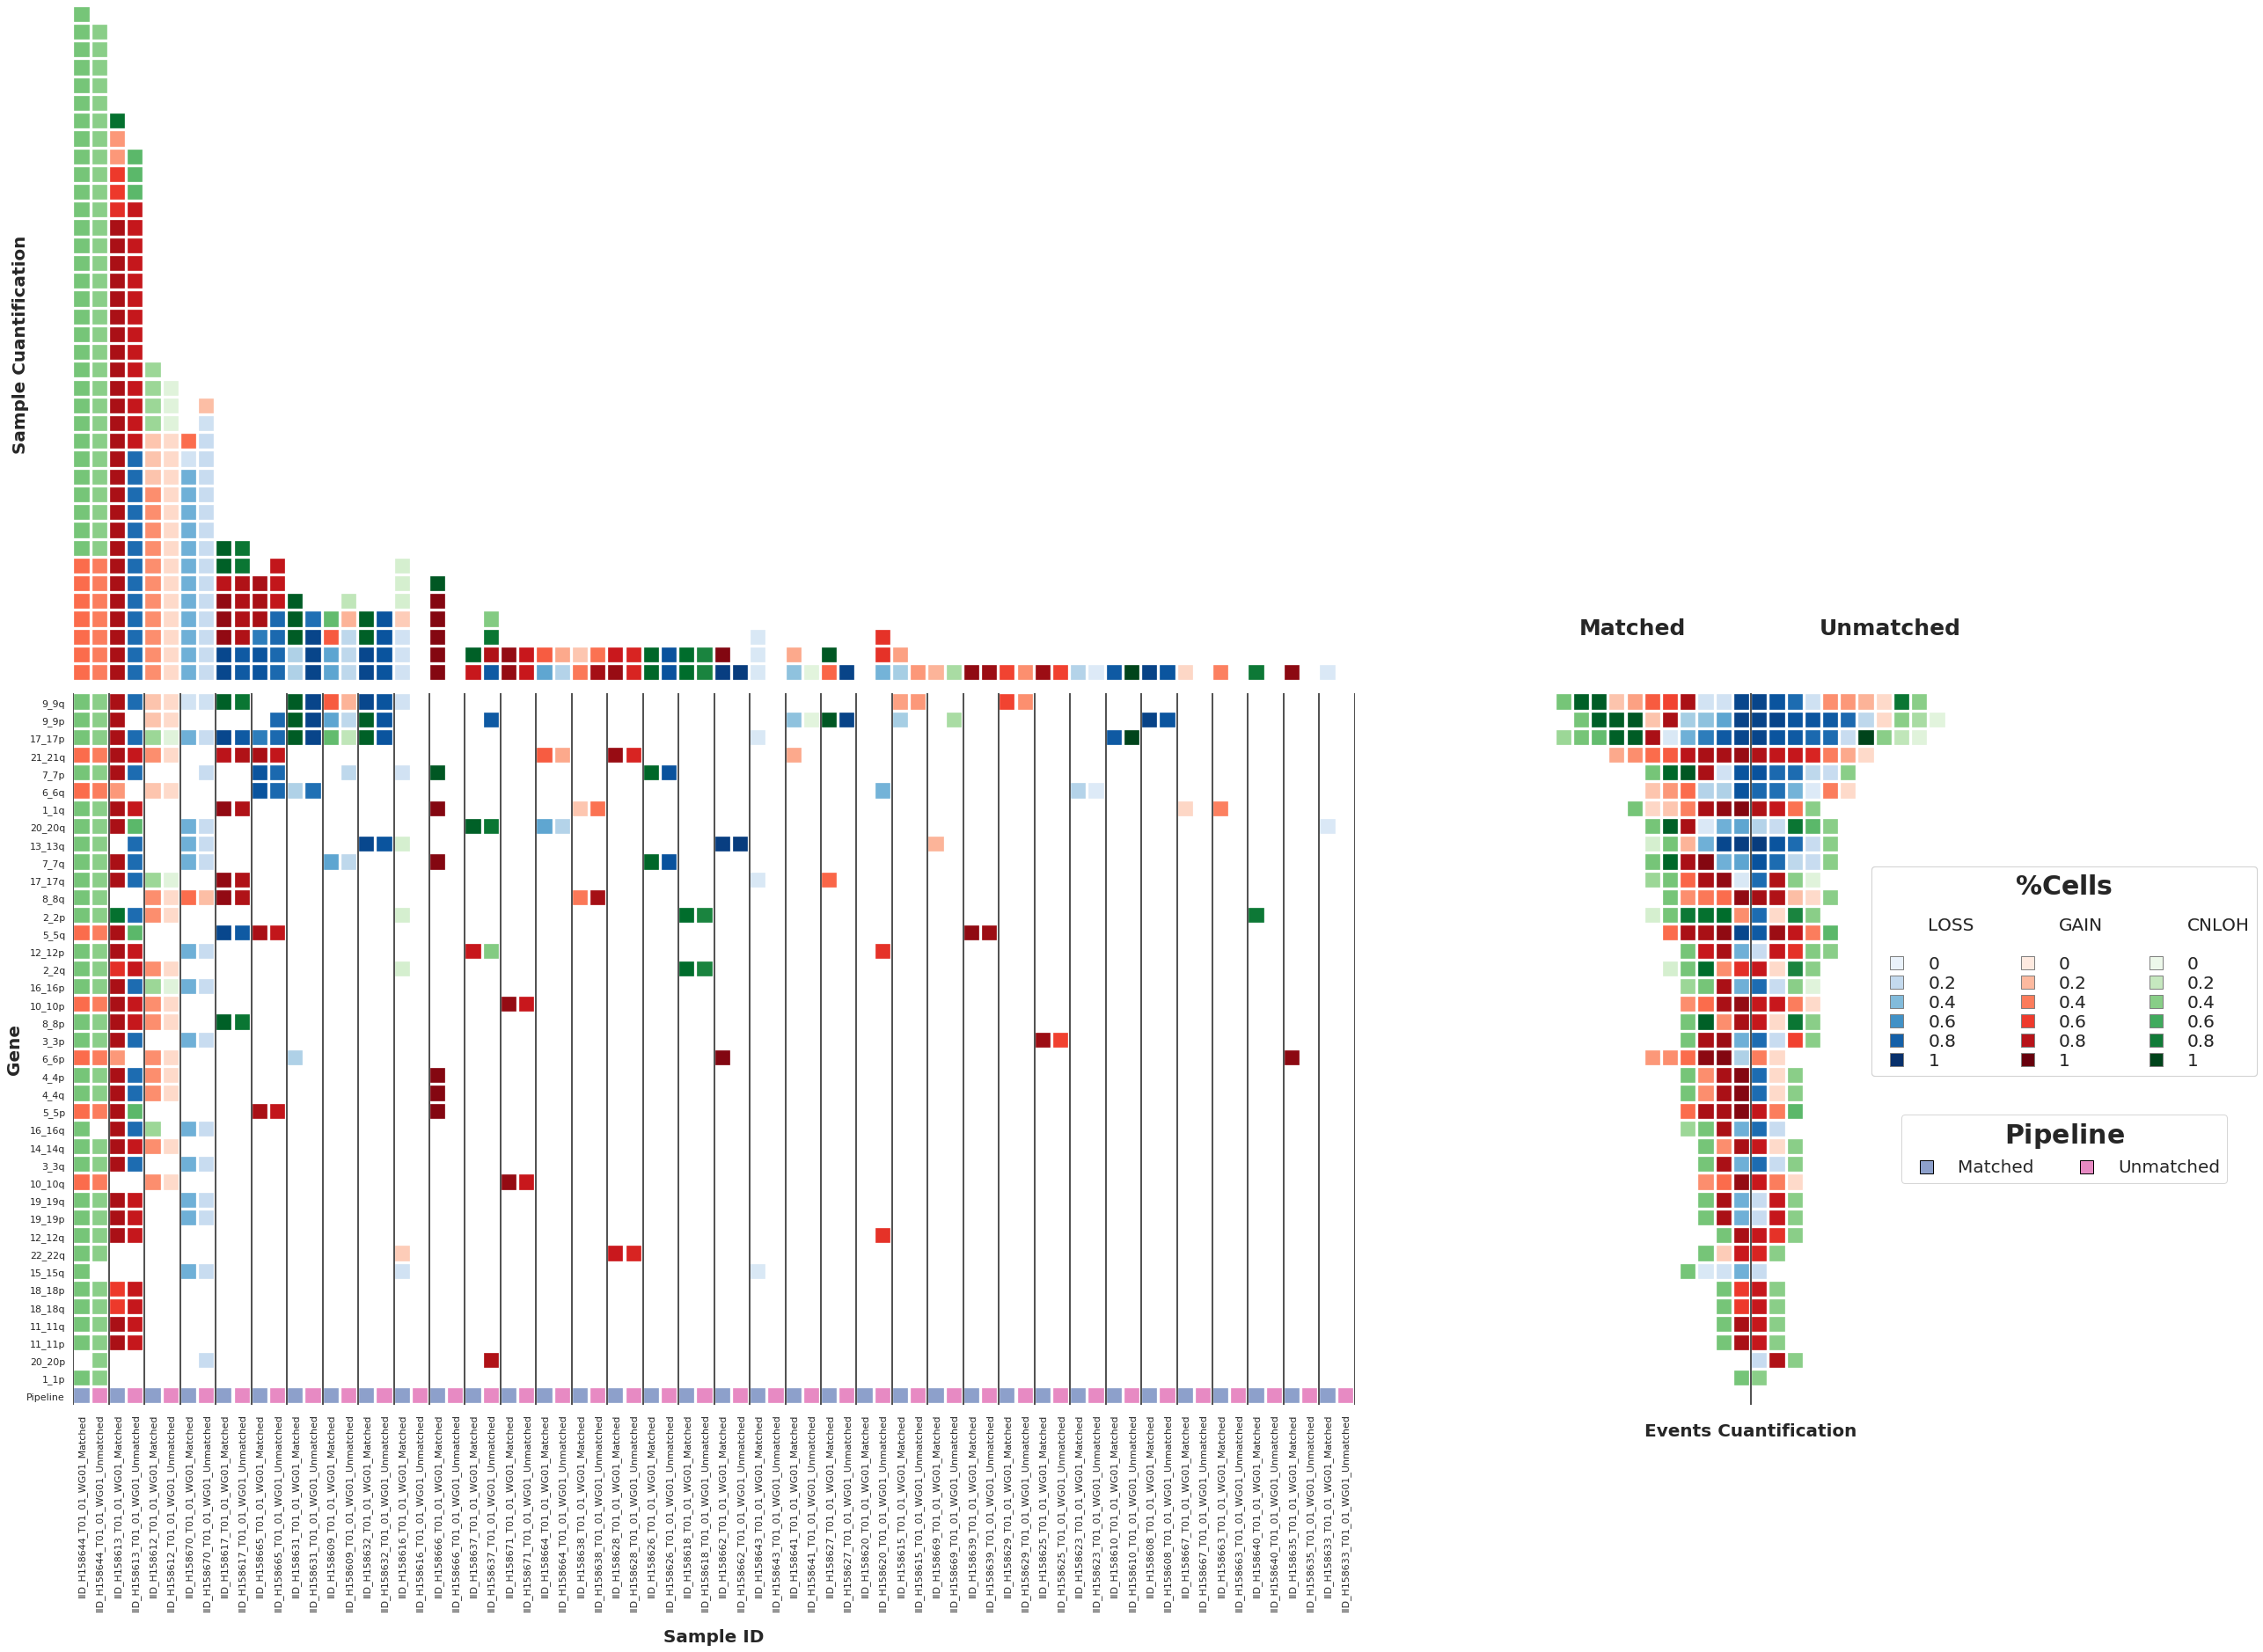

In [770]:
# gridspec_kw = {'width_ratios':[hm_bk.shape[1], side_stack_bk.shape[1]], 'height_ratios':[top_stack.shape[1], top_stack.shape[1]]}


line_spacing=[]
for i in range(0,len(hm_fg2.columns)+2,2):
    line_spacing.append(i)


# if clause to make sure y-indexes are the same
if hm_bk2.index.tolist() == hm_fg2.index.tolist():

    fig, ((axts0,axts1), (ax,ax2)) = plt.subplots(2,2, figsize=(37,26.25), gridspec_kw = {'width_ratios':[new_bk.shape[1], exploder_bk.shape[1]], \
                                                                                       'height_ratios':[top_stack.shape[0], new_bk.shape[0]]})
    #fig.text(0.20, .99, "Relapse", fontsize=15, fontweight='bold', ha='center', va='top')
    #fig.text(0.55, .99, "Non-Relapse", fontsize=15, fontweight='bold', ha='center', va='top')
    fig.text(0.72, .625, "Matched", fontsize=25, fontweight='bold', ha='center', va='top')
    fig.text(0.83, .625, "Unmatched", fontsize=25, fontweight='bold', ha='center', va='top')
    
    axts1.set_visible(False)
#     axts1.set_frame_on(False)
    axts1.set_xticklabels([])
    axts1.set_yticklabels([])
    
    hm_ts = sns.heatmap(new_top_stack.fillna(0), \
                     cmap=['white'], \
                     cbar=False, \
                     linewidths=.5, \
                     square=True, \
                     ax=axts0)
#     hm_ts.vlines(line_spacing, *axts0.get_ylim())
    
    for (x,y), val in np.ndenumerate(new_top_stack_j_MIX.replace(intdict_inv)):
        if val!=None:
            val_value=float(str(val).split('_')[1])
            val_type=str(val).split('_')[0]
            if isinstance(val_value, float):
                if val_value > 0:
                    if(val_type=='LOSSs'):
                        axts0.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap.to_rgba(val_value), edgecolor='white',lw=.3))
                    if(val_type=='GAINs'):
                        axts0.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap2.to_rgba(val_value), edgecolor='white',lw=.3))
                    if(val_type=='CNLOHs'):
                        axts0.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap3.to_rgba(val_value), edgecolor='white',lw=.3))
                    
            if val in mut_col_dict.keys():
                color = mut_col_dict[val]
                axts0.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=color, edgecolor='white',lw=.3))

            
#     axts0.set_title('Relapse', loc='left', fontdict={'fontsize':25})
#     axts0.set_title('Non-Relapse', loc='right', fontdict={'fontsize':25})
    
    axts0.xaxis.set_visible(False)
    axts0.axes.get_yaxis().set_ticks([])
    axts0.set_ylabel('Sample Cuantification',fontdict=dict(weight='bold'),fontsize=20,labelpad=50)
    
    
    hm = sns.heatmap(new_bk.reindex(order_of_genes).fillna(0), \
                     cmap=['white'], \
                     cbar=False, \
                     linewidths=.5, \
                     square=True, \
                     ax=ax)
    hm.vlines(line_spacing, *ax.get_ylim())
    
    for (x,y), val in np.ndenumerate(new_fg.reindex(order_of_genes).fillna(0)):
        if isinstance(val, float):
            if val > 0:
                if(new_fg_types.reindex(order_of_genes).fillna(0).iloc[x,y]=='LOSSs'):
                    ax.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap.to_rgba(val), edgecolor='white',lw=.3))
                if(new_fg_types.reindex(order_of_genes).fillna(0).iloc[x,y]=='GAINs'):
                    ax.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap2.to_rgba(val), edgecolor='white',lw=.3))
                if(new_fg_types.reindex(order_of_genes).fillna(0).iloc[x,y]=='CNLOHs'):
                    ax.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap3.to_rgba(val), edgecolor='white',lw=.3))
        
        if val in mut_col_dict.keys():
            color = mut_col_dict[val]
            ax.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=color, edgecolor='white',lw=.3))
        elif val == 'Fail':
            ax.add_artist(mlines.Line2D([y+.05, y+.85], [x+.05, x+.85],  color='red'))
            ax.add_artist(mlines.Line2D([y+.85, y+.05], [x+.05, x+.85],  color='red'))


            

            
    yticklabels_list = [t.get_text() for t in hm.get_yticklabels()]
    yticklabels = [t for t in hm.get_yticklabels()] 
    yticklabels = ax.yaxis.get_major_ticks() 
    ylabels = ['SPACER1', 'SPACER2']
    for l in ylabels:
        if l in yticklabels_list:
            i = yticklabels_list.index(l)
            yticklabels[i].label1.set_visible(False)
            
    xticklabels_list = [t.get_text() for t in hm.get_xticklabels()]
    xticklabels = [t for t in hm.get_xticklabels()] 
    xticklabels = ax.xaxis.get_major_ticks() 
    xlabels = ['cspacer1']
    for l in xlabels:
        if l in xticklabels_list:
            i = xticklabels_list.index(l)
            xticklabels[i].label1.set_visible(False)
    ax.set_ylabel('Gene',fontdict=dict(weight='bold'),fontsize=20)
    ax.set_xlabel('Sample ID',fontdict=dict(weight='bold'),fontsize=20,labelpad=20)
            

#     divider = make_axes_locatable(ax2)
#     cbar_ax = divider.new_vertical(size="5%", pad=0.5, pack_start=True)
#     fig.add_axes(cbar_ax)
    
#     hm2 = sns.heatmap(new_side_stack_bk.reindex(order_of_genes).fillna(0), \
#                       cmap=['white'], \
#                       linewidths=0, \
#                       linecolor='whitesmoke', \
#                       cbar=False, \
#                       square=True, \
#                       ax=ax2, \
#                       cbar_ax=cbar_ax, cbar_kws={ "orientation": "horizontal" })
    
#     for (x,y), val in np.ndenumerate(new_side_stack.reindex(order_of_genes).fillna(-5)):
# #         print(val)
#         if isinstance(val, float):
#             if 0 <= val <= 1:
#                 ax2.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap.to_rgba(val), edgecolor='white',lw=.3))
#         if val in mut_col_dict.keys():
#             color = mut_col_dict[val]
#             ax2.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=color, edgecolor='white',lw=.3))
#         elif val == 'Fail':
#             ax2.add_artist(mlines.Line2D([y+.05, y+.85], [x+.05, x+.85],  color='red'))
#             ax2.add_artist(mlines.Line2D([y+.85, y+.05], [x+.05, x+.85],  color='red'))
#         ax2.xaxis.set_visible(False)
#         ax2.yaxis.set_visible(False)
            
    explode_l_fg_jesus.shape[0]
    hm2 = sns.heatmap(exploder_bk_jesus, \
                     cmap=['white'], \
                     cbar=False, \
                     linewidths=.5, \
                     square=True, \
                     ax=ax2)

    hm2.vlines([explode_l_fg_jesus.shape[1]], *(ax2.get_ylim()[0]+5, ax2.get_ylim()[1]-5), colors='k')

    for (x,y), val in np.ndenumerate(exploder_jesus_types.replace(intdict_inv)):
        if val!=None:
            val_value=float(str(val).split('_')[1])
            val_type=str(val).split('_')[0]
            if isinstance(val_value, float):
                if val_value > 0:
                    if(val_type=='LOSSs'):
                        ax2.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap.to_rgba(val_value), edgecolor='white',lw=.3))
                    if(val_type=='GAINs'):
                        ax2.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap2.to_rgba(val_value), edgecolor='white',lw=.3))
                    if(val_type=='CNLOHs'):
                        ax2.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=scalarMap3.to_rgba(val_value), edgecolor='white',lw=.3))
                    
                    
        if val in mut_col_dict.keys():
            color = mut_col_dict[val]
            ax2.add_artist(plt.Rectangle((y+.05, x+.05), 0.85,0.85, facecolor=color, edgecolor='white',lw=.3))
        elif val == 'Fail':
            ax2.add_artist(mlines.Line2D([y+.05, y+.85], [x+.05, x+.85],  color='red'))
            ax2.add_artist(mlines.Line2D([y+.85, y+.05], [x+.05, x+.85],  color='red'))
    
    #ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    ax2.axes.get_xaxis().set_ticks([])
    ax2.set_xlabel('Events Cuantification',fontdict=dict(weight='bold'),fontsize=20,labelpad=20)
 
        
    
    
    
    ## legend items
    
    ## leg1
    pre_therapy_hp = mlines.Line2D([], [], color='#8DA0CB', marker='s', linestyle='None',
                              markersize=15, label='Matched', markeredgecolor='black')
    mrd = mlines.Line2D([], [], color='#E78AC3', marker='s', linestyle='None',
                              markersize=15, label='Unmatched', markeredgecolor='black')
    first_legend = plt.legend(handles=[pre_therapy_hp, \
            mrd], title=r'$\bf{Pipeline}$' ,loc='lower center', bbox_to_anchor=(1.3,0.3), ncol=3, facecolor='white',fontsize=20,title_fontsize=30)
    
    ax2 = plt.gca().add_artist(first_legend)
    
    
    ## leg2
    #loss = mlines.Line2D([], [], color=scalarMap.to_rgba(0.6), marker='s', linestyle='None',
                              #markersize=10, label='LOSS', markeredgecolor='black')
    #gain = mlines.Line2D([], [], color=scalarMap2.to_rgba(0.6), marker='s', linestyle='None',
                              #markersize=10, label='GAIN', markeredgecolor='black')
    #cnloh = mlines.Line2D([], [], color=scalarMap3.to_rgba(0.6), marker='s', linestyle='None',
                              #markersize=10, label='CNLOH', markeredgecolor='black')
    
    
    #second_legend = plt.legend(handles=[loss, \
            #gain,cnloh], title=r'$\bf{Types}$' ,loc='lower center', bbox_to_anchor=(.005,-0.1), ncol=3, facecolor='white',fontsize=10,title_fontsize=20)
    #second_legend._legend_box.sep = 20
    #ax2 = plt.gca().add_artist(second_legend)
    
    
    
    ## leg6
    lw = mlines.Line2D([], [], color='#FFFFFF', marker='s', linestyle='None',
                              markersize=15,markeredgecolor='#FFFFFF')
    
    lw_loss = mlines.Line2D([], [], color='#FFFFFF', marker='s', linestyle='None',
                              markersize=15, label='LOSS',markeredgecolor='#FFFFFF')
    l0 = mlines.Line2D([], [], color=scalarMap.to_rgba(0), marker='s', linestyle='None',
                              markersize=15, label='0',markeredgecolor='gray')
    l2 = mlines.Line2D([], [], color=scalarMap.to_rgba(0.2), marker='s', linestyle='None',
                              markersize=15, label='0.2', markeredgecolor='gray')    
    l4 = mlines.Line2D([], [], color=scalarMap.to_rgba(0.4), marker='s', linestyle='None',
                              markersize=15, label='0.4', markeredgecolor='gray')
    l6 = mlines.Line2D([], [], color=scalarMap.to_rgba(0.6), marker='s', linestyle='None',
                              markersize=15, label='0.6', markeredgecolor='gray')
    l8 = mlines.Line2D([], [], color=scalarMap.to_rgba(0.8), marker='s', linestyle='None',
                              markersize=15, label='0.8', markeredgecolor='gray')
    l10 = mlines.Line2D([], [], color=scalarMap.to_rgba(1.0), marker='s', linestyle='None',
                              markersize=15, label='1', markeredgecolor='gray')
    
    
    lw_gain = mlines.Line2D([], [], color='#FFFFFF', marker='s', linestyle='None',
                              markersize=15, label='GAIN',markeredgecolor='#FFFFFF')
    l00 = mlines.Line2D([], [], color=scalarMap2.to_rgba(0), marker='s', linestyle='None',
                              markersize=15,label='0', markeredgecolor='gray')
    l20 = mlines.Line2D([], [], color=scalarMap2.to_rgba(0.2), marker='s', linestyle='None',
                              markersize=15, label='0.2', markeredgecolor='gray')    
    l40 = mlines.Line2D([], [], color=scalarMap2.to_rgba(0.4), marker='s', linestyle='None',
                              markersize=15, label='0.4', markeredgecolor='gray')
    l60 = mlines.Line2D([], [], color=scalarMap2.to_rgba(0.6), marker='s', linestyle='None',
                              markersize=15, label='0.6', markeredgecolor='gray')
    l80 = mlines.Line2D([], [], color=scalarMap2.to_rgba(0.8), marker='s', linestyle='None',
                              markersize=15, label='0.8', markeredgecolor='gray')
    l100 = mlines.Line2D([], [], color=scalarMap2.to_rgba(1.0), marker='s', linestyle='None',
                              markersize=15, label='1', markeredgecolor='gray')
    
    lw_cnloh = mlines.Line2D([], [], color='#FFFFFF', marker='s', linestyle='None',
                              markersize=15, label='CNLOH',markeredgecolor='#FFFFFF')
    l000 = mlines.Line2D([], [], color=scalarMap3.to_rgba(0), marker='s', linestyle='None',
                              markersize=15, label='0', markeredgecolor='gray')
    l200 = mlines.Line2D([], [], color=scalarMap3.to_rgba(0.2), marker='s', linestyle='None',
                              markersize=15, label='0.2', markeredgecolor='gray')    
    l400 = mlines.Line2D([], [], color=scalarMap3.to_rgba(0.4), marker='s', linestyle='None',
                              markersize=15, label='0.4', markeredgecolor='gray')
    l600 = mlines.Line2D([], [], color=scalarMap3.to_rgba(0.6), marker='s', linestyle='None',
                              markersize=15, label='0.6', markeredgecolor='gray')
    l800 = mlines.Line2D([], [], color=scalarMap3.to_rgba(0.8), marker='s', linestyle='None',
                              markersize=15, label='0.8', markeredgecolor='gray')
    l1000 = mlines.Line2D([], [], color=scalarMap3.to_rgba(1.0), marker='s', linestyle='None',
                              markersize=15, label='1', markeredgecolor='gray')
    
    
    
    fith_legend = plt.legend(handles=[lw_loss,lw,l0, l2, l4, l6, l8, l10,lw_gain,lw,l00, l20, l40, l60, l80, l100,lw_cnloh,lw,l000, l200, l400, l600, l800, l1000], title=r'$\bf{\%Cells}$' ,loc='lower center', bbox_to_anchor=(1.3,0.45), ncol=3, facecolor='white', labelspacing=.15,fontsize=20,title_fontsize=30)
    fith_legend._legend_box.sep = 20
    ax2 = plt.gca().add_artist(fith_legend)
    
    
    
    
    
    fig.subplots_adjust(wspace=0.01, hspace=0)
    plt.tight_layout()
    #plt.show()

else:
    print('Dataframe INDEX orders are not the same')

In [752]:
exploder_bk_jesus.shape[1]

22

In [753]:
new_bk.shape[1] 

72